# 시계열 분석

In [24]:
# 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
import sys
import platform
print(sys.version)
print(platform.system())

3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
Windows


In [26]:
# 시드 고정
import random

def seed_all(seed):
    print(f'Using Seed Number {seed}')
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

def seed_worker(_worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_all(seed=42)

# def set_seed(seed):
#     np.random.seed(seed)
#     random.seed(seed)
#     os.environ["PYTHONHASHSEED"] = str(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
    
# set_seed(seed=42)

Using Seed Number 42


In [27]:
# 데이터 로드
rawdata = pd.read_excel('data/분석데이터_new.xlsx', engine='openpyxl')
rawdata.head()

년/월  시도                    산업_대분류  구인인원  취업건수   사업체 수  실업급여 수급자 수  \
0  201301  서울                       제조업    60     0   30219          97   
1  201301  서울                  도매 및 소매업   104     0  109382         202   
2  201301  서울                     정보통신업   763     4   23384        1230   
3  201301  서울          전문, 과학 및 기술 서비스업    35     1   33649          70   
4  201301  서울  사업시설 관리, 사업 지원 및 임대 서비스업    64     0   11578          62   

   각 지역별 인구  GDP(실질)    금리    CLI 지수  소비자 심리지수  
0  10195064   1562.7  2.75  99.14964     101.0  
1  10195064   1562.7  2.75  99.14964     101.0  
2  10195064   1562.7  2.75  99.14964     101.0  
3  10195064   1562.7  2.75  99.14964     101.0  
4  10195064   1562.7  2.75  99.14964     101.0

In [28]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   년/월         10200 non-null  int64  
 1   시도          10200 non-null  object 
 2   산업_대분류      10200 non-null  object 
 3   구인인원        10200 non-null  int64  
 4   취업건수        10200 non-null  int64  
 5   사업체 수       10200 non-null  int64  
 6   실업급여 수급자 수  10200 non-null  int64  
 7   각 지역별 인구    10200 non-null  int64  
 8   GDP(실질)     10200 non-null  float64
 9   금리          10200 non-null  float64
 10  CLI 지수      10200 non-null  float64
 11  소비자 심리지수    10200 non-null  float64
dtypes: float64(4), int64(6), object(2)
memory usage: 956.4+ KB


In [29]:
# 컬럼명 맞추기
rawdata.columns=['date', 'city', 'industry', 'job_offer', 'employment',
              'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']

# date 컬럼 날짜 데이터로 변경
rawdata['date'] = pd.to_datetime(rawdata['date'], format='%Y%m')
# rawdata.set_index('date', inplace=True)
# rawdata = rawdata.to_period(freq='M')
rawdata.head()

# int 형식을 float 형식으로 변경
rawdata['job_offer'] = rawdata['job_offer'].astype(float)
rawdata['employment'] = rawdata['employment'].astype(float)
rawdata['no_company'] = rawdata['no_company'].astype(float)
rawdata['unemployment'] = rawdata['unemployment'].astype(float)
rawdata['population'] = rawdata['population'].astype(float)

In [30]:
print(len(rawdata) * 0.8)

8160.0


In [31]:
rawdata.columns

Index(['date', 'city', 'industry', 'job_offer', 'employment', 'no_company',
       'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI'],
      dtype='object')

In [32]:
# np.expm1()로 복구
log_data = rawdata.copy()
log_data['job_offer'] = np.log1p(log_data['job_offer'])
log_data['employment'] = np.log1p(log_data['employment'])
log_data['no_company'] = np.log1p(log_data['no_company'])
log_data['unemployment'] = np.log1p(log_data['unemployment'])
log_data['population'] = np.log1p(log_data['population'])
log_data['GDP'] = np.log1p(log_data['GDP'])
log_data['i_rate'] = np.log1p(log_data['i_rate'])
log_data['CLI'] = np.log1p(log_data['CLI'])
log_data['CFI'] = np.log1p(log_data['CFI'])

In [33]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print('1. ADF:', dftest[0])
    print('2. p-value:', dftest[1])
    print('3. number of lags', dftest[2])
    print('4. Number of observation Used for ADF Regression and critical values calculations:', dftest[3])
    print('5. Critical Values:', dftest[4])
    for key, val in dftest[4].items():
        print('\t', key, ':', val)

In [34]:
ad_test(log_data['job_offer'])

1. ADF: -15.296585119058433
2. p-value: 4.369950472622574e-28
3. number of lags 39
4. Number of observation Used for ADF Regression and critical values calculations: 10160
5. Critical Values: {'1%': -3.430993794580203, '5%': -2.861824519401592, '10%': -2.5669214445350765}
	 1% : -3.430993794580203
	 5% : -2.861824519401592
	 10% : -2.5669214445350765


## LSTM 모델

In [35]:
seed_all(seed=42)

Using Seed Number 42


In [36]:
# train, test set 분리
train_data1 = rawdata.iloc[:8160, :].reset_index(drop=True)
test_data1 = rawdata.iloc[8160:, :].reset_index(drop=True)
print(train_data1.shape, test_data1.shape)

(8160, 12) (2040, 12)


In [37]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data1[object_columns])
train_cat = oe.transform(train_data1[object_columns])
test_cat = oe.transform(test_data1[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data1 = pd.concat([train_data1, train_cat_df], axis=1)
test_data1 = pd.concat([test_data1, test_cat_df], axis=1)

c:\Users\yju12\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [38]:
train_data1.drop(object_columns, axis=1, inplace=True)
test_data1.drop(object_columns, axis=1, inplace=True)

In [39]:
display(train_data1, test_data1)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01       60.0         0.0     30219.0          97.0  10195064.0   
1    2013-01-01      104.0         0.0    109382.0         202.0  10195064.0   
2    2013-01-01      763.0         4.0     23384.0        1230.0  10195064.0   
3    2013-01-01       35.0         1.0     33649.0          70.0  10195064.0   
4    2013-01-01       64.0         0.0     11578.0          62.0  10195064.0   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01       37.0         0.0      1955.0           1.0    674635.0   
8156 2020-12-01        0.0         0.0      6551.0           3.0    674635.0   
8157 2020-12-01        6.0         0.0       428.0          16.0    674635.0   
8158 2020-12-01        0.0         0.0      1337.0           3.0    674635.0   
8159 2020-12-01        4.0         0.0      1282.0           2.0    674635.0   

         GDP  i_rate        CLI    CFI  ...   인천   전남   전북   제주   충남   충북  \
0     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
1     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
2     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
3     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
4     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
...      ...     ...        ...    ...  ...  ...  ...  ...  ...  ...  ...   
8155  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8156  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8157  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8158  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8159  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   

      사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0                          0.0               0.0    0.0  1.0  
1                          0.0               0.0    0.0  0.0  
2                          0.0               0.0    1.0  0.0  
3                          0.0               1.0    0.0  0.0  
4                          1.0               0.0    0.0  0.0  
...                        ...               ...    ...  ...  
8155                       0.0               0.0    0.0  1.0  
8156                       0.0               0.0    0.0  0.0  
8157                       0.0               0.0    1.0  0.0  
8158                       0.0               1.0    0.0  0.0  
8159                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01       35.0         2.0     32388.0         115.0   9657969.0   
1    2021-01-01       34.0         0.0    131425.0         167.0   9657969.0   
2    2021-01-01      633.0         7.0     32604.0        1431.0   9657969.0   
3    2021-01-01       34.0         1.0     48282.0         122.0   9657969.0   
4    2021-01-01       23.0         1.0     18711.0         104.0   9657969.0   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01        0.0         0.0      2134.0           2.0    678159.0   
2036 2022-12-01        0.0         0.0      7385.0           6.0    678159.0   
2037 2022-12-01        8.0         0.0       559.0          23.0    678159.0   
2038 2022-12-01        1.0         0.0      1561.0           4.0    678159.0   
2039 2022-12-01        0.0         0.0      1448.0           8.0    678159.0   

         GDP  i_rate        CLI   CFI  ...   인천   전남   전북   제주   충남   충북  \
0     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
1     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
2     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
3     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
4     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
...      ...     ...        ...   ...  ...  ...  ...  ...  ...  ...  ...   
2035  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2036  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2037  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2038  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2039  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   

      사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0                          0.0               0.0    0.0  1.0  
1                          0.0               0.0    0.0  0.0  
2                          0.0               0.0    1.0  0.0  
3                          0.0               1.0    0.0  0.0  
4                          1.0               0.0    0.0  0.0  
...                        ...               ...    ...  ...  
2035                       0.0               0.0    0.0  1.0  
2036                       0.0               0.0    0.0  0.0  
2037                       0.0               0.0    1.0  0.0  
2038                       0.0               1.0    0.0  0.0  
2039                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [40]:
# 날짜 컬럼을 인덱스로 사용
train_data1.set_index('date', inplace=True)
test_data1.set_index('date', inplace=True)

In [41]:
# 독립변수, 종속변수 분리
train1_x = train_data1.drop('job_offer', axis=1)
train1_y = train_data1[['job_offer']]

test1_x = test_data1.drop('job_offer', axis=1)
test1_y = test_data1[['job_offer']]

print(train1_x.shape, train1_y.shape, test1_x.shape, test1_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [42]:
train1_x.iloc[:, :8]

employment  no_company  unemployment  population     GDP  i_rate  \
date                                                                           
2013-01-01         0.0     30219.0          97.0  10195064.0  1562.7    2.75   
2013-01-01         0.0    109382.0         202.0  10195064.0  1562.7    2.75   
2013-01-01         4.0     23384.0        1230.0  10195064.0  1562.7    2.75   
2013-01-01         1.0     33649.0          70.0  10195064.0  1562.7    2.75   
2013-01-01         0.0     11578.0          62.0  10195064.0  1562.7    2.75   
...                ...         ...           ...         ...     ...     ...   
2020-12-01         0.0      1955.0           1.0    674635.0  1839.5    0.50   
2020-12-01         0.0      6551.0           3.0    674635.0  1839.5    0.50   
2020-12-01         0.0       428.0          16.0    674635.0  1839.5    0.50   
2020-12-01         0.0      1337.0           3.0    674635.0  1839.5    0.50   
2020-12-01         0.0      1282.0           2.0    674635.0  1839.5    0.50   

                  CLI    CFI  
date                          
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
...               ...    ...  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  

[8160 rows x 8 columns]

In [43]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train1_x[scale_columns]
test_scale = test1_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train1_y)
train1_y = ms.transform(train1_y)
test1_y = ms.transform(test1_y)

ss.fit(train_scale)
train1_x[scale_columns] = ss.transform(train_scale)
test1_x[scale_columns] = ss.transform(test_scale)


In [44]:
train1_x_tensors = Variable(torch.Tensor(train1_x.values))
test1_x_tensors = Variable(torch.Tensor(test1_x.values))

train1_y_tensors = Variable(torch.Tensor(train1_y))
test1_y_tensors = Variable(torch.Tensor(test1_y))

train1_x_tensors.shape, test1_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [45]:
train1_x_tensors_f = torch.reshape(train1_x_tensors, (8160, 1, 28))
test1_x_tensors_f = torch.reshape(test1_x_tensors, (2040, 1, 28))

print(train1_x_tensors_f.shape, test1_y_tensors.shape, test1_x_tensors_f.shape, test1_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [46]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [47]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.0001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train1_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [48]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train1_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train1_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.18665726482868195
Epoch: 100, loss: 0.048580851405858994
Epoch: 200, loss: 0.009568249806761742
Epoch: 300, loss: 0.003173795295879245
Epoch: 400, loss: 0.002417833311483264
Epoch: 500, loss: 0.0021445793099701405
Epoch: 600, loss: 0.0019166995771229267
Epoch: 700, loss: 0.0017278133891522884
Epoch: 800, loss: 0.0015851319767534733
Epoch: 900, loss: 0.001481349696405232


In [49]:
rawdata_scale = rawdata.copy()

In [50]:
rawdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업       60.0         0.0   
1     2013-01-01   서울                  도매 및 소매업      104.0         0.0   
2     2013-01-01   서울                     정보통신업      763.0         4.0   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업       35.0         1.0   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업       64.0         0.0   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업        0.0         0.0   
10196 2022-12-01   제주                  도매 및 소매업        0.0         0.0   
10197 2022-12-01   제주                     정보통신업        8.0         0.0   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업        1.0         0.0   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업        0.0         0.0   

       no_company  unemployment  population     GDP  i_rate       CLI    CFI  
0         30219.0          97.0  10195064.0  1562.7    2.75  99.14964  101.0  
1        109382.0         202.0  10195064.0  1562.7    2.75  99.14964  101.0  
2         23384.0        1230.0  10195064.0  1562.7    2.75  99.14964  101.0  
3         33649.0          70.0  10195064.0  1562.7    2.75  99.14964  101.0  
4         11578.0          62.0  10195064.0  1562.7    2.75  99.14964  101.0  
...           ...           ...         ...     ...     ...       ...    ...  
10195      2134.0           2.0    678159.0  1968.8    3.25  98.75089   90.2  
10196      7385.0           6.0    678159.0  1968.8    3.25  98.75089   90.2  
10197       559.0          23.0    678159.0  1968.8    3.25  98.75089   90.2  
10198      1561.0           4.0    678159.0  1968.8    3.25  98.75089   90.2  
10199      1448.0           8.0    678159.0  1968.8    3.25  98.75089   90.2  

[10200 rows x 12 columns]

In [51]:
object_columns = ['city', 'industry']

raw_cat = oe.transform(rawdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
raw_cat_df = pd.DataFrame(raw_cat, columns=column_name)
raw_cat_df
rawdata_scale = pd.concat([rawdata_scale, raw_cat_df], axis=1)
rawdata_scale.drop(object_columns, axis=1, inplace=True)

In [52]:
rawdata_scale.set_index('date', inplace=True)
rawdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01       60.0         0.0     30219.0          97.0  10195064.0   
2013-01-01      104.0         0.0    109382.0         202.0  10195064.0   
2013-01-01      763.0         4.0     23384.0        1230.0  10195064.0   
2013-01-01       35.0         1.0     33649.0          70.0  10195064.0   
2013-01-01       64.0         0.0     11578.0          62.0  10195064.0   
...               ...         ...         ...           ...         ...   
2022-12-01        0.0         0.0      2134.0           2.0    678159.0   
2022-12-01        0.0         0.0      7385.0           6.0    678159.0   
2022-12-01        8.0         0.0       559.0          23.0    678159.0   
2022-12-01        1.0         0.0      1561.0           4.0    678159.0   
2022-12-01        0.0         0.0      1448.0           8.0    678159.0   

               GDP  i_rate       CLI    CFI   경기  ...   인천   전남   전북   제주  \
date                                              ...                       
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
...            ...     ...       ...    ...  ...  ...  ...  ...  ...  ...   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   

             충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
date                                                                          
2013-01-01  0.0  0.0                       0.0               0.0    0.0  1.0  
2013-01-01  0.0  0.0                       0.0               0.0    0.0  0.0  
2013-01-01  0.0  0.0                       0.0               0.0    1.0  0.0  
2013-01-01  0.0  0.0                       0.0               1.0    0.0  0.0  
2013-01-01  0.0  0.0                       1.0               0.0    0.0  0.0  
...         ...  ...                       ...               ...    ...  ...  
2022-12-01  0.0  0.0                       0.0               0.0    0.0  1.0  
2022-12-01  0.0  0.0                       0.0               0.0    0.0  0.0  
2022-12-01  0.0  0.0                       0.0               0.0    1.0  0.0  
2022-12-01  0.0  0.0                       0.0               1.0    0.0  0.0  
2022-12-01  0.0  0.0                       1.0               0.0    0.0  0.0  

[10200 rows x 29 columns]

In [53]:
rawdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population     GDP  i_rate  \
date                                                                           
2013-01-01         0.0     30219.0          97.0  10195064.0  1562.7    2.75   
2013-01-01         0.0    109382.0         202.0  10195064.0  1562.7    2.75   
2013-01-01         4.0     23384.0        1230.0  10195064.0  1562.7    2.75   
2013-01-01         1.0     33649.0          70.0  10195064.0  1562.7    2.75   
2013-01-01         0.0     11578.0          62.0  10195064.0  1562.7    2.75   
...                ...         ...           ...         ...     ...     ...   
2022-12-01         0.0      2134.0           2.0    678159.0  1968.8    3.25   
2022-12-01         0.0      7385.0           6.0    678159.0  1968.8    3.25   
2022-12-01         0.0       559.0          23.0    678159.0  1968.8    3.25   
2022-12-01         0.0      1561.0           4.0    678159.0  1968.8    3.25   
2022-12-01         0.0      1448.0           8.0    678159.0  1968.8    3.25   

                 CLI    CFI  
date                         
2013-01-01  99.14964  101.0  
2013-01-01  99.14964  101.0  
2013-01-01  99.14964  101.0  
2013-01-01  99.14964  101.0  
2013-01-01  99.14964  101.0  
...              ...    ...  
2022-12-01  98.75089   90.2  
2022-12-01  98.75089   90.2  
2022-12-01  98.75089   90.2  
2022-12-01  98.75089   90.2  
2022-12-01  98.75089   90.2  

[10200 rows x 8 columns]

In [55]:
# 모델 예측 결과 출력
rawdata_scale.iloc[:, 1:9] = ss.transform(rawdata_scale.iloc[:, 1:9])
rawdata_scale['job_offer'] = ms.transform(rawdata_scale[['job_offer']])

In [32]:
rawdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.064795   -0.290460    0.884888      0.304127    2.248617   
2013-01-01   0.112311   -0.290460    4.537431      0.951316    2.248617   
2013-01-01   0.823974    1.737044    0.569524      7.287598    2.248617   
2013-01-01   0.037797    0.216416    1.043146      0.137707    2.248617   
2013-01-01   0.069114   -0.290460    0.024801      0.088398    2.248617   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [33]:
rawdata_scale_x = rawdata_scale.drop('job_offer', axis=1)
rawdata_scale_y = rawdata_scale[['job_offer']]

rawdata_scale_x = Variable(torch.Tensor(rawdata_scale_x.values))
rawdata_scale_y = Variable(torch.Tensor(rawdata_scale_y.values))

rawdata_scale_x = torch.reshape(rawdata_scale_x, (rawdata_scale_x.shape[0], 1, rawdata_scale_x.shape[1]))

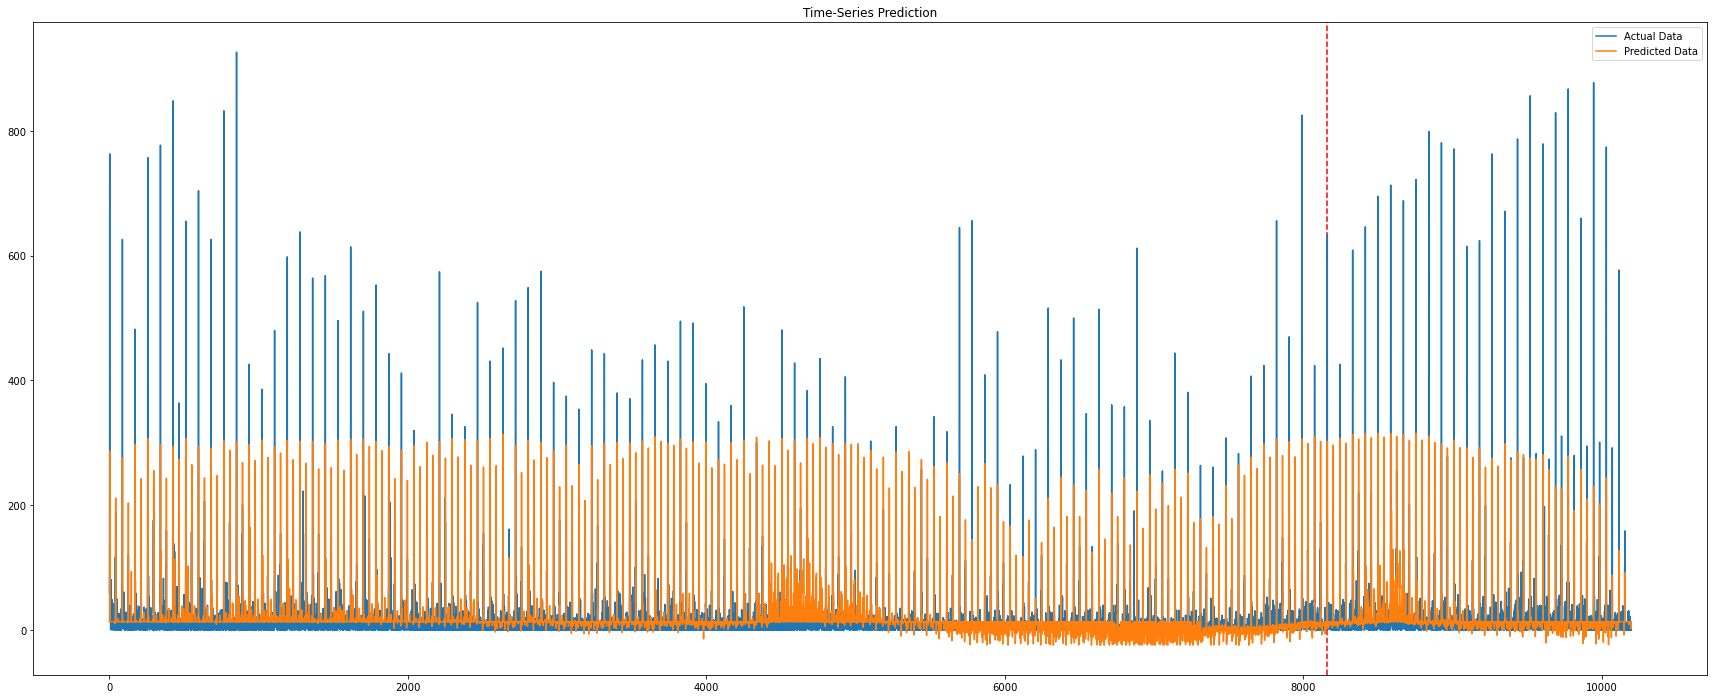

In [34]:
train_predict = model(rawdata_scale_x)
predicted = train_predict.data.numpy()
label_y = rawdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [35]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test1_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':predicted.reshape(-1)})
pred_df

real        pred
0      35.0   13.525448
1      34.0   13.525448
2     633.0  302.873688
3      34.0   13.525448
4      23.0   13.525448
...     ...         ...
2035    0.0   10.518616
2036    0.0    8.543623
2037    8.0    2.500315
2038    1.0   13.525448
2039    0.0   13.525448

[2040 rows x 2 columns]

In [38]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
# MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])   # nagative 값으로 인해 출력 불가
# RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, score: {score}, corr: {corr}')

MSE: 2996.927519479193, RMSE: 54.74420078400262, score: 59.37209297554607, corr: 0.8097062045168628


## GRU 모델

In [39]:
seed_all(seed=42)

Using Seed Number 42


In [40]:
# train, test set 분리
train_data2 = rawdata.iloc[:8160, :].reset_index(drop=True)
test_data2 = rawdata.iloc[8160:, :].reset_index(drop=True)
print(train_data2.shape, test_data2.shape)

(8160, 12) (2040, 12)


In [41]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data2[object_columns])
train_cat = oe.transform(train_data2[object_columns])
test_cat = oe.transform(test_data2[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data2 = pd.concat([train_data2, train_cat_df], axis=1)
test_data2 = pd.concat([test_data2, test_cat_df], axis=1)

In [42]:
train_data2.drop(object_columns, axis=1, inplace=True)
test_data2.drop(object_columns, axis=1, inplace=True)

In [43]:
# 날짜 컬럼을 인덱스로 사용
train_data2.set_index('date', inplace=True)
test_data2.set_index('date', inplace=True)

In [44]:
# 독립변수, 종속변수 분리
train2_x = train_data2.drop('job_offer', axis=1)
train2_y = train_data2[['job_offer']]

test2_x = test_data2.drop('job_offer', axis=1)
test2_y = test_data2[['job_offer']]

print(train2_x.shape, train2_y.shape, test2_x.shape, test2_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [45]:
train2_x.iloc[:, :8]

employment  no_company  unemployment  population     GDP  i_rate  \
date                                                                           
2013-01-01         0.0     30219.0          97.0  10195064.0  1562.7    2.75   
2013-01-01         0.0    109382.0         202.0  10195064.0  1562.7    2.75   
2013-01-01         4.0     23384.0        1230.0  10195064.0  1562.7    2.75   
2013-01-01         1.0     33649.0          70.0  10195064.0  1562.7    2.75   
2013-01-01         0.0     11578.0          62.0  10195064.0  1562.7    2.75   
...                ...         ...           ...         ...     ...     ...   
2020-12-01         0.0      1955.0           1.0    674635.0  1839.5    0.50   
2020-12-01         0.0      6551.0           3.0    674635.0  1839.5    0.50   
2020-12-01         0.0       428.0          16.0    674635.0  1839.5    0.50   
2020-12-01         0.0      1337.0           3.0    674635.0  1839.5    0.50   
2020-12-01         0.0      1282.0           2.0    674635.0  1839.5    0.50   

                  CLI    CFI  
date                          
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
...               ...    ...  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  

[8160 rows x 8 columns]

In [46]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train2_x[scale_columns]
test_scale = test2_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train2_y)
train1_y = ms.transform(train2_y)
ss.fit(train_scale)
train2_x[scale_columns] = ss.transform(train_scale)

test2_x[scale_columns] = ss.transform(test_scale)
test2_y = ms.transform(test2_y)

In [47]:
train2_x_tensors = Variable(torch.Tensor(train2_x.values))
test2_x_tensors = Variable(torch.Tensor(test2_x.values))

train2_y_tensors = Variable(torch.Tensor(train2_y.values))
test2_y_tensors = Variable(torch.Tensor(test2_y))

train2_x_tensors.shape, test2_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [48]:
train2_x_tensors_f = torch.reshape(train1_x_tensors, (train2_x_tensors.shape[0], 1, train2_x_tensors.shape[1]))
test2_x_tensors_f = torch.reshape(test1_x_tensors, (test2_x_tensors.shape[0], 1, test2_x_tensors.shape[1]))

print(train2_x_tensors_f.shape, test2_y_tensors.shape, test2_x_tensors_f.shape, test2_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [49]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [50]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.0001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # GRU 계층의 개수

num_classes = 1 # 클래스 개수
model = GRU(num_classes, input_size, hidden_size, num_layers, train1_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train2_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train2_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 3460.962158203125
Epoch: 100, loss: 3451.505615234375
Epoch: 200, loss: 3442.223876953125
Epoch: 300, loss: 3432.8740234375
Epoch: 400, loss: 3423.29638671875
Epoch: 500, loss: 3413.460205078125
Epoch: 600, loss: 3403.291015625
Epoch: 700, loss: 3392.65771484375
Epoch: 800, loss: 3381.574462890625
Epoch: 900, loss: 3370.1298828125


In [52]:
rawdata_scale2 = rawdata.copy()

In [53]:
rawdata_scale2

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업       60.0         0.0   
1     2013-01-01   서울                  도매 및 소매업      104.0         0.0   
2     2013-01-01   서울                     정보통신업      763.0         4.0   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업       35.0         1.0   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업       64.0         0.0   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업        0.0         0.0   
10196 2022-12-01   제주                  도매 및 소매업        0.0         0.0   
10197 2022-12-01   제주                     정보통신업        8.0         0.0   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업        1.0         0.0   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업        0.0         0.0   

       no_company  unemployment  population     GDP  i_rate       CLI    CFI  
0         30219.0          97.0  10195064.0  1562.7    2.75  99.14964  101.0  
1        109382.0         202.0  10195064.0  1562.7    2.75  99.14964  101.0  
2         23384.0        1230.0  10195064.0  1562.7    2.75  99.14964  101.0  
3         33649.0          70.0  10195064.0  1562.7    2.75  99.14964  101.0  
4         11578.0          62.0  10195064.0  1562.7    2.75  99.14964  101.0  
...           ...           ...         ...     ...     ...       ...    ...  
10195      2134.0           2.0    678159.0  1968.8    3.25  98.75089   90.2  
10196      7385.0           6.0    678159.0  1968.8    3.25  98.75089   90.2  
10197       559.0          23.0    678159.0  1968.8    3.25  98.75089   90.2  
10198      1561.0           4.0    678159.0  1968.8    3.25  98.75089   90.2  
10199      1448.0           8.0    678159.0  1968.8    3.25  98.75089   90.2  

[10200 rows x 12 columns]

In [54]:
object_columns = ['city', 'industry']

raw_cat = oe.transform(rawdata_scale2[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
raw_cat_df = pd.DataFrame(raw_cat, columns=column_name)
raw_cat_df
rawdata_scale2 = pd.concat([rawdata_scale2, raw_cat_df], axis=1)
rawdata_scale2.drop(object_columns, axis=1, inplace=True)

In [55]:
rawdata_scale2.set_index('date', inplace=True)
rawdata_scale2

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01       60.0         0.0     30219.0          97.0  10195064.0   
2013-01-01      104.0         0.0    109382.0         202.0  10195064.0   
2013-01-01      763.0         4.0     23384.0        1230.0  10195064.0   
2013-01-01       35.0         1.0     33649.0          70.0  10195064.0   
2013-01-01       64.0         0.0     11578.0          62.0  10195064.0   
...               ...         ...         ...           ...         ...   
2022-12-01        0.0         0.0      2134.0           2.0    678159.0   
2022-12-01        0.0         0.0      7385.0           6.0    678159.0   
2022-12-01        8.0         0.0       559.0          23.0    678159.0   
2022-12-01        1.0         0.0      1561.0           4.0    678159.0   
2022-12-01        0.0         0.0      1448.0           8.0    678159.0   

               GDP  i_rate       CLI    CFI   경기  ...   인천   전남   전북   제주  \
date                                              ...                       
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
...            ...     ...       ...    ...  ...  ...  ...  ...  ...  ...   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   

             충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
date                                                                          
2013-01-01  0.0  0.0                       0.0               0.0    0.0  1.0  
2013-01-01  0.0  0.0                       0.0               0.0    0.0  0.0  
2013-01-01  0.0  0.0                       0.0               0.0    1.0  0.0  
2013-01-01  0.0  0.0                       0.0               1.0    0.0  0.0  
2013-01-01  0.0  0.0                       1.0               0.0    0.0  0.0  
...         ...  ...                       ...               ...    ...  ...  
2022-12-01  0.0  0.0                       0.0               0.0    0.0  1.0  
2022-12-01  0.0  0.0                       0.0               0.0    0.0  0.0  
2022-12-01  0.0  0.0                       0.0               0.0    1.0  0.0  
2022-12-01  0.0  0.0                       0.0               1.0    0.0  0.0  
2022-12-01  0.0  0.0                       1.0               0.0    0.0  0.0  

[10200 rows x 29 columns]

In [56]:
rawdata_scale2.iloc[:, 1:9]

employment  no_company  unemployment  population     GDP  i_rate  \
date                                                                           
2013-01-01         0.0     30219.0          97.0  10195064.0  1562.7    2.75   
2013-01-01         0.0    109382.0         202.0  10195064.0  1562.7    2.75   
2013-01-01         4.0     23384.0        1230.0  10195064.0  1562.7    2.75   
2013-01-01         1.0     33649.0          70.0  10195064.0  1562.7    2.75   
2013-01-01         0.0     11578.0          62.0  10195064.0  1562.7    2.75   
...                ...         ...           ...         ...     ...     ...   
2022-12-01         0.0      2134.0           2.0    678159.0  1968.8    3.25   
2022-12-01         0.0      7385.0           6.0    678159.0  1968.8    3.25   
2022-12-01         0.0       559.0          23.0    678159.0  1968.8    3.25   
2022-12-01         0.0      1561.0           4.0    678159.0  1968.8    3.25   
2022-12-01         0.0      1448.0           8.0    678159.0  1968.8    3.25   

                 CLI    CFI  
date                         
2013-01-01  99.14964  101.0  
2013-01-01  99.14964  101.0  
2013-01-01  99.14964  101.0  
2013-01-01  99.14964  101.0  
2013-01-01  99.14964  101.0  
...              ...    ...  
2022-12-01  98.75089   90.2  
2022-12-01  98.75089   90.2  
2022-12-01  98.75089   90.2  
2022-12-01  98.75089   90.2  
2022-12-01  98.75089   90.2  

[10200 rows x 8 columns]

In [57]:
# 모델 예측 결과 출력
rawdata_scale2.iloc[:, 1:9] = ss.transform(rawdata_scale2.iloc[:, 1:9])
rawdata_scale2['job_offer'] = ms.transform(rawdata_scale2[['job_offer']])

In [58]:
rawdata_scale2.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.064795   -0.290460    0.884888      0.304127    2.248617   
2013-01-01   0.112311   -0.290460    4.537431      0.951316    2.248617   
2013-01-01   0.823974    1.737044    0.569524      7.287598    2.248617   
2013-01-01   0.037797    0.216416    1.043146      0.137707    2.248617   
2013-01-01   0.069114   -0.290460    0.024801      0.088398    2.248617   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [59]:
rawdata_scale_x = rawdata_scale2.drop('job_offer', axis=1)
rawdata_scale_y = rawdata_scale2[['job_offer']]

rawdata_scale_x = Variable(torch.Tensor(rawdata_scale_x.values))
rawdata_scale_y = Variable(torch.Tensor(rawdata_scale_y.values))

rawdata_scale_x = torch.reshape(rawdata_scale_x, (rawdata_scale_x.shape[0], 1, rawdata_scale_x.shape[1]))

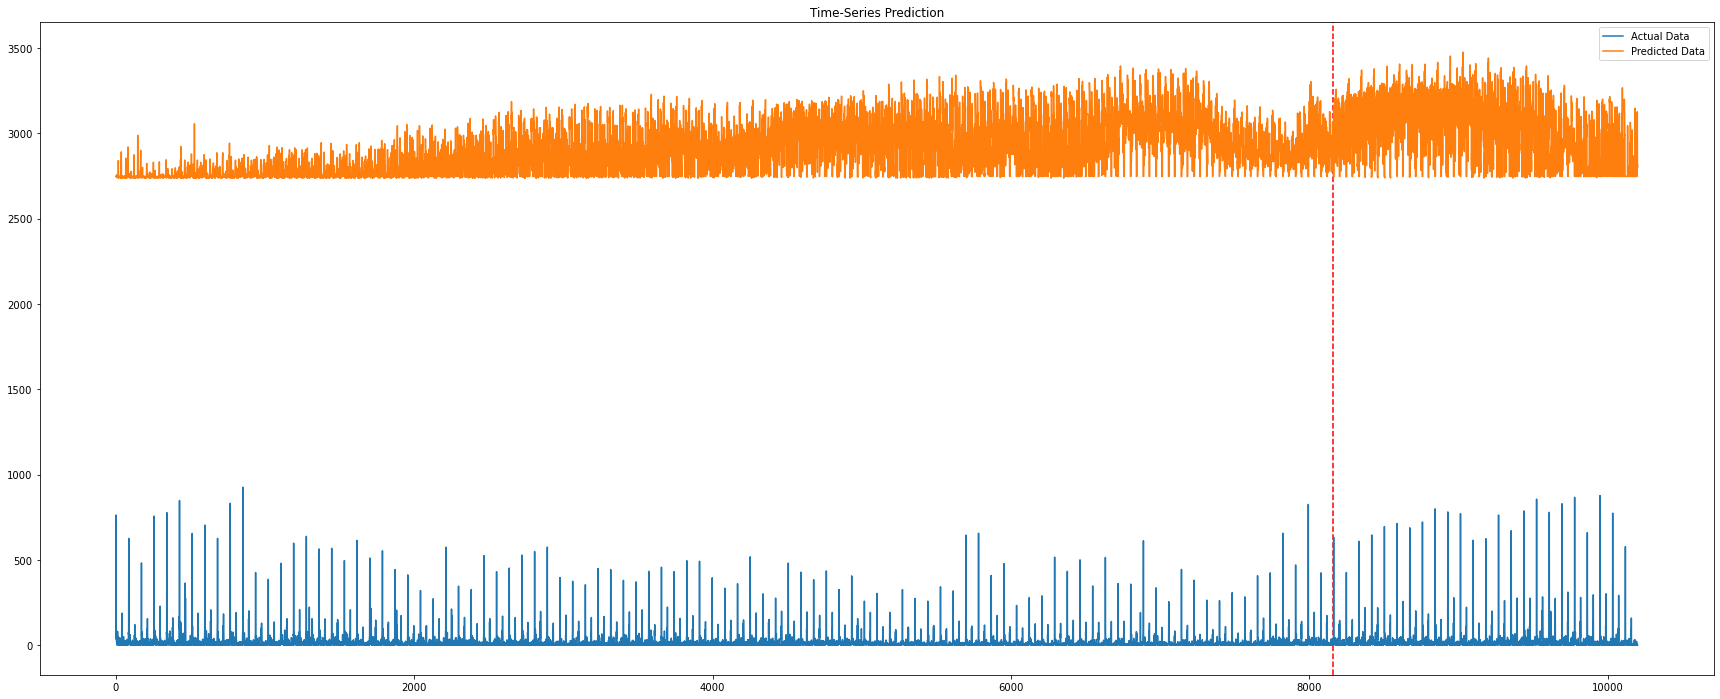

In [60]:
train_predict = model(rawdata_scale_x)
predicted = train_predict.data.numpy()
label_y = rawdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [61]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test2_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':predicted.reshape(-1)})
pred_df

real         pred
0      35.0  2748.364746
1      34.0  2748.364746
2     633.0  2745.753174
3      34.0  2748.364746
4      23.0  2748.364746
...     ...          ...
2035    0.0  3118.567139
2036    0.0  3057.747559
2037    8.0  3127.144287
2038    1.0  2797.608154
2039    0.0  2812.383057

[2040 rows x 2 columns]

In [62]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 8874244.56486608, RMSE: 2978.9670298387127, MSLE: 38.856574311229124, RMSLE: 6.233504175921367, corr: -0.24475908455297873, score: -120203.87146509963


## 양방향 LSTM

In [100]:
seed_all(seed=42)

Using Seed Number 42


In [101]:
# train, test set 분리
train_data1 = rawdata.iloc[:8160, :].reset_index(drop=True)
test_data1 = rawdata.iloc[8160:, :].reset_index(drop=True)
print(train_data1.shape, test_data1.shape)

(8160, 12) (2040, 12)


In [102]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data1[object_columns])
train_cat = oe.transform(train_data1[object_columns])
test_cat = oe.transform(test_data1[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data1 = pd.concat([train_data1, train_cat_df], axis=1)
test_data1 = pd.concat([test_data1, test_cat_df], axis=1)

In [103]:
train_data1.drop(object_columns, axis=1, inplace=True)
test_data1.drop(object_columns, axis=1, inplace=True)

In [104]:
display(train_data1, test_data1)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01       60.0         0.0     30219.0          97.0  10195064.0   
1    2013-01-01      104.0         0.0    109382.0         202.0  10195064.0   
2    2013-01-01      763.0         4.0     23384.0        1230.0  10195064.0   
3    2013-01-01       35.0         1.0     33649.0          70.0  10195064.0   
4    2013-01-01       64.0         0.0     11578.0          62.0  10195064.0   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01       37.0         0.0      1955.0           1.0    674635.0   
8156 2020-12-01        0.0         0.0      6551.0           3.0    674635.0   
8157 2020-12-01        6.0         0.0       428.0          16.0    674635.0   
8158 2020-12-01        0.0         0.0      1337.0           3.0    674635.0   
8159 2020-12-01        4.0         0.0      1282.0           2.0    674635.0   

         GDP  i_rate        CLI    CFI  ...   인천   전남   전북   제주   충남   충북  \
0     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
1     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
2     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
3     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
4     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
...      ...     ...        ...    ...  ...  ...  ...  ...  ...  ...  ...   
8155  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8156  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8157  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8158  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8159  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   

      사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0                          0.0               0.0    0.0  1.0  
1                          0.0               0.0    0.0  0.0  
2                          0.0               0.0    1.0  0.0  
3                          0.0               1.0    0.0  0.0  
4                          1.0               0.0    0.0  0.0  
...                        ...               ...    ...  ...  
8155                       0.0               0.0    0.0  1.0  
8156                       0.0               0.0    0.0  0.0  
8157                       0.0               0.0    1.0  0.0  
8158                       0.0               1.0    0.0  0.0  
8159                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01       35.0         2.0     32388.0         115.0   9657969.0   
1    2021-01-01       34.0         0.0    131425.0         167.0   9657969.0   
2    2021-01-01      633.0         7.0     32604.0        1431.0   9657969.0   
3    2021-01-01       34.0         1.0     48282.0         122.0   9657969.0   
4    2021-01-01       23.0         1.0     18711.0         104.0   9657969.0   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01        0.0         0.0      2134.0           2.0    678159.0   
2036 2022-12-01        0.0         0.0      7385.0           6.0    678159.0   
2037 2022-12-01        8.0         0.0       559.0          23.0    678159.0   
2038 2022-12-01        1.0         0.0      1561.0           4.0    678159.0   
2039 2022-12-01        0.0         0.0      1448.0           8.0    678159.0   

         GDP  i_rate        CLI   CFI  ...   인천   전남   전북   제주   충남   충북  \
0     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
1     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
2     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
3     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
4     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
...      ...     ...        ...   ...  ...  ...  ...  ...  ...  ...  ...   
2035  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2036  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2037  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2038  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2039  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   

      사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0                          0.0               0.0    0.0  1.0  
1                          0.0               0.0    0.0  0.0  
2                          0.0               0.0    1.0  0.0  
3                          0.0               1.0    0.0  0.0  
4                          1.0               0.0    0.0  0.0  
...                        ...               ...    ...  ...  
2035                       0.0               0.0    0.0  1.0  
2036                       0.0               0.0    0.0  0.0  
2037                       0.0               0.0    1.0  0.0  
2038                       0.0               1.0    0.0  0.0  
2039                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [105]:
# 날짜 컬럼을 인덱스로 사용
train_data1.set_index('date', inplace=True)
test_data1.set_index('date', inplace=True)

In [106]:
# 독립변수, 종속변수 분리
train1_x = train_data1.drop('job_offer', axis=1)
train1_y = train_data1[['job_offer']]

test1_x = test_data1.drop('job_offer', axis=1)
test1_y = test_data1[['job_offer']]

print(train1_x.shape, train1_y.shape, test1_x.shape, test1_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [107]:
train1_x.iloc[:, :8]

employment  no_company  unemployment  population     GDP  i_rate  \
date                                                                           
2013-01-01         0.0     30219.0          97.0  10195064.0  1562.7    2.75   
2013-01-01         0.0    109382.0         202.0  10195064.0  1562.7    2.75   
2013-01-01         4.0     23384.0        1230.0  10195064.0  1562.7    2.75   
2013-01-01         1.0     33649.0          70.0  10195064.0  1562.7    2.75   
2013-01-01         0.0     11578.0          62.0  10195064.0  1562.7    2.75   
...                ...         ...           ...         ...     ...     ...   
2020-12-01         0.0      1955.0           1.0    674635.0  1839.5    0.50   
2020-12-01         0.0      6551.0           3.0    674635.0  1839.5    0.50   
2020-12-01         0.0       428.0          16.0    674635.0  1839.5    0.50   
2020-12-01         0.0      1337.0           3.0    674635.0  1839.5    0.50   
2020-12-01         0.0      1282.0           2.0    674635.0  1839.5    0.50   

                  CLI    CFI  
date                          
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
...               ...    ...  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  

[8160 rows x 8 columns]

In [108]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train1_x[scale_columns]
test_scale = test1_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train1_y)
train1_y = ms.transform(train1_y)
ss.fit(train_scale)
train1_x[scale_columns] = ss.transform(train_scale)

test1_x[scale_columns] = ss.transform(test_scale)
test1_y = ms.transform(test1_y)

In [109]:
train1_x_tensors = Variable(torch.Tensor(train1_x.values))
test1_x_tensors = Variable(torch.Tensor(test1_x.values))

train1_y_tensors = Variable(torch.Tensor(train1_y))
test1_y_tensors = Variable(torch.Tensor(test1_y))

train1_x_tensors.shape, test1_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [110]:
train1_x_tensors_f = torch.reshape(train1_x_tensors, (train1_x_tensors.shape[0], 1, train1_x_tensors.shape[1]))
test1_x_tensors_f = torch.reshape(test1_x_tensors, (test1_x_tensors.shape[0], 1, test1_x_tensors.shape[1]))

print(train1_x_tensors_f.shape, test1_y_tensors.shape, test1_x_tensors_f.shape, test1_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [111]:
class biLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biLSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)    # LSTM 계층
        self.fc = nn.Linear(hidden_size*2, 128) # 완전 연결층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        out, _ = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        out = self.fc(out[:, -1, :])    # 마지막 시간(time step상 마지막 단계)의 은닉 상태
        out = self.relu(out)
        return out

In [112]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.0001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = biLSTM(num_classes, input_size, hidden_size, num_layers, train1_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [113]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train1_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train1_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([8160, 1])) that is different to the input size (torch.Size([8160, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 0.04980020597577095
Epoch: 100, loss: 0.046229586005210876
Epoch: 200, loss: 0.04293634369969368
Epoch: 300, loss: 0.039813246577978134
Epoch: 400, loss: 0.036825671792030334
Epoch: 500, loss: 0.03395897522568703
Epoch: 600, loss: 0.0312028881162405
Epoch: 700, loss: 0.028547069057822227
Epoch: 800, loss: 0.025986623018980026
Epoch: 900, loss: 0.0235267486423254


In [114]:
rawdata_scale = rawdata.copy()

In [115]:
rawdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업       60.0         0.0   
1     2013-01-01   서울                  도매 및 소매업      104.0         0.0   
2     2013-01-01   서울                     정보통신업      763.0         4.0   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업       35.0         1.0   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업       64.0         0.0   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업        0.0         0.0   
10196 2022-12-01   제주                  도매 및 소매업        0.0         0.0   
10197 2022-12-01   제주                     정보통신업        8.0         0.0   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업        1.0         0.0   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업        0.0         0.0   

       no_company  unemployment  population     GDP  i_rate       CLI    CFI  
0         30219.0          97.0  10195064.0  1562.7    2.75  99.14964  101.0  
1        109382.0         202.0  10195064.0  1562.7    2.75  99.14964  101.0  
2         23384.0        1230.0  10195064.0  1562.7    2.75  99.14964  101.0  
3         33649.0          70.0  10195064.0  1562.7    2.75  99.14964  101.0  
4         11578.0          62.0  10195064.0  1562.7    2.75  99.14964  101.0  
...           ...           ...         ...     ...     ...       ...    ...  
10195      2134.0           2.0    678159.0  1968.8    3.25  98.75089   90.2  
10196      7385.0           6.0    678159.0  1968.8    3.25  98.75089   90.2  
10197       559.0          23.0    678159.0  1968.8    3.25  98.75089   90.2  
10198      1561.0           4.0    678159.0  1968.8    3.25  98.75089   90.2  
10199      1448.0           8.0    678159.0  1968.8    3.25  98.75089   90.2  

[10200 rows x 12 columns]

In [116]:
object_columns = ['city', 'industry']

raw_cat = oe.transform(rawdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
raw_cat_df = pd.DataFrame(raw_cat, columns=column_name)
raw_cat_df
rawdata_scale = pd.concat([rawdata_scale, raw_cat_df], axis=1)
rawdata_scale.drop(object_columns, axis=1, inplace=True)

In [117]:
rawdata_scale.set_index('date', inplace=True)
rawdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01       60.0         0.0     30219.0          97.0  10195064.0   
2013-01-01      104.0         0.0    109382.0         202.0  10195064.0   
2013-01-01      763.0         4.0     23384.0        1230.0  10195064.0   
2013-01-01       35.0         1.0     33649.0          70.0  10195064.0   
2013-01-01       64.0         0.0     11578.0          62.0  10195064.0   
...               ...         ...         ...           ...         ...   
2022-12-01        0.0         0.0      2134.0           2.0    678159.0   
2022-12-01        0.0         0.0      7385.0           6.0    678159.0   
2022-12-01        8.0         0.0       559.0          23.0    678159.0   
2022-12-01        1.0         0.0      1561.0           4.0    678159.0   
2022-12-01        0.0         0.0      1448.0           8.0    678159.0   

               GDP  i_rate       CLI    CFI   경기  ...   인천   전남   전북   제주  \
date                                              ...                       
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
2013-01-01  1562.7    2.75  99.14964  101.0  0.0  ...  0.0  0.0  0.0  0.0   
...            ...     ...       ...    ...  ...  ...  ...  ...  ...  ...   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   
2022-12-01  1968.8    3.25  98.75089   90.2  0.0  ...  0.0  0.0  0.0  1.0   

             충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
date                                                                          
2013-01-01  0.0  0.0                       0.0               0.0    0.0  1.0  
2013-01-01  0.0  0.0                       0.0               0.0    0.0  0.0  
2013-01-01  0.0  0.0                       0.0               0.0    1.0  0.0  
2013-01-01  0.0  0.0                       0.0               1.0    0.0  0.0  
2013-01-01  0.0  0.0                       1.0               0.0    0.0  0.0  
...         ...  ...                       ...               ...    ...  ...  
2022-12-01  0.0  0.0                       0.0               0.0    0.0  1.0  
2022-12-01  0.0  0.0                       0.0               0.0    0.0  0.0  
2022-12-01  0.0  0.0                       0.0               0.0    1.0  0.0  
2022-12-01  0.0  0.0                       0.0               1.0    0.0  0.0  
2022-12-01  0.0  0.0                       1.0               0.0    0.0  0.0  

[10200 rows x 29 columns]

In [118]:
rawdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population     GDP  i_rate  \
date                                                                           
2013-01-01         0.0     30219.0          97.0  10195064.0  1562.7    2.75   
2013-01-01         0.0    109382.0         202.0  10195064.0  1562.7    2.75   
2013-01-01         4.0     23384.0        1230.0  10195064.0  1562.7    2.75   
2013-01-01         1.0     33649.0          70.0  10195064.0  1562.7    2.75   
2013-01-01         0.0     11578.0          62.0  10195064.0  1562.7    2.75   
...                ...         ...           ...         ...     ...     ...   
2022-12-01         0.0      2134.0           2.0    678159.0  1968.8    3.25   
2022-12-01         0.0      7385.0           6.0    678159.0  1968.8    3.25   
2022-12-01         0.0       559.0          23.0    678159.0  1968.8    3.25   
2022-12-01         0.0      1561.0           4.0    678159.0  1968.8    3.25   
2022-12-01         0.0      1448.0           8.0    678159.0  1968.8    3.25   

                 CLI    CFI  
date                         
2013-01-01  99.14964  101.0  
2013-01-01  99.14964  101.0  
2013-01-01  99.14964  101.0  
2013-01-01  99.14964  101.0  
2013-01-01  99.14964  101.0  
...              ...    ...  
2022-12-01  98.75089   90.2  
2022-12-01  98.75089   90.2  
2022-12-01  98.75089   90.2  
2022-12-01  98.75089   90.2  
2022-12-01  98.75089   90.2  

[10200 rows x 8 columns]

In [119]:
# 모델 예측 결과 출력
rawdata_scale.iloc[:, 1:9] = ss.transform(rawdata_scale.iloc[:, 1:9])
rawdata_scale['job_offer'] = ms.transform(rawdata_scale[['job_offer']])

In [120]:
rawdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.064795   -0.290460    0.884888      0.304127    2.248617   
2013-01-01   0.112311   -0.290460    4.537431      0.951316    2.248617   
2013-01-01   0.823974    1.737044    0.569524      7.287598    2.248617   
2013-01-01   0.037797    0.216416    1.043146      0.137707    2.248617   
2013-01-01   0.069114   -0.290460    0.024801      0.088398    2.248617   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.609297  1.873833 -1.039587  0.000148  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [121]:
rawdata_scale_x = rawdata_scale.drop('job_offer', axis=1)
rawdata_scale_y = rawdata_scale[['job_offer']]

rawdata_scale_x = Variable(torch.Tensor(rawdata_scale_x.values))
rawdata_scale_y = Variable(torch.Tensor(rawdata_scale_y.values))

rawdata_scale_x = torch.reshape(rawdata_scale_x, (rawdata_scale_x.shape[0], 1, rawdata_scale_x.shape[1]))

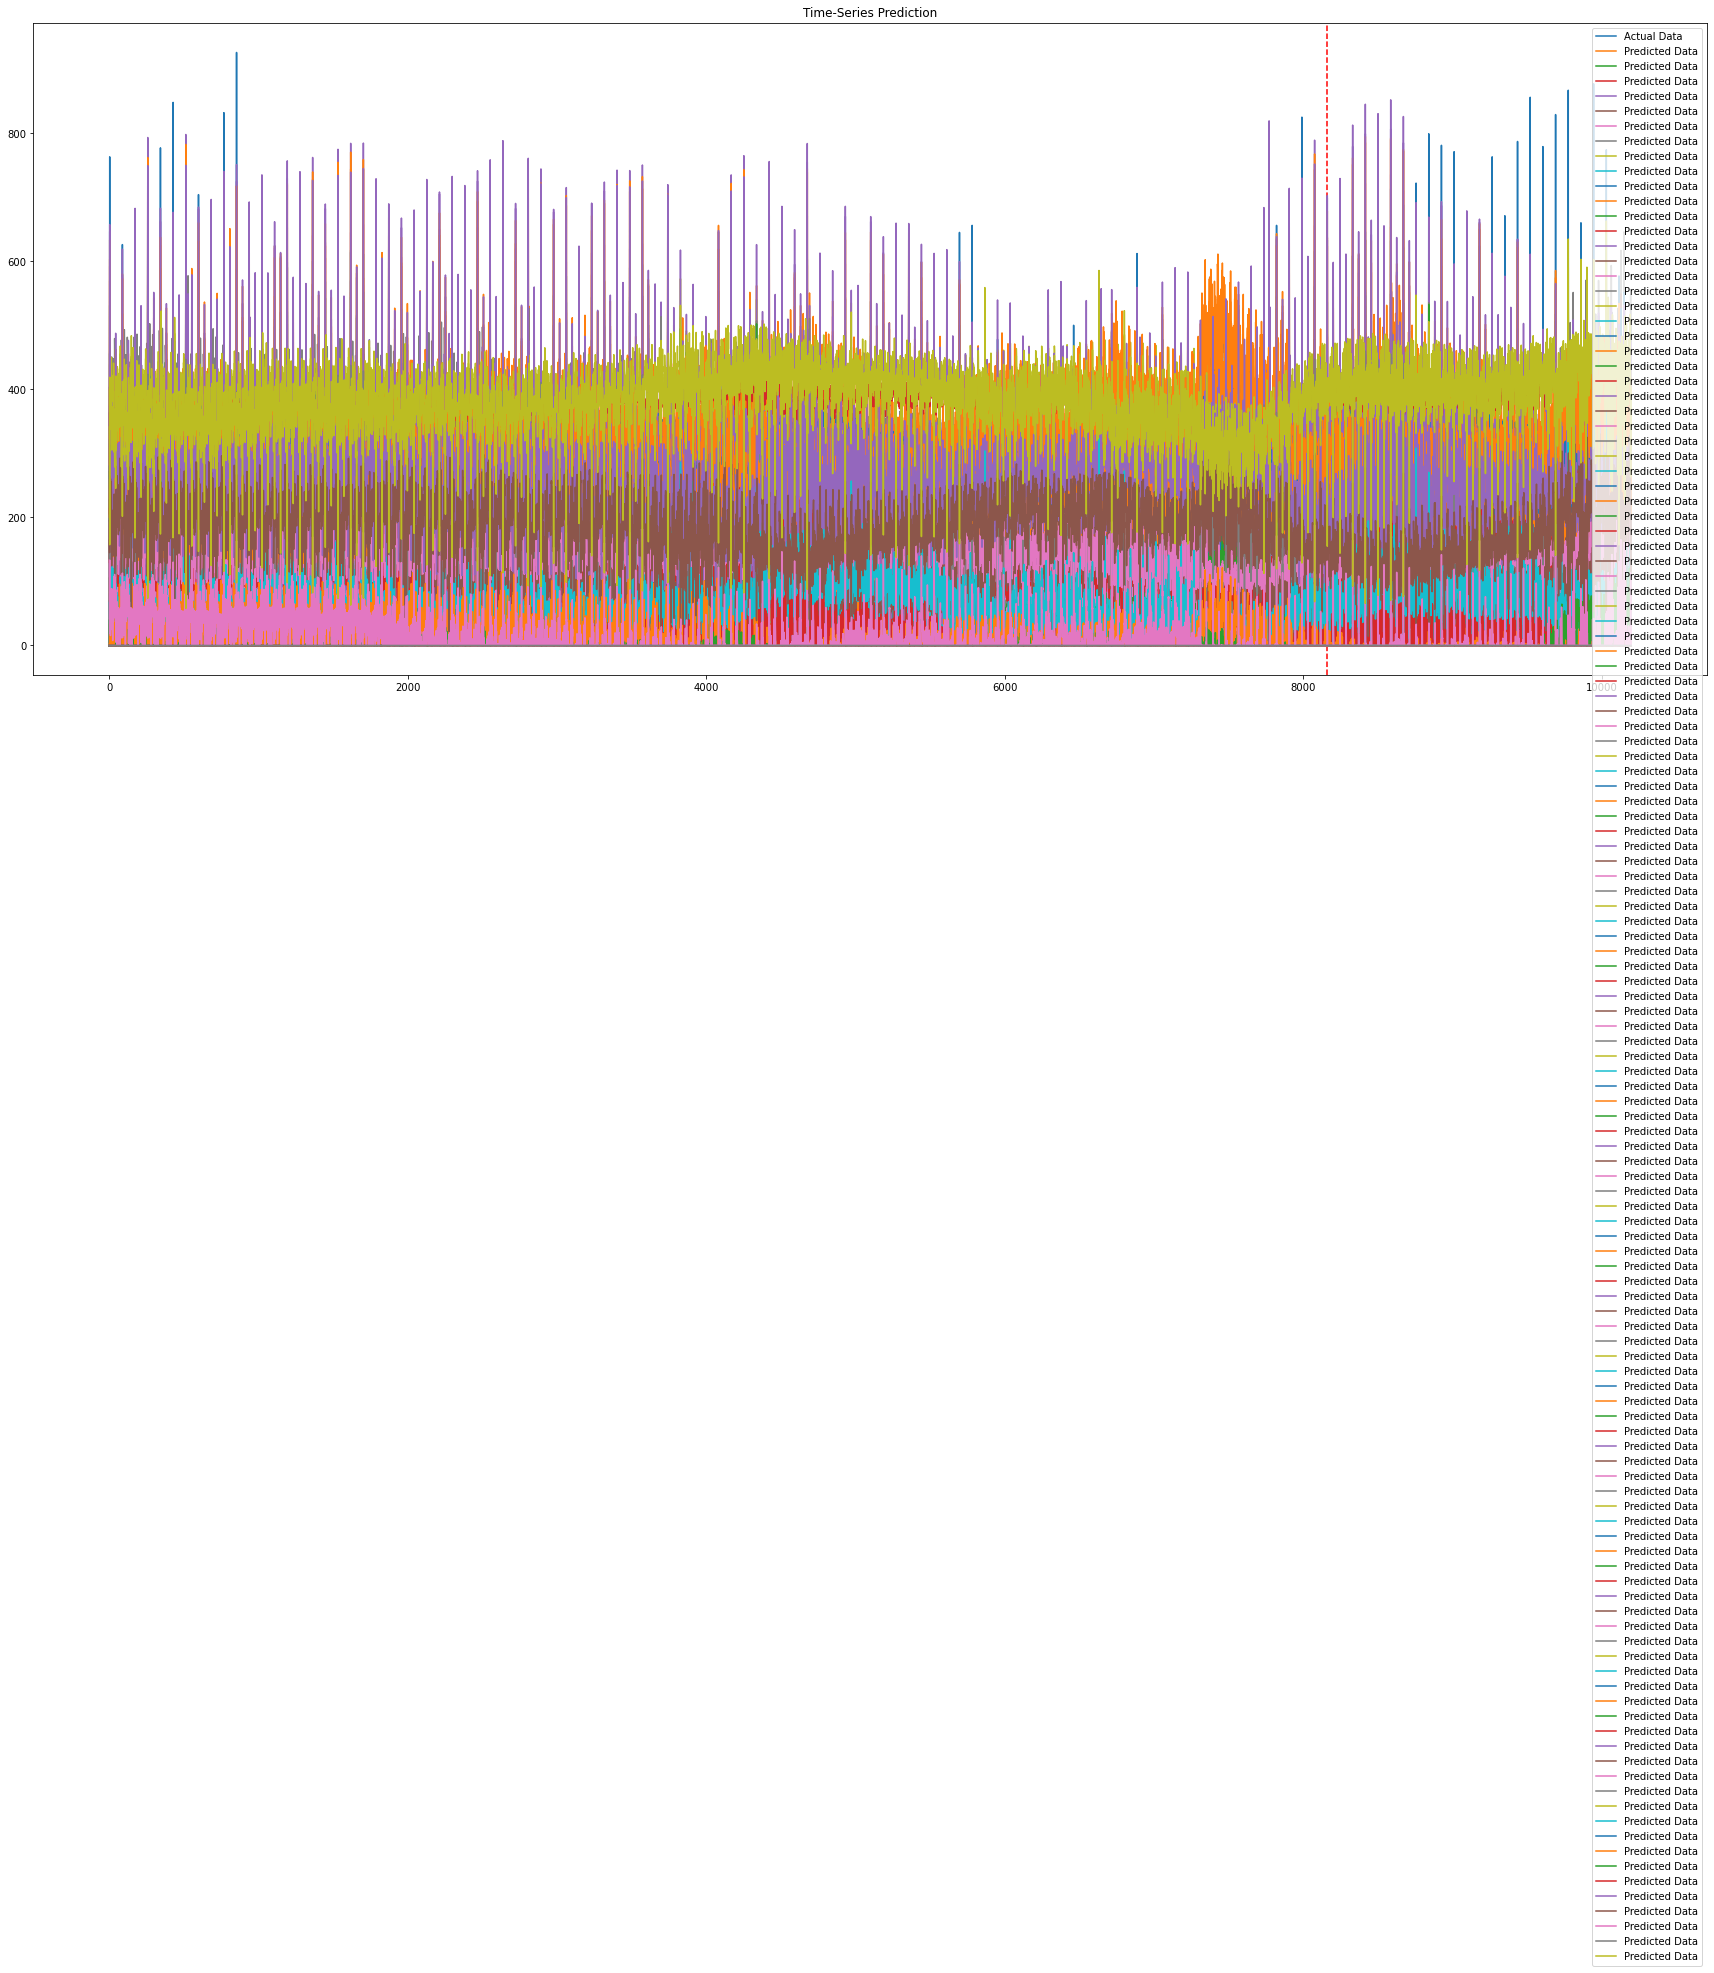

In [122]:
train_predict = model(rawdata_scale_x)
predicted = train_predict.data.numpy()
label_y = rawdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [123]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test1_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':predicted.reshape(-1)})
pred_df

ValueError: array length 261120 does not match index length 2040

In [ ]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, score: {score}')

## LSTM 모델(log 적용)

In [112]:
seed_all(seed=42)

Using Seed Number 42


In [136]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [137]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [138]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [139]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [140]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [141]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [142]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [143]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [144]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [145]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [146]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [147]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.0001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [148]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.14529003202915192
Epoch: 100, loss: 0.05410311371088028
Epoch: 200, loss: 0.04382997751235962
Epoch: 300, loss: 0.04203144833445549
Epoch: 400, loss: 0.039570339024066925
Epoch: 500, loss: 0.035861123353242874
Epoch: 600, loss: 0.03173721209168434
Epoch: 700, loss: 0.0282466858625412
Epoch: 800, loss: 0.026186348870396614
Epoch: 900, loss: 0.024994520470499992


In [149]:
logdata_scale = log_data.copy()

In [150]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [151]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [152]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [153]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [154]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [155]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [156]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

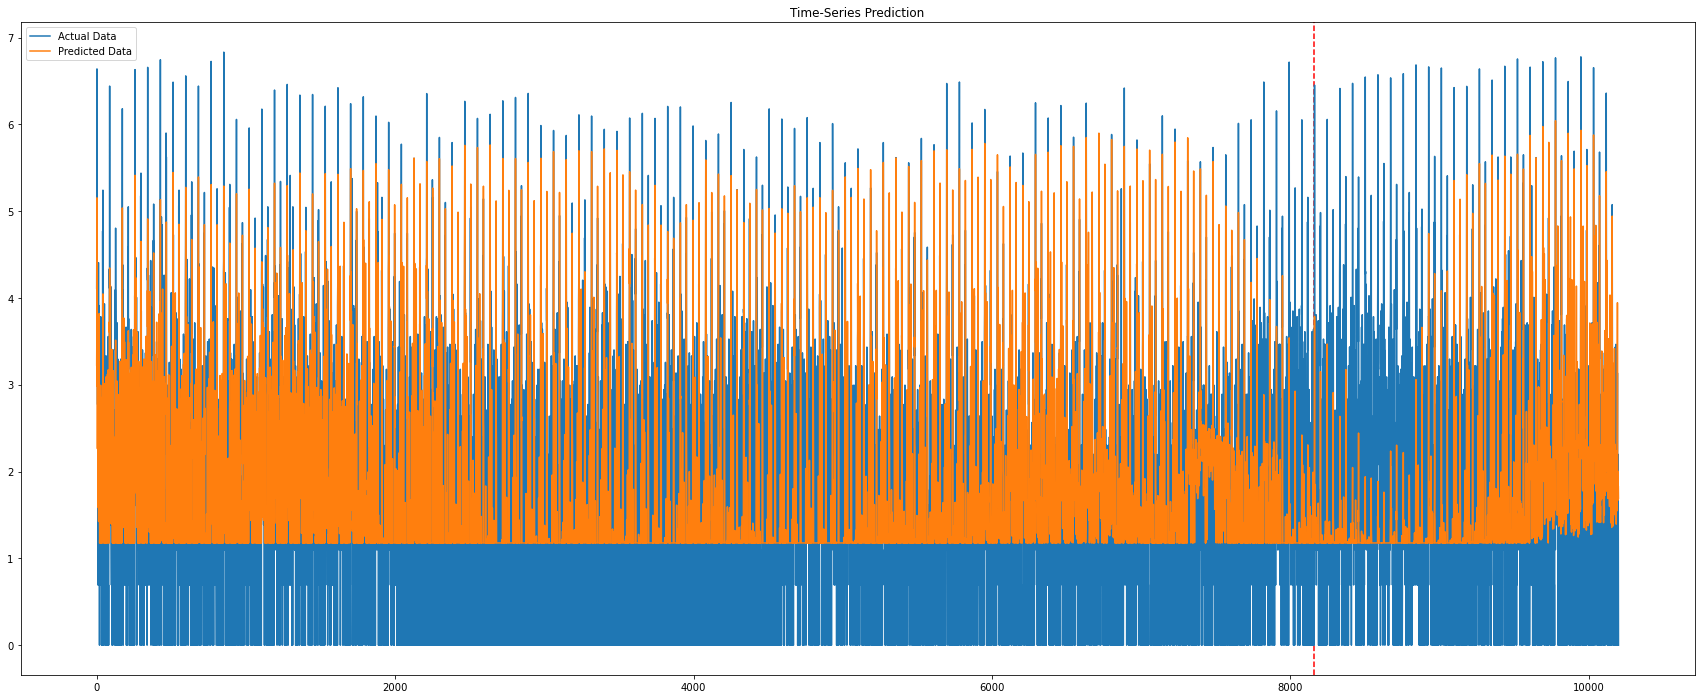

In [157]:
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [160]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real       pred
0      35.0   5.083018
1      34.0   6.068605
2     633.0  43.148220
3      34.0   3.507730
4      23.0   3.455904
...     ...        ...
2035    0.0   4.307981
2036    0.0   6.401926
2037    8.0   5.161231
2038    1.0   5.231529
2039    0.0   4.437186

[2040 rows x 2 columns]

In [161]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 4204.6340854144155, RMSE: 64.84314987270757, MSLE: 1.6466502077859824, RMSLE: 1.2832186905535559, corr: 0.7180076448529019, score: 42.99979509556079


## GRU 모델(log)

In [162]:
seed_all(seed=42)

Using Seed Number 42


In [163]:
# train, test set 분리
train_data5 = rawdata.iloc[:8160, :].reset_index(drop=True)
test_data5 = rawdata.iloc[8160:, :].reset_index(drop=True)
print(train_data5.shape, test_data5.shape)

(8160, 12) (2040, 12)


In [164]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data5[object_columns])
train_cat = oe.transform(train_data5[object_columns])
test_cat = oe.transform(test_data5[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data5 = pd.concat([train_data5, train_cat_df], axis=1)
test_data5 = pd.concat([test_data5, test_cat_df], axis=1)

In [165]:
train_data5.drop(object_columns, axis=1, inplace=True)
test_data5.drop(object_columns, axis=1, inplace=True)

In [166]:
# 날짜 컬럼을 인덱스로 사용
train_data5.set_index('date', inplace=True)
test_data5.set_index('date', inplace=True)

In [167]:
# 독립변수, 종속변수 분리
train5_x = train_data5.drop('job_offer', axis=1)
train5_y = train_data5[['job_offer']]

test5_x = test_data5.drop('job_offer', axis=1)
test5_y = test_data5[['job_offer']]

print(train5_x.shape, train5_y.shape, test5_x.shape, test5_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [168]:
train5_x.iloc[:, :8]

employment  no_company  unemployment  population     GDP  i_rate  \
date                                                                           
2013-01-01         0.0     30219.0          97.0  10195064.0  1562.7    2.75   
2013-01-01         0.0    109382.0         202.0  10195064.0  1562.7    2.75   
2013-01-01         4.0     23384.0        1230.0  10195064.0  1562.7    2.75   
2013-01-01         1.0     33649.0          70.0  10195064.0  1562.7    2.75   
2013-01-01         0.0     11578.0          62.0  10195064.0  1562.7    2.75   
...                ...         ...           ...         ...     ...     ...   
2020-12-01         0.0      1955.0           1.0    674635.0  1839.5    0.50   
2020-12-01         0.0      6551.0           3.0    674635.0  1839.5    0.50   
2020-12-01         0.0       428.0          16.0    674635.0  1839.5    0.50   
2020-12-01         0.0      1337.0           3.0    674635.0  1839.5    0.50   
2020-12-01         0.0      1282.0           2.0    674635.0  1839.5    0.50   

                  CLI    CFI  
date                          
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
...               ...    ...  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  

[8160 rows x 8 columns]

In [169]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train5_x[scale_columns]
test_scale = test5_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train5_y)
train5_y = ms.transform(train5_y)
ss.fit(train_scale)
train5_x[scale_columns] = ss.transform(train_scale)

test5_x[scale_columns] = ss.transform(test_scale)
test5_y = ms.transform(test5_y)

In [170]:
train5_x_tensors = Variable(torch.Tensor(train5_x.values))
test5_x_tensors = Variable(torch.Tensor(test5_x.values))

train5_y_tensors = Variable(torch.Tensor(train5_y))
test5_y_tensors = Variable(torch.Tensor(test5_y))

train5_x_tensors.shape, test5_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [171]:
train5_x_tensors_f = torch.reshape(train5_x_tensors, (train5_x_tensors.shape[0], 1, train5_x_tensors.shape[1]))
test5_x_tensors_f = torch.reshape(test5_x_tensors, (test5_x_tensors.shape[0], 1, test5_x_tensors.shape[1]))

print(train5_x_tensors_f.shape, test5_y_tensors.shape, test5_x_tensors_f.shape, test5_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [172]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [173]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.0001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # GRU 계층의 개수

num_classes = 1 # 클래스 개수
model = GRU(num_classes, input_size, hidden_size, num_layers, train5_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [174]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train5_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train5_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.08700482547283173
Epoch: 100, loss: 0.008638684637844563
Epoch: 200, loss: 0.0037623217795044184
Epoch: 300, loss: 0.003606074256822467
Epoch: 400, loss: 0.00349703268148005
Epoch: 500, loss: 0.003404367482289672
Epoch: 600, loss: 0.003329396015033126
Epoch: 700, loss: 0.0032752782572060823
Epoch: 800, loss: 0.0032382006756961346
Epoch: 900, loss: 0.003211314557120204


In [175]:
logdata_scale = log_data.copy()

In [176]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [177]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [178]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [179]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [180]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [181]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.004439   -0.290460   -0.508927     -0.265491   -0.952578   
2013-01-01   0.005026   -0.290460   -0.508867     -0.261003   -0.952578   
2013-01-01   0.007169    0.525326   -0.508938     -0.249893   -0.952578   
2013-01-01   0.003870    0.060880   -0.508922     -0.267478   -0.952578   
2013-01-01   0.004508   -0.290460   -0.508971     -0.268215   -0.952578   

                  GDP    i_rate        CLI        CFI   경기  ...   인천   전남  \
date                                                        ...             
2013-01-01 -16.968731 -0.549978 -114.82126 -13.660153  0.0  ...  0.0  0.0   
2013-01-01 -16.968731 -0.549978 -114.82126 -13.660153  0.0  ...  0.0  0.0   
2013-01-01 -16.968731 -0.549978 -114.82126 -13.660153  0.0  ...  0.0  0.0   
2013-01-01 -16.968731 -0.549978 -114.82126 -13.660153  0.0  ...  0.0  0.0   
2013-01-01 -16.968731 -0.549978 -114.82126 -13.660153  0.0  ...  0.0  0.0   

             전북   제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  \
date                                                                         
2013-01-01  0.0  0.0  0.0  0.0                       0.0               0.0   
2013-01-01  0.0  0.0  0.0  0.0                       0.0               0.0   
2013-01-01  0.0  0.0  0.0  0.0                       0.0               0.0   
2013-01-01  0.0  0.0  0.0  0.0                       0.0               1.0   
2013-01-01  0.0  0.0  0.0  0.0                       1.0               0.0   

            정보통신업  제조업  
date                    
2013-01-01    0.0  1.0  
2013-01-01    0.0  0.0  
2013-01-01    1.0  0.0  
2013-01-01    0.0  0.0  
2013-01-01    0.0  0.0  

[5 rows x 29 columns]

In [182]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

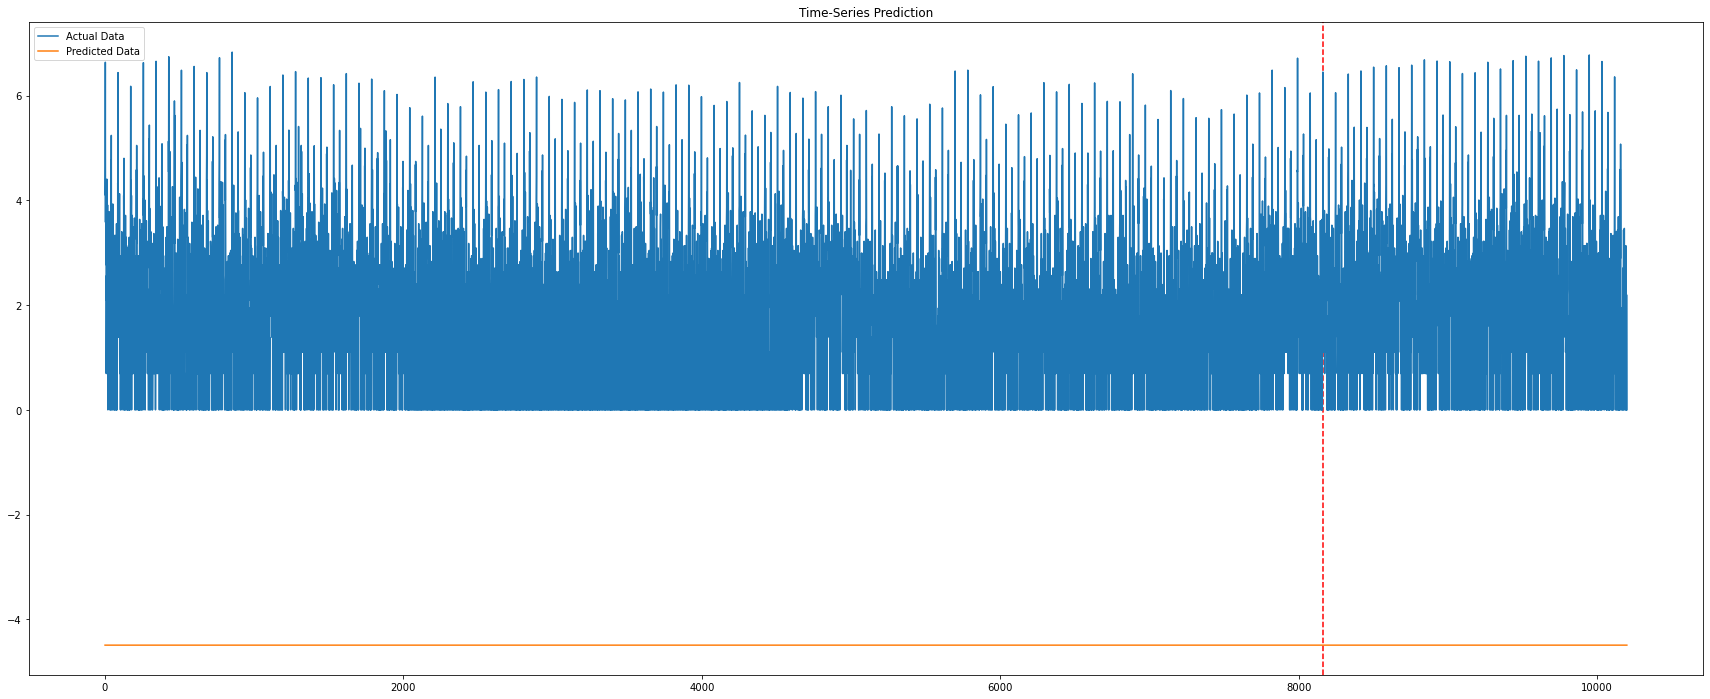

In [183]:
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [184]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test5_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real          pred
0      35.0  2.140657e+24
1      34.0  2.140657e+24
2     633.0  1.648847e+23
3      34.0  2.140657e+24
4      23.0  2.140657e+24
...     ...           ...
2035    0.0 -9.963127e-01
2036    0.0 -7.135417e-01
2037    8.0 -8.200459e-01
2038    1.0  6.174013e+08
2039    0.0  5.789729e+04

[2040 rows x 2 columns]

In [185]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
# MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
# RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 7.933192655360071e+47, RMSE: 8.906847172462359e+23, MSLE: 1.6466502077859824, RMSLE: 1.2832186905535559, corr: 0.23958069932451523, score: -1.0754648269406952e+46


## 양방향 LSTM(log)

In [ ]:
seed_all(seed=42)

Using Seed Number 42


In [ ]:
# train, test set 분리
train_data6 = rawdata.iloc[:8160, :].reset_index(drop=True)
test_data6 = rawdata.iloc[8160:, :].reset_index(drop=True)
print(train_data6.shape, test_data6.shape)

(8160, 12) (2040, 12)


In [ ]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data6[object_columns])
train_cat = oe.transform(train_data6[object_columns])
test_cat = oe.transform(test_data6[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data6 = pd.concat([train_data6, train_cat_df], axis=1)
test_data6 = pd.concat([test_data6, test_cat_df], axis=1)

In [ ]:
train_data6.drop(object_columns, axis=1, inplace=True)
test_data6.drop(object_columns, axis=1, inplace=True)

In [ ]:
display(train_data6, test_data6)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01       60.0         0.0     30219.0          97.0  10195064.0   
1    2013-01-01      104.0         0.0    109382.0         202.0  10195064.0   
2    2013-01-01      763.0         4.0     23384.0        1230.0  10195064.0   
3    2013-01-01       35.0         1.0     33649.0          70.0  10195064.0   
4    2013-01-01       64.0         0.0     11578.0          62.0  10195064.0   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01       37.0         0.0      1955.0           1.0    674635.0   
8156 2020-12-01        0.0         0.0      6551.0           3.0    674635.0   
8157 2020-12-01        6.0         0.0       428.0          16.0    674635.0   
8158 2020-12-01        0.0         0.0      1337.0           3.0    674635.0   
8159 2020-12-01        4.0         0.0      1282.0           2.0    674635.0   

         GDP  i_rate        CLI    CFI  ...   인천   전남   전북   제주   충남   충북  \
0     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
1     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
2     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
3     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
4     1562.7    2.75   99.14964  101.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
...      ...     ...        ...    ...  ...  ...  ...  ...  ...  ...  ...   
8155  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8156  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8157  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8158  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8159  1839.5    0.50  101.65410   91.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   

      사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0                          0.0               0.0    0.0  1.0  
1                          0.0               0.0    0.0  0.0  
2                          0.0               0.0    1.0  0.0  
3                          0.0               1.0    0.0  0.0  
4                          1.0               0.0    0.0  0.0  
...                        ...               ...    ...  ...  
8155                       0.0               0.0    0.0  1.0  
8156                       0.0               0.0    0.0  0.0  
8157                       0.0               0.0    1.0  0.0  
8158                       0.0               1.0    0.0  0.0  
8159                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01       35.0         2.0     32388.0         115.0   9657969.0   
1    2021-01-01       34.0         0.0    131425.0         167.0   9657969.0   
2    2021-01-01      633.0         7.0     32604.0        1431.0   9657969.0   
3    2021-01-01       34.0         1.0     48282.0         122.0   9657969.0   
4    2021-01-01       23.0         1.0     18711.0         104.0   9657969.0   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01        0.0         0.0      2134.0           2.0    678159.0   
2036 2022-12-01        0.0         0.0      7385.0           6.0    678159.0   
2037 2022-12-01        8.0         0.0       559.0          23.0    678159.0   
2038 2022-12-01        1.0         0.0      1561.0           4.0    678159.0   
2039 2022-12-01        0.0         0.0      1448.0           8.0    678159.0   

         GDP  i_rate        CLI   CFI  ...   인천   전남   전북   제주   충남   충북  \
0     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
1     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
2     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
3     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
4     1918.7    0.50  102.02370  95.4  ...  0.0  0.0  0.0  0.0  0.0  0.0   
...      ...     ...        ...   ...  ...  ...  ...  ...  ...  ...  ...   
2035  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2036  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2037  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2038  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2039  1968.8    3.25   98.75089  90.2  ...  0.0  0.0  0.0  1.0  0.0  0.0   

      사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0                          0.0               0.0    0.0  1.0  
1                          0.0               0.0    0.0  0.0  
2                          0.0               0.0    1.0  0.0  
3                          0.0               1.0    0.0  0.0  
4                          1.0               0.0    0.0  0.0  
...                        ...               ...    ...  ...  
2035                       0.0               0.0    0.0  1.0  
2036                       0.0               0.0    0.0  0.0  
2037                       0.0               0.0    1.0  0.0  
2038                       0.0               1.0    0.0  0.0  
2039                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [ ]:
# 날짜 컬럼을 인덱스로 사용
train_data6.set_index('date', inplace=True)
test_data6.set_index('date', inplace=True)

In [ ]:
# 독립변수, 종속변수 분리
train6_x = train_data6.drop('job_offer', axis=1)
train6_y = train_data6[['job_offer']]

test6_x = test_data6.drop('job_offer', axis=1)
test6_y = test_data6[['job_offer']]

print(train6_x.shape, train6_y.shape, test6_x.shape, test6_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [ ]:
train6_x.iloc[:, :8]

employment  no_company  unemployment  population     GDP  i_rate  \
date                                                                           
2013-01-01         0.0     30219.0          97.0  10195064.0  1562.7    2.75   
2013-01-01         0.0    109382.0         202.0  10195064.0  1562.7    2.75   
2013-01-01         4.0     23384.0        1230.0  10195064.0  1562.7    2.75   
2013-01-01         1.0     33649.0          70.0  10195064.0  1562.7    2.75   
2013-01-01         0.0     11578.0          62.0  10195064.0  1562.7    2.75   
...                ...         ...           ...         ...     ...     ...   
2020-12-01         0.0      1955.0           1.0    674635.0  1839.5    0.50   
2020-12-01         0.0      6551.0           3.0    674635.0  1839.5    0.50   
2020-12-01         0.0       428.0          16.0    674635.0  1839.5    0.50   
2020-12-01         0.0      1337.0           3.0    674635.0  1839.5    0.50   
2020-12-01         0.0      1282.0           2.0    674635.0  1839.5    0.50   

                  CLI    CFI  
date                          
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
2013-01-01   99.14964  101.0  
...               ...    ...  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  
2020-12-01  101.65410   91.2  

[8160 rows x 8 columns]

In [ ]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train6_x[scale_columns]
test_scale = test6_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train6_y)
train1_y = ms.transform(train6_y)
ss.fit(train_scale)
train6_x[scale_columns] = ss.transform(train_scale)

test6_x[scale_columns] = ss.transform(test_scale)
test6_y = ms.transform(test6_y)

In [ ]:
train6_x_tensors = Variable(torch.Tensor(train6_x.values))
test6_x_tensors = Variable(torch.Tensor(test6_x.values))

train6_y_tensors = Variable(torch.Tensor(train6_y.values))
test6_y_tensors = Variable(torch.Tensor(test6_y))

train6_x_tensors.shape, test6_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [ ]:
train6_x_tensors_f = torch.reshape(train6_x_tensors, (train6_x_tensors.shape[0], 1, train6_x_tensors.shape[1]))
test6_x_tensors_f = torch.reshape(test6_x_tensors, (test6_x_tensors.shape[0], 1, test6_x_tensors.shape[1]))

print(train6_x_tensors_f.shape, test6_y_tensors.shape, test6_x_tensors_f.shape, test6_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [ ]:
class biLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biLSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)    # LSTM 계층
        self.fc = nn.Linear(hidden_size*2, 128) # 완전 연결층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        out, _ = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        out = self.fc(out[:, -1, :])    # 마지막 시간(time step상 마지막 단계)의 은닉 상태
        out = self.relu(out)
        return out

In [ ]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.0001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = biLSTM(num_classes, input_size, hidden_size, num_layers, train6_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train6_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train6_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 3448.073974609375


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([8160, 1])) that is different to the input size (torch.Size([8160, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 100, loss: 3447.776123046875
Epoch: 200, loss: 3447.440185546875
Epoch: 300, loss: 3447.048828125
Epoch: 400, loss: 3446.58740234375


Epoch: 500, loss: 3446.046630859375
Epoch: 600, loss: 3445.41162109375
Epoch: 700, loss: 3444.654052734375
Epoch: 800, loss: 3443.7451171875
Epoch: 900, loss: 3442.667236328125


In [ ]:
logdata_scale = log_data.copy()

In [ ]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [ ]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [ ]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [ ]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [ ]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [ ]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.004439   -0.290460   -0.508927     -0.265491   -0.952578   
2013-01-01   0.005026   -0.290460   -0.508867     -0.261003   -0.952578   
2013-01-01   0.007169    0.525326   -0.508938     -0.249893   -0.952578   
2013-01-01   0.003870    0.060880   -0.508922     -0.267478   -0.952578   
2013-01-01   0.004508   -0.290460   -0.508971     -0.268215   -0.952578   

                  GDP    i_rate        CLI        CFI   경기  ...   인천   전남  \
date                                                        ...             
2013-01-01 -16.968731 -0.549978 -114.82126 -13.660153  0.0  ...  0.0  0.0   
2013-01-01 -16.968731 -0.549978 -114.82126 -13.660153  0.0  ...  0.0  0.0   
2013-01-01 -16.968731 -0.549978 -114.82126 -13.660153  0.0  ...  0.0  0.0   
2013-01-01 -16.968731 -0.549978 -114.82126 -13.660153  0.0  ...  0.0  0.0   
2013-01-01 -16.968731 -0.549978 -114.82126 -13.660153  0.0  ...  0.0  0.0   

             전북   제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  \
date                                                                         
2013-01-01  0.0  0.0  0.0  0.0                       0.0               0.0   
2013-01-01  0.0  0.0  0.0  0.0                       0.0               0.0   
2013-01-01  0.0  0.0  0.0  0.0                       0.0               0.0   
2013-01-01  0.0  0.0  0.0  0.0                       0.0               1.0   
2013-01-01  0.0  0.0  0.0  0.0                       1.0               0.0   

            정보통신업  제조업  
date                    
2013-01-01    0.0  1.0  
2013-01-01    0.0  0.0  
2013-01-01    1.0  0.0  
2013-01-01    0.0  0.0  
2013-01-01    0.0  0.0  

[5 rows x 29 columns]

In [ ]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

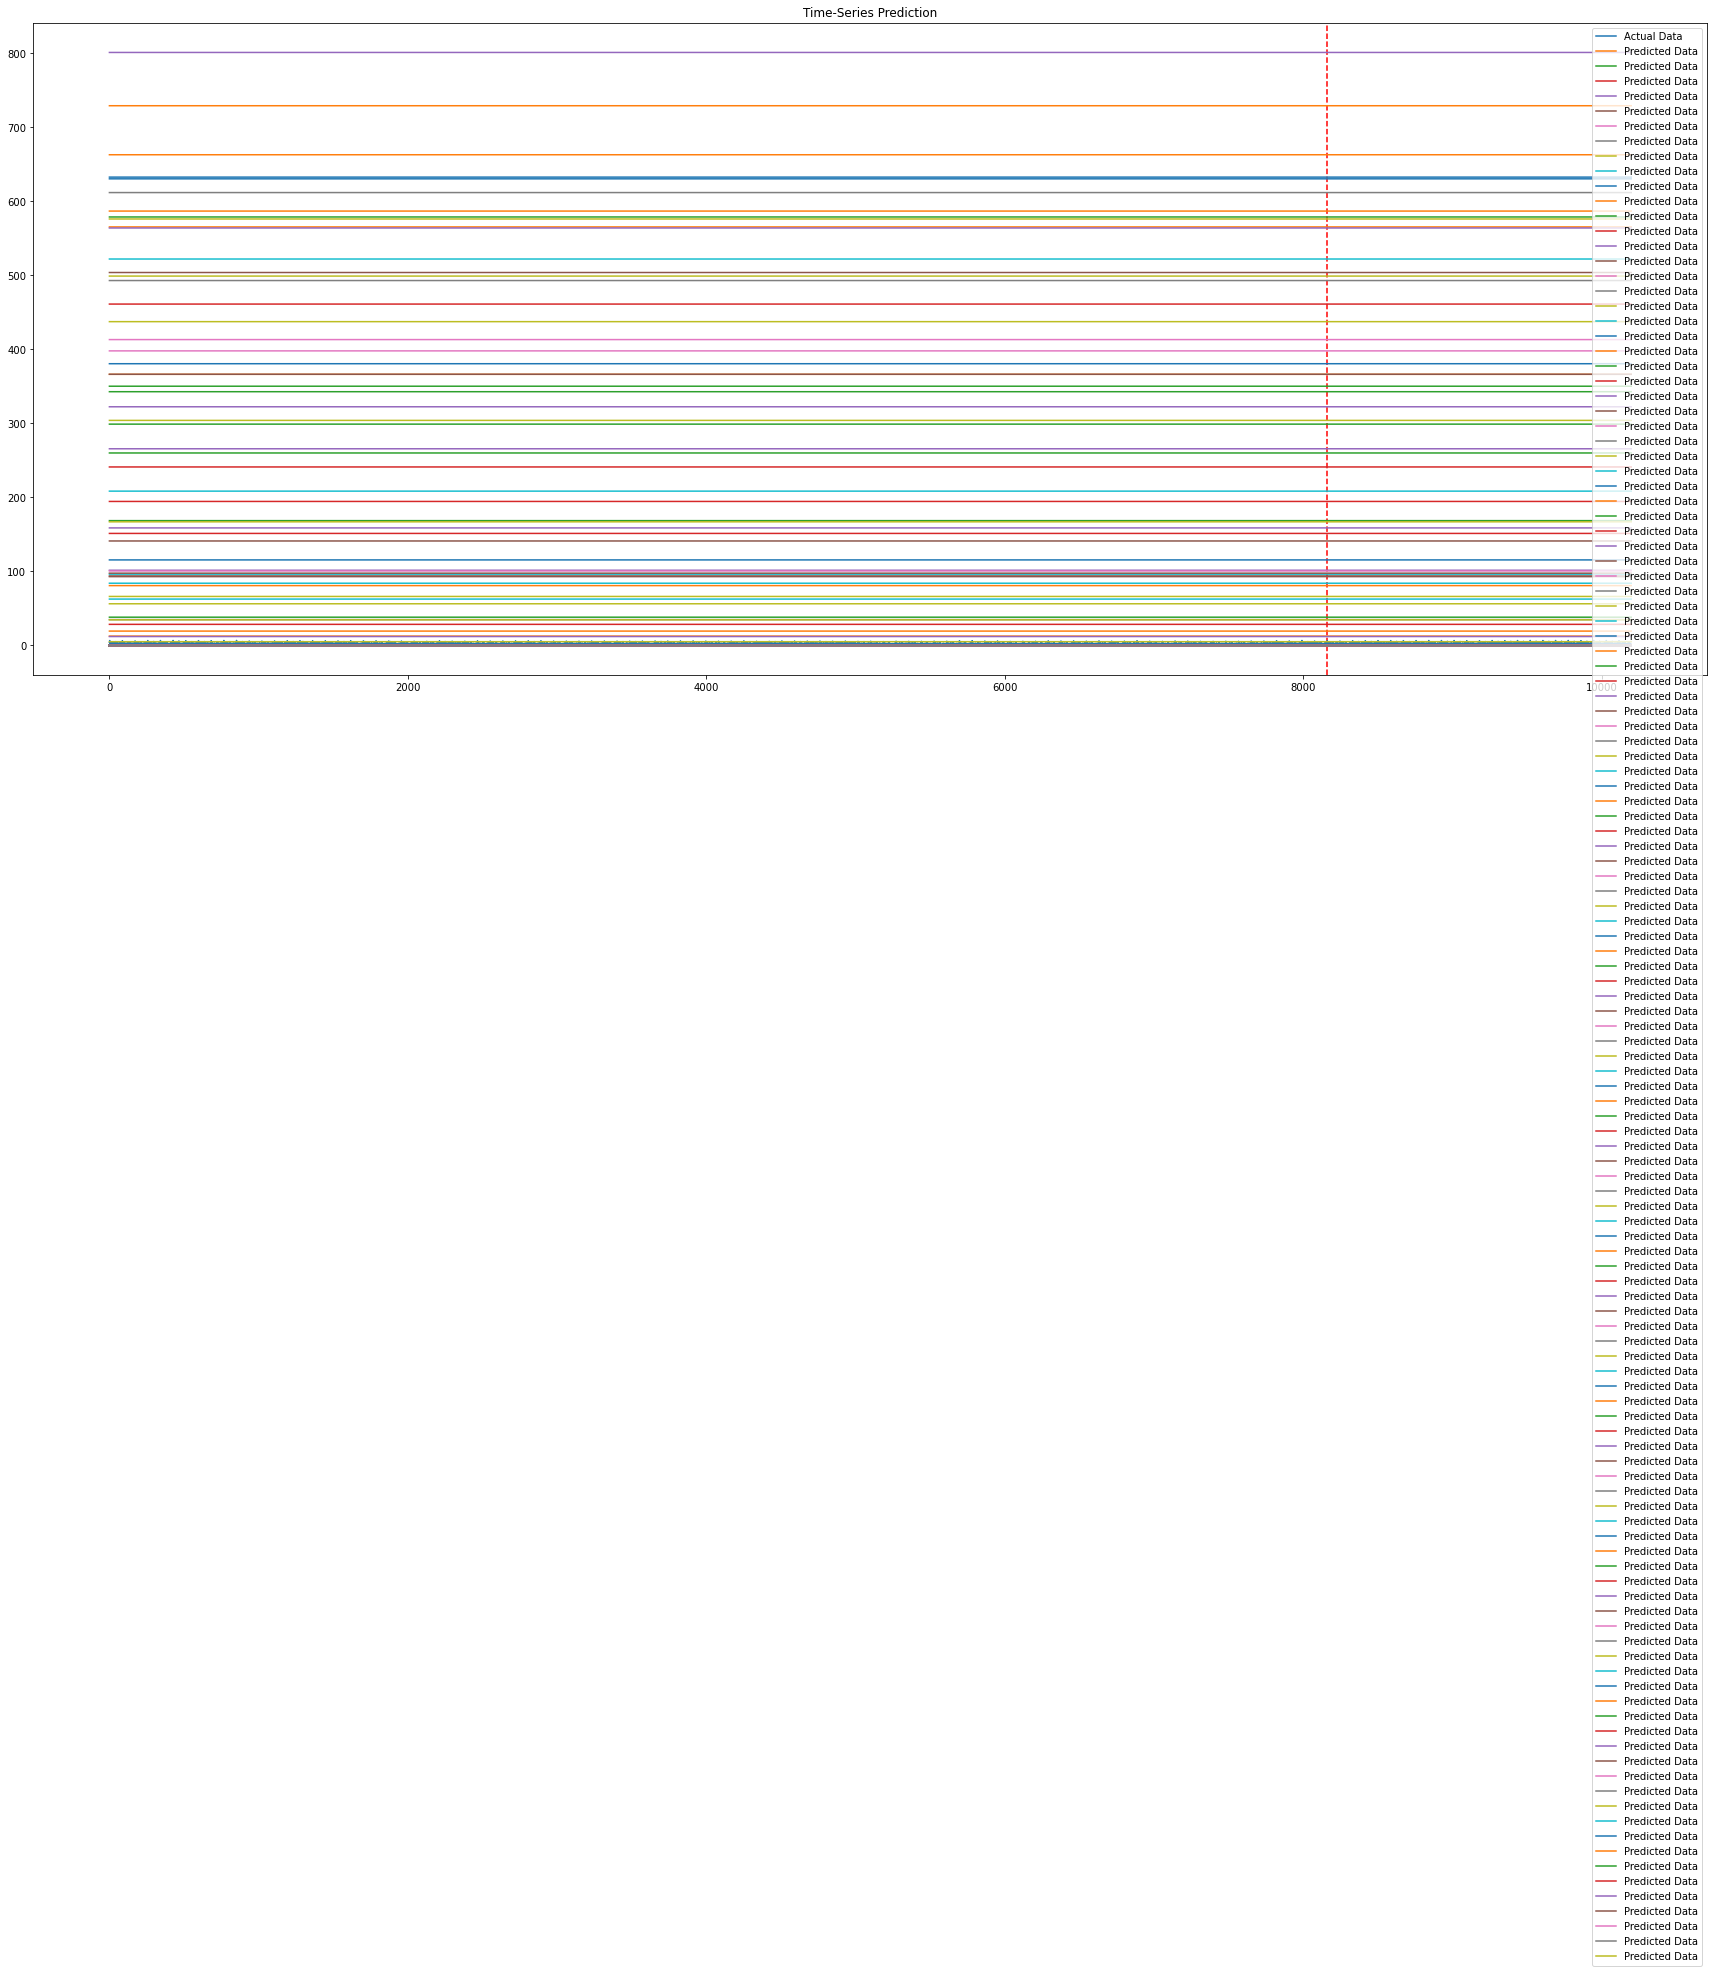

In [ ]:
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

## log-LSTM 예측

In [ ]:
seed_all(seed=42)

Using Seed Number 42


In [ ]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [ ]:
train_data4.drop(['employment', 'CFI'], axis=1, inplace=True)
test_data4.drop(['employment', 'CFI'], axis=1, inplace=True)

In [ ]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [ ]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [ ]:
display(train_data4, test_data4)

date  job_offer  no_company  unemployment  population       GDP  \
0    2013-01-01   4.110874   10.316259      4.584967   16.137414  7.354810   
1    2013-01-01   4.653960   11.602611      5.313206   16.137414  7.354810   
2    2013-01-01   6.638568   10.059850      7.115582   16.137414  7.354810   
3    2013-01-01   3.583519   10.423768      4.262680   16.137414  7.354810   
4    2013-01-01   4.174387    9.356948      4.143135   16.137414  7.354810   
...         ...        ...         ...           ...         ...       ...   
8155 2020-12-01   3.637586    7.578657      0.693147   13.421929  7.517793   
8156 2020-12-01   0.000000    8.787526      1.386294   13.421929  7.517793   
8157 2020-12-01   1.945910    6.061457      2.833213   13.421929  7.517793   
8158 2020-12-01   0.000000    7.198931      1.386294   13.421929  7.517793   
8159 2020-12-01   1.609438    7.156956      1.098612   13.421929  7.517793   

        i_rate       CLI   경기   경남  ...   인천   전남   전북   제주   충남   충북  \
0     1.321756  4.606665  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
1     1.321756  4.606665  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
2     1.321756  4.606665  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
3     1.321756  4.606665  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
4     1.321756  4.606665  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
...        ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8155  0.405465  4.631365  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8156  0.405465  4.631365  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8157  0.405465  4.631365  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8158  0.405465  4.631365  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0   
8159  0.405465  4.631365  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0   

      사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0                          0.0               0.0    0.0  1.0  
1                          0.0               0.0    0.0  0.0  
2                          0.0               0.0    1.0  0.0  
3                          0.0               1.0    0.0  0.0  
4                          1.0               0.0    0.0  0.0  
...                        ...               ...    ...  ...  
8155                       0.0               0.0    0.0  1.0  
8156                       0.0               0.0    0.0  0.0  
8157                       0.0               0.0    1.0  0.0  
8158                       0.0               1.0    0.0  0.0  
8159                       1.0               0.0    0.0  0.0  

[8160 rows x 28 columns]

date  job_offer  no_company  unemployment  population       GDP  \
0    2021-01-01   3.583519   10.385574      4.753590   16.083294  7.559924   
1    2021-01-01   3.555348   11.786199      5.123964   16.083294  7.559924   
2    2021-01-01   6.452049   10.392221      7.266827   16.083294  7.559924   
3    2021-01-01   3.555348   10.784835      4.812184   16.083294  7.559924   
4    2021-01-01   3.178054    9.836920      4.653960   16.083294  7.559924   
...         ...        ...         ...           ...         ...       ...   
2035 2022-12-01   0.000000    7.666222      1.098612   13.427139  7.585687   
2036 2022-12-01   0.000000    8.907342      1.945910   13.427139  7.585687   
2037 2022-12-01   2.197225    6.327937      3.178054   13.427139  7.585687   
2038 2022-12-01   0.693147    7.353722      1.609438   13.427139  7.585687   
2039 2022-12-01   0.000000    7.278629      2.197225   13.427139  7.585687   

        i_rate       CLI   경기   경남  ...   인천   전남   전북   제주   충남   충북  \
0     0.405465  4.634959  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.405465  4.634959  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.405465  4.634959  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.405465  4.634959  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.405465  4.634959  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
...        ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2035  1.446919  4.602676  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2036  1.446919  4.602676  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2037  1.446919  4.602676  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2038  1.446919  4.602676  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0   
2039  1.446919  4.602676  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0   

      사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0                          0.0               0.0    0.0  1.0  
1                          0.0               0.0    0.0  0.0  
2                          0.0               0.0    1.0  0.0  
3                          0.0               1.0    0.0  0.0  
4                          1.0               0.0    0.0  0.0  
...                        ...               ...    ...  ...  
2035                       0.0               0.0    0.0  1.0  
2036                       0.0               0.0    0.0  0.0  
2037                       0.0               0.0    1.0  0.0  
2038                       0.0               1.0    0.0  0.0  
2039                       1.0               0.0    0.0  0.0  

[2040 rows x 28 columns]

In [ ]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [ ]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 26) (8160, 1) (2040, 26) (2040, 1)


In [ ]:
train4_x.iloc[:, :8]

no_company  unemployment  population       GDP    i_rate  \
date                                                                   
2013-01-01   10.316259      4.584967   16.137414  7.354810  1.321756   
2013-01-01   11.602611      5.313206   16.137414  7.354810  1.321756   
2013-01-01   10.059850      7.115582   16.137414  7.354810  1.321756   
2013-01-01   10.423768      4.262680   16.137414  7.354810  1.321756   
2013-01-01    9.356948      4.143135   16.137414  7.354810  1.321756   
...                ...           ...         ...       ...       ...   
2020-12-01    7.578657      0.693147   13.421929  7.517793  0.405465   
2020-12-01    8.787526      1.386294   13.421929  7.517793  0.405465   
2020-12-01    6.061457      2.833213   13.421929  7.517793  0.405465   
2020-12-01    7.198931      1.386294   13.421929  7.517793  0.405465   
2020-12-01    7.156956      1.098612   13.421929  7.517793  0.405465   

                 CLI   경기   경남  
date                            
2013-01-01  4.606665  0.0  0.0  
2013-01-01  4.606665  0.0  0.0  
2013-01-01  4.606665  0.0  0.0  
2013-01-01  4.606665  0.0  0.0  
2013-01-01  4.606665  0.0  0.0  
...              ...  ...  ...  
2020-12-01  4.631365  0.0  0.0  
2020-12-01  4.631365  0.0  0.0  
2020-12-01  4.631365  0.0  0.0  
2020-12-01  4.631365  0.0  0.0  
2020-12-01  4.631365  0.0  0.0  

[8160 rows x 8 columns]

In [ ]:
# Scaling
scale_columns = ['no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [ ]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 26]), torch.Size([2040, 26]))

In [ ]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (train4_x.shape[0], 1, train4_x.shape[1]))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (test4_x.shape[0], 1, test4_x.shape[1]))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 26]) torch.Size([2040, 1]) torch.Size([2040, 1, 26]) torch.Size([2040, 1])


In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [ ]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.0001  # 학습률 지정

input_size = 26 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.4365125596523285
Epoch: 100, loss: 0.19702588021755219


Epoch: 200, loss: 0.08963900059461594
Epoch: 300, loss: 0.053055476397275925
Epoch: 400, loss: 0.04430464282631874
Epoch: 500, loss: 0.04290735721588135
Epoch: 600, loss: 0.04265584424138069
Epoch: 700, loss: 0.04253936931490898
Epoch: 800, loss: 0.04240420088171959
Epoch: 900, loss: 0.042065300047397614


In [ ]:
logdata_scale = log_data.copy()

In [ ]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [ ]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [ ]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [ ]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [ ]:
logdata_scale.drop(['employment', 'CFI'], axis=1, inplace=True)

In [ ]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:7] = ss.transform(logdata_scale.iloc[:, 1:7])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [ ]:
logdata_scale.head()

job_offer  no_company  unemployment  population       GDP  \
date                                                                    
2013-01-01   0.601713    1.382974      1.426953    1.789595 -1.646227   
2013-01-01   0.681205    2.224989      1.899060    1.789595 -1.646227   
2013-01-01   0.971694    1.215134      3.067516    1.789595 -1.646227   
2013-01-01   0.524523    1.453346      1.218018    1.789595 -1.646227   
2013-01-01   0.611009    0.755031      1.140518    1.789595 -1.646227   

              i_rate       CLI   경기   경남   경북  ...   인천   전남   전북   제주   충남  \
date                                           ...                            
2013-01-01  1.616496 -1.040983  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
2013-01-01  1.616496 -1.040983  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
2013-01-01  1.616496 -1.040983  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
2013-01-01  1.616496 -1.040983  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
2013-01-01  1.616496 -1.040983  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

             충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
date                                                                     
2013-01-01  0.0                       0.0               0.0    0.0  1.0  
2013-01-01  0.0                       0.0               0.0    0.0  0.0  
2013-01-01  0.0                       0.0               0.0    1.0  0.0  
2013-01-01  0.0                       0.0               1.0    0.0  0.0  
2013-01-01  0.0                       1.0               0.0    0.0  0.0  

[5 rows x 27 columns]

In [ ]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

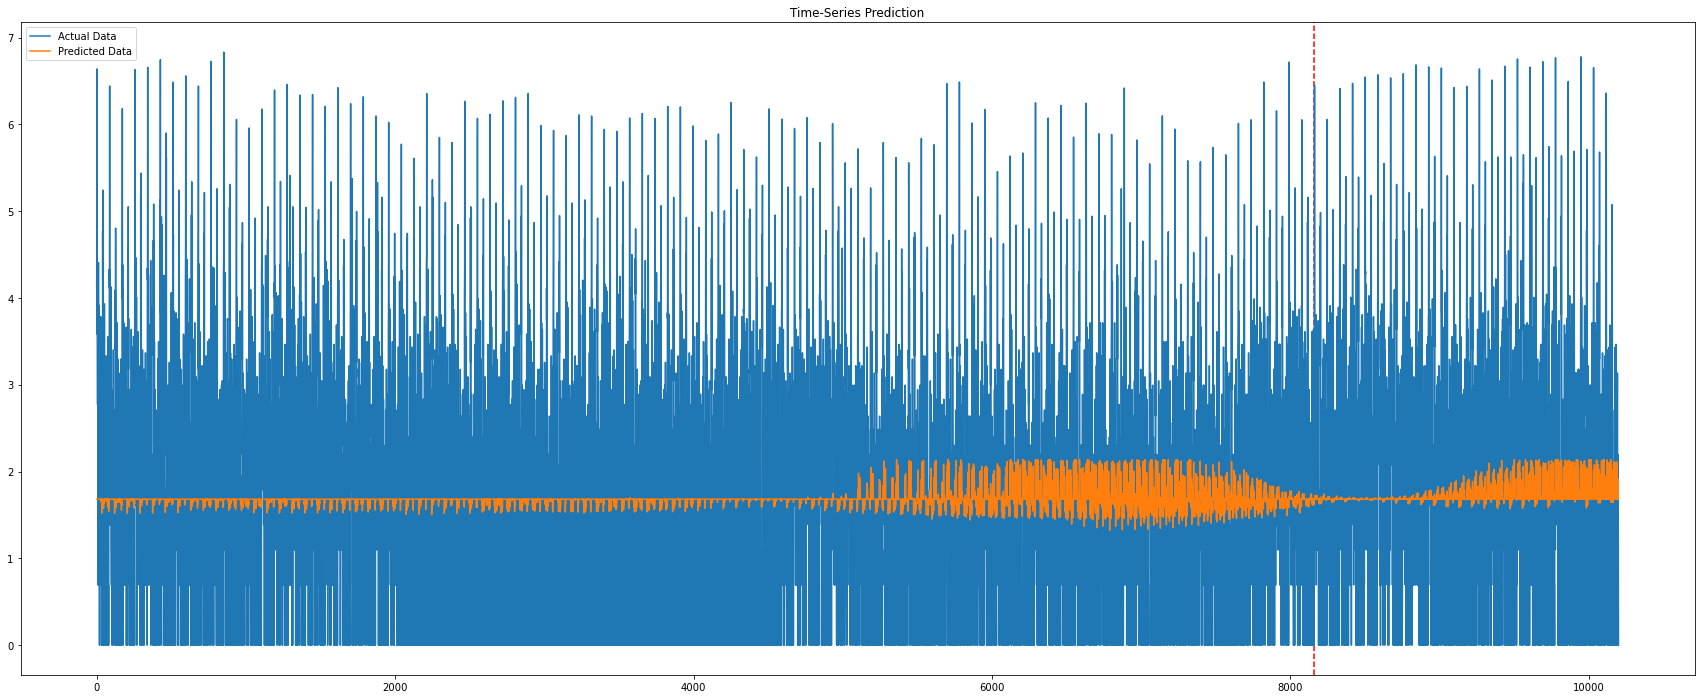

In [ ]:
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

딥러닝의 경우 컬럼 제외 없이 학습하는 것이 더 좋아보임

In [175]:
seed_all(seed=42)

Using Seed Number 42


In [176]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [177]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [178]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [179]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [180]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [181]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [182]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [183]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [184]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [185]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [186]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [187]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.0001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [188]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.4721303880214691
Epoch: 100, loss: 0.2273958921432495
Epoch: 200, loss: 0.10762369632720947
Epoch: 300, loss: 0.059549346566200256
Epoch: 400, loss: 0.04410692676901817
Epoch: 500, loss: 0.03957195580005646
Epoch: 600, loss: 0.037527959793806076
Epoch: 700, loss: 0.035770125687122345
Epoch: 800, loss: 0.03405303880572319
Epoch: 900, loss: 0.0324537456035614


In [189]:
logdata_scale = log_data.copy()

In [190]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [191]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [192]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [193]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [194]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [195]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [196]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

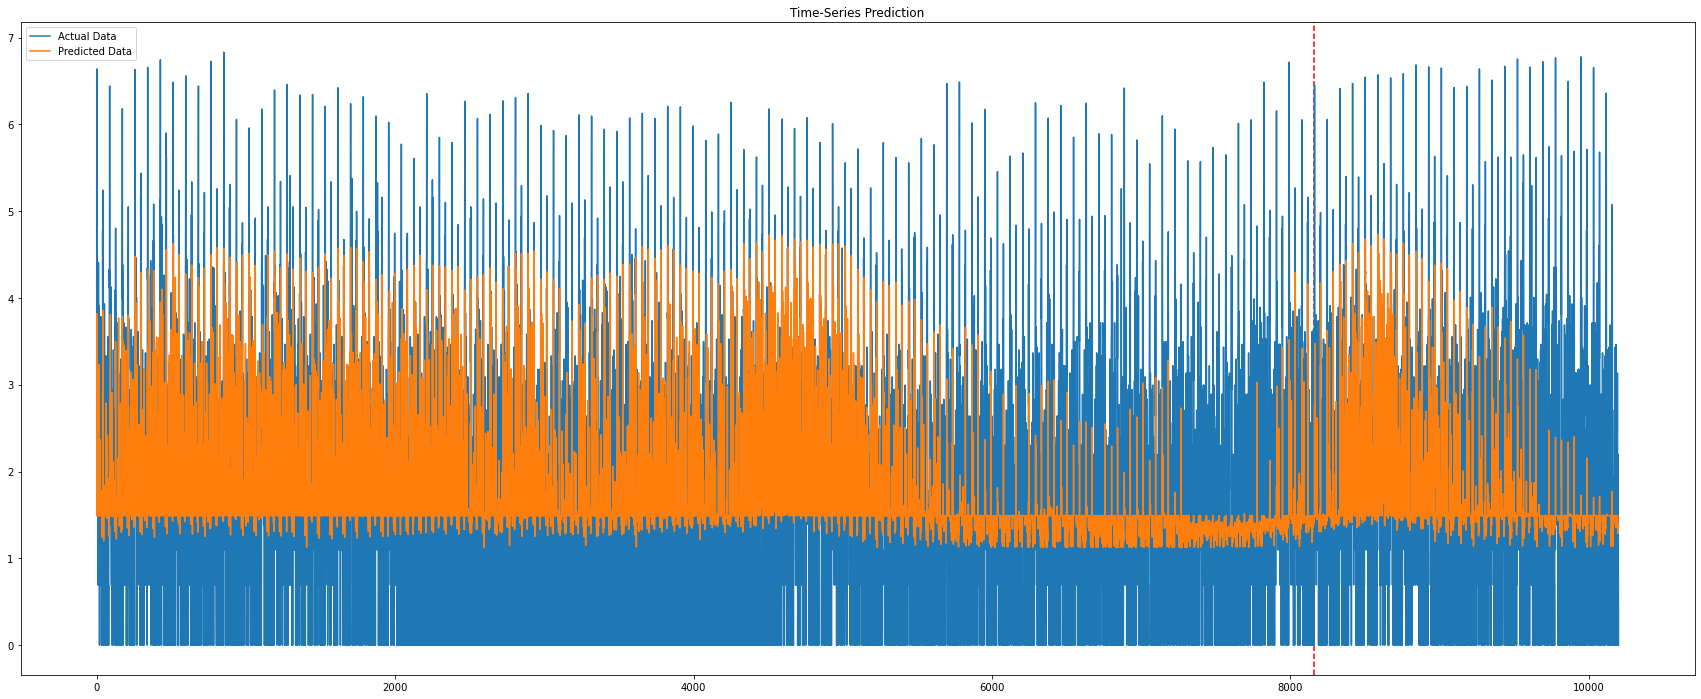

In [197]:
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [198]:
len(predicted)

10200

In [199]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [200]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [201]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [202]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [203]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [204]:
df_temp.iloc[:, :8] = ss.transform(df_temp.iloc[:, :8])

In [205]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [206]:
predict = model(data_scale)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

array([[2.8995705]], dtype=float32)

In [207]:
np.expm1(predicted)

array([[17.16634]], dtype=float32)

모델 수정(배치 정규화 적용)

In [186]:
seed_all(seed=42)

Using Seed Number 42


In [187]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [188]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [189]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [190]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [191]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [192]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [193]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [194]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [195]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [196]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [197]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(2)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [198]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.0001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [199]:
print(model)

LSTM(
  (lstm): LSTM(28, 2, batch_first=True)
  (bn_2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [200]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.33405277132987976
Epoch: 100, loss: 0.0720219835639
Epoch: 200, loss: 0.04265045374631882
Epoch: 300, loss: 0.040131621062755585
Epoch: 400, loss: 0.03884090855717659
Epoch: 500, loss: 0.03761720284819603
Epoch: 600, loss: 0.03617386892437935
Epoch: 700, loss: 0.03497012332081795
Epoch: 800, loss: 0.034010063856840134
Epoch: 900, loss: 0.0331232063472271


In [201]:
logdata_scale = log_data.copy()

In [202]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [203]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [204]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [205]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [206]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [207]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [208]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

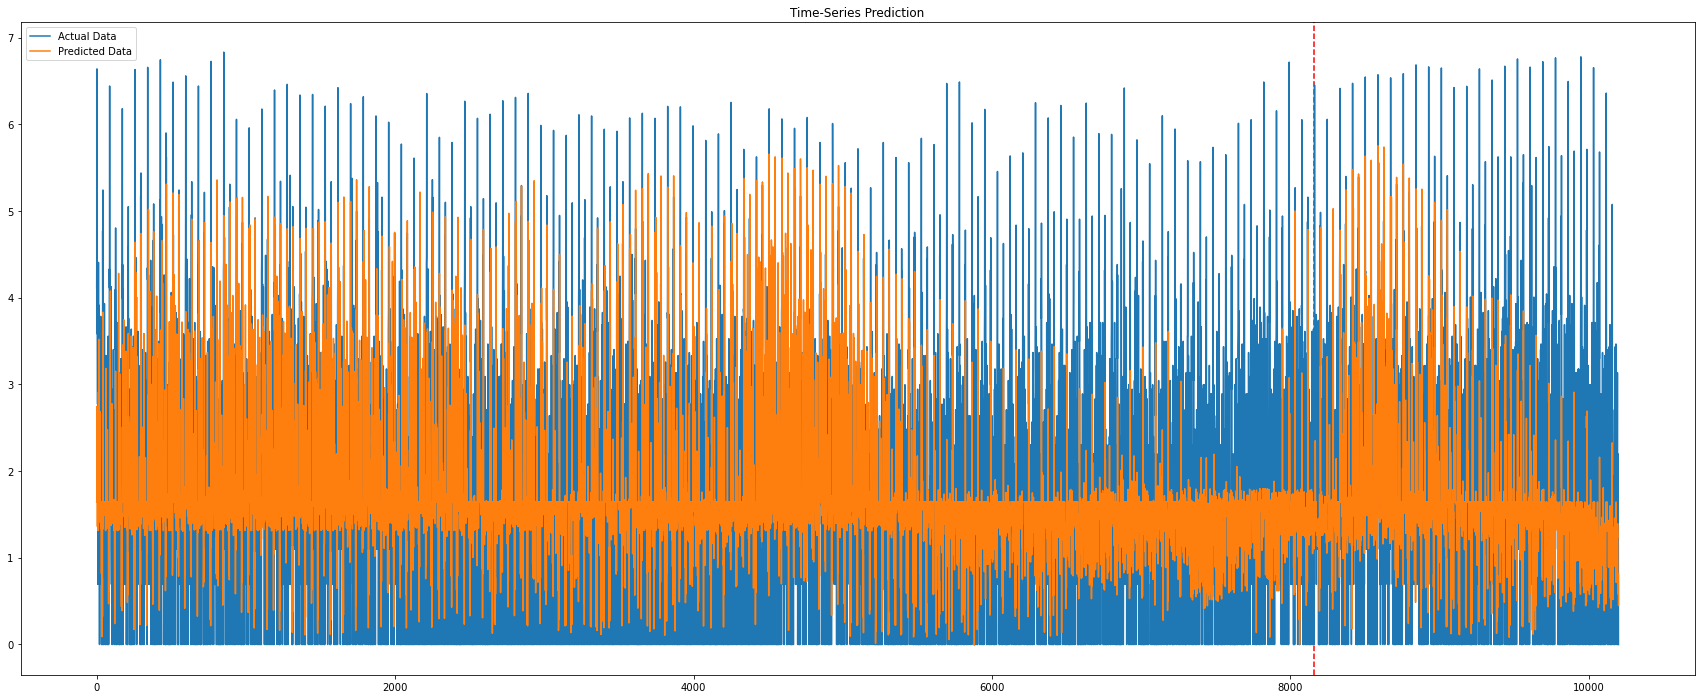

In [209]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [210]:
len(predicted)

10200

In [211]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [212]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [213]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [214]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [215]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [216]:
df_temp.iloc[:, :8] = ss.transform(df_temp.iloc[:, :8])

In [217]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [218]:
data_scale.shape

torch.Size([1, 1, 28])

In [219]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

예측값: tensor([[-0.0676]])


array([[-0.46211302]], dtype=float32)

In [220]:
np.expm1(predicted)

array([[-0.37004888]], dtype=float32)

In [221]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real      pred
0      35.0  4.173630
1      34.0  4.173630
2     633.0  3.841763
3      34.0  4.173630
4      23.0  4.173630
...     ...       ...
2035    0.0  0.935703
2036    0.0  1.008866
2037    8.0  0.788411
2038    1.0  1.261364
2039    0.0  0.571169

[2040 rows x 2 columns]

In [222]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 5745.127905027489, RMSE: 75.79662198955498, MSLE: 1.7053926245559987, RMSLE: 1.3059068207785725, corr: 0.4930594178450074, score: 22.116060247724945


모델 수정(배치 정규화, 드롭아웃 적용)

In [223]:
seed_all(seed=42)

Using Seed Number 42


In [224]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [225]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [226]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [227]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [228]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [229]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [230]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [231]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [232]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [233]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [234]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(2)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.do = nn.Dropout(0.1)
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.do(out)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.do(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [235]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.0001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [236]:
print(model)

LSTM(
  (lstm): LSTM(28, 2, batch_first=True)
  (bn_2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (do): Dropout(p=0.1, inplace=False)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [237]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.36055466532707214
Epoch: 100, loss: 0.09575353562831879
Epoch: 200, loss: 0.060811322182416916
Epoch: 300, loss: 0.057346589863300323
Epoch: 400, loss: 0.05548281967639923
Epoch: 500, loss: 0.05364244431257248
Epoch: 600, loss: 0.05308802053332329
Epoch: 700, loss: 0.04905547946691513
Epoch: 800, loss: 0.0484759584069252
Epoch: 900, loss: 0.04649633541703224


In [238]:
logdata_scale = log_data.copy()

In [239]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [240]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [241]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [242]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [243]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [244]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [245]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

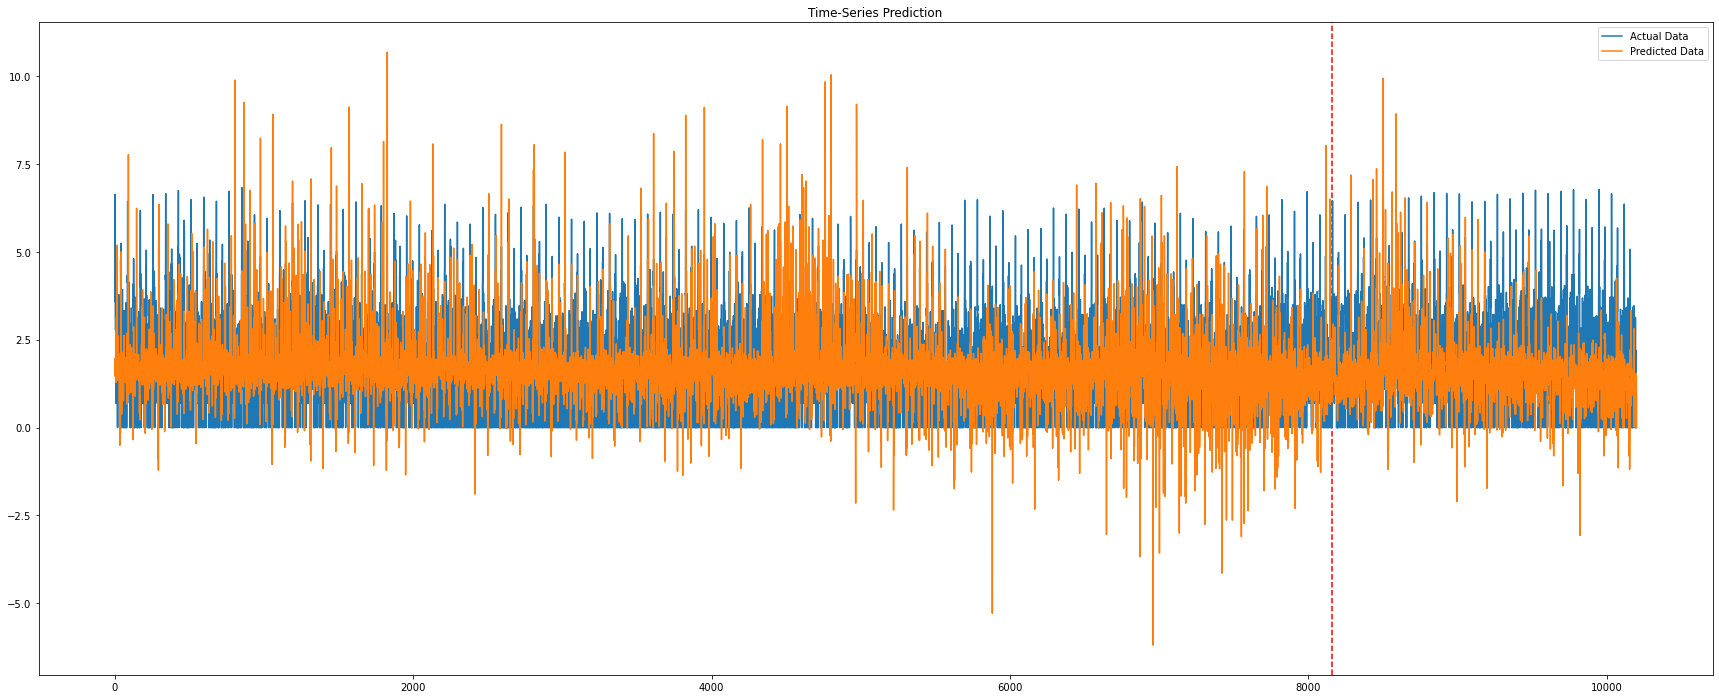

In [246]:
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [247]:
len(predicted)

10200

In [248]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [249]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [250]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [251]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [252]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [253]:
df_temp.iloc[:, :8] = ss.transform(df_temp.iloc[:, :8])

In [254]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [255]:
data_scale.shape

torch.Size([1, 1, 28])

In [256]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

예측값: tensor([[-0.3292]])


array([[-2.2491899]], dtype=float32)

In [257]:
np.expm1(predicted)

array([[-0.89451534]], dtype=float32)

In [258]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real      pred
0      35.0  4.522067
1      34.0  4.522067
2     633.0  4.522067
3      34.0  4.522067
4      23.0  4.522067
...     ...       ...
2035    0.0  1.037718
2036    0.0  1.153031
2037    8.0  0.893836
2038    1.0  1.326455
2039    0.0  0.683705

[2040 rows x 2 columns]

In [259]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
# MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
# RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, corr: {corr}, score: {score}')

MSE: 6173.956651976522, RMSE: 78.5745292825641, corr: 0.4643165542285173, score: 16.302634882173873


모델 수정(배치 정규화, 드롭아웃 적용, 학습률 상향)

In [260]:
seed_all(seed=42)

Using Seed Number 42


In [261]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [262]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [263]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [264]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [265]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [266]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [267]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [268]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [269]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [270]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [271]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(2)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.do = nn.Dropout(0.1)
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.do(out)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.do(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [272]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [273]:
print(model)

LSTM(
  (lstm): LSTM(28, 2, batch_first=True)
  (bn_2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (do): Dropout(p=0.1, inplace=False)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [274]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.36055466532707214


Epoch: 100, loss: 0.0478445440530777
Epoch: 200, loss: 0.03817987069487572
Epoch: 300, loss: 0.033707406371831894
Epoch: 400, loss: 0.029594216495752335
Epoch: 500, loss: 0.02664361149072647
Epoch: 600, loss: 0.023989100009202957
Epoch: 700, loss: 0.02201012894511223
Epoch: 800, loss: 0.02100418321788311
Epoch: 900, loss: 0.01933068409562111


In [275]:
logdata_scale = log_data.copy()

In [276]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [277]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [278]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [279]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [280]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [281]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [282]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

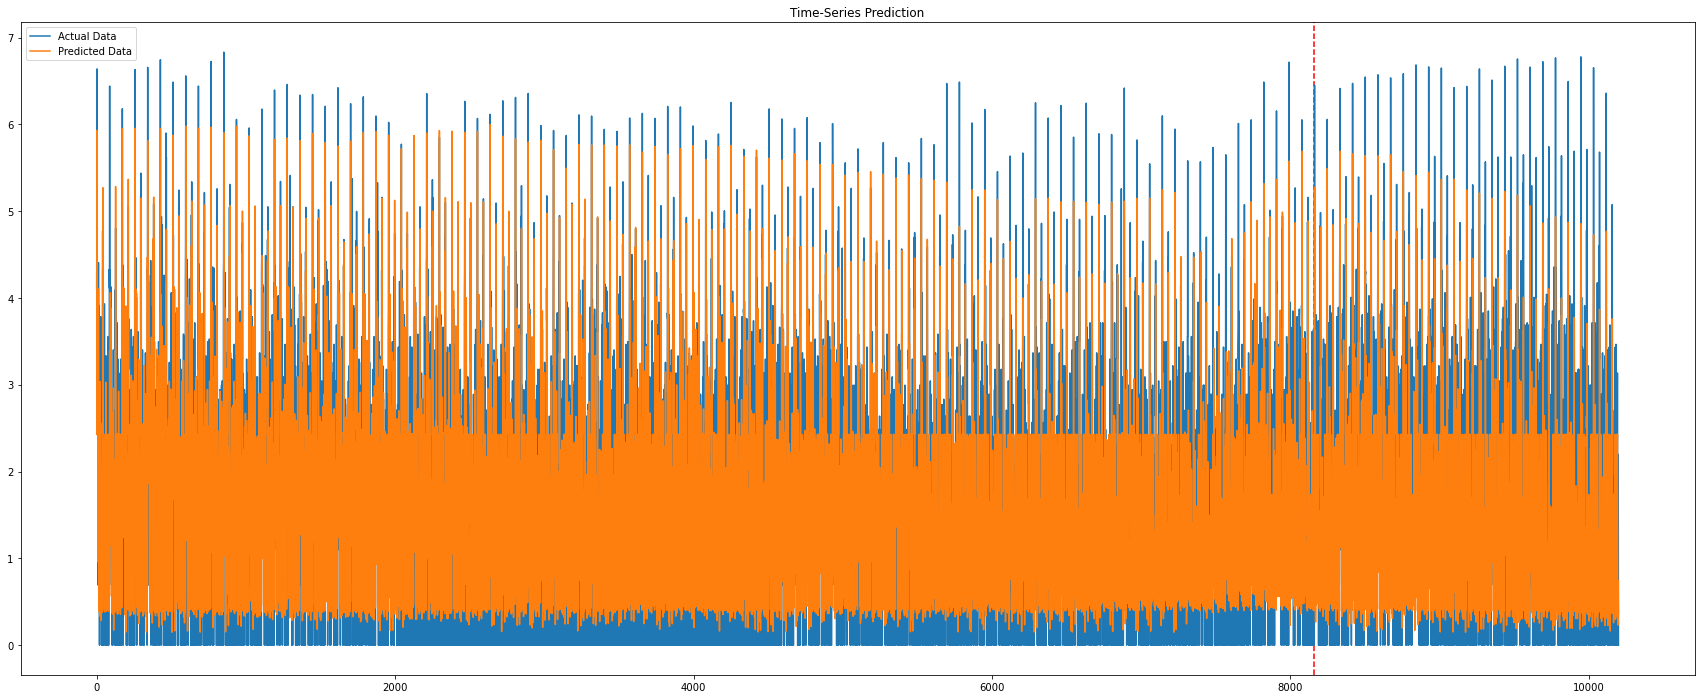

In [283]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [284]:
len(predicted)

10200

In [285]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [286]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [287]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [288]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [289]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [290]:
df_temp.iloc[:, :8] = ss.transform(df_temp.iloc[:, :8])

In [291]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [292]:
data_scale.shape

torch.Size([1, 1, 28])

In [293]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

예측값: tensor([[0.2270]])


array([[1.5505751]], dtype=float32)

In [294]:
np.expm1(predicted)

array([[3.7141807]], dtype=float32)

In [295]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real        pred
0      35.0   10.336684
1      34.0   10.336684
2     633.0  194.420227
3      34.0   10.336684
4      23.0   10.336684
...     ...         ...
2035    0.0    1.103910
2036    0.0    0.674443
2037    8.0    0.853005
2038    1.0    0.682191
2039    0.0    0.440443

[2040 rows x 2 columns]

In [296]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 4051.100054092862, RMSE: 63.648252561188684, MSLE: 0.9565005437874708, RMSLE: 0.9780084579324817, corr: 0.8998924723301348, score: 45.08118221923259


모델 수정(배치 정규화 적용, 학습률 상향)

In [297]:
seed_all(seed=42)

Using Seed Number 42


In [298]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [299]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [300]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [301]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [302]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [303]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [304]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [305]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [306]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [307]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [308]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(2)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [309]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [310]:
print(model)

LSTM(
  (lstm): LSTM(28, 2, batch_first=True)
  (bn_2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [311]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.33405277132987976
Epoch: 100, loss: 0.0335671566426754
Epoch: 200, loss: 0.027574438601732254
Epoch: 300, loss: 0.024628838524222374
Epoch: 400, loss: 0.023003172129392624
Epoch: 500, loss: 0.021695906296372414
Epoch: 600, loss: 0.020628727972507477
Epoch: 700, loss: 0.019024929031729698
Epoch: 800, loss: 0.01755901426076889
Epoch: 900, loss: 0.016196517273783684


In [312]:
logdata_scale = log_data.copy()

In [313]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [314]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [315]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [316]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [317]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [318]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [319]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

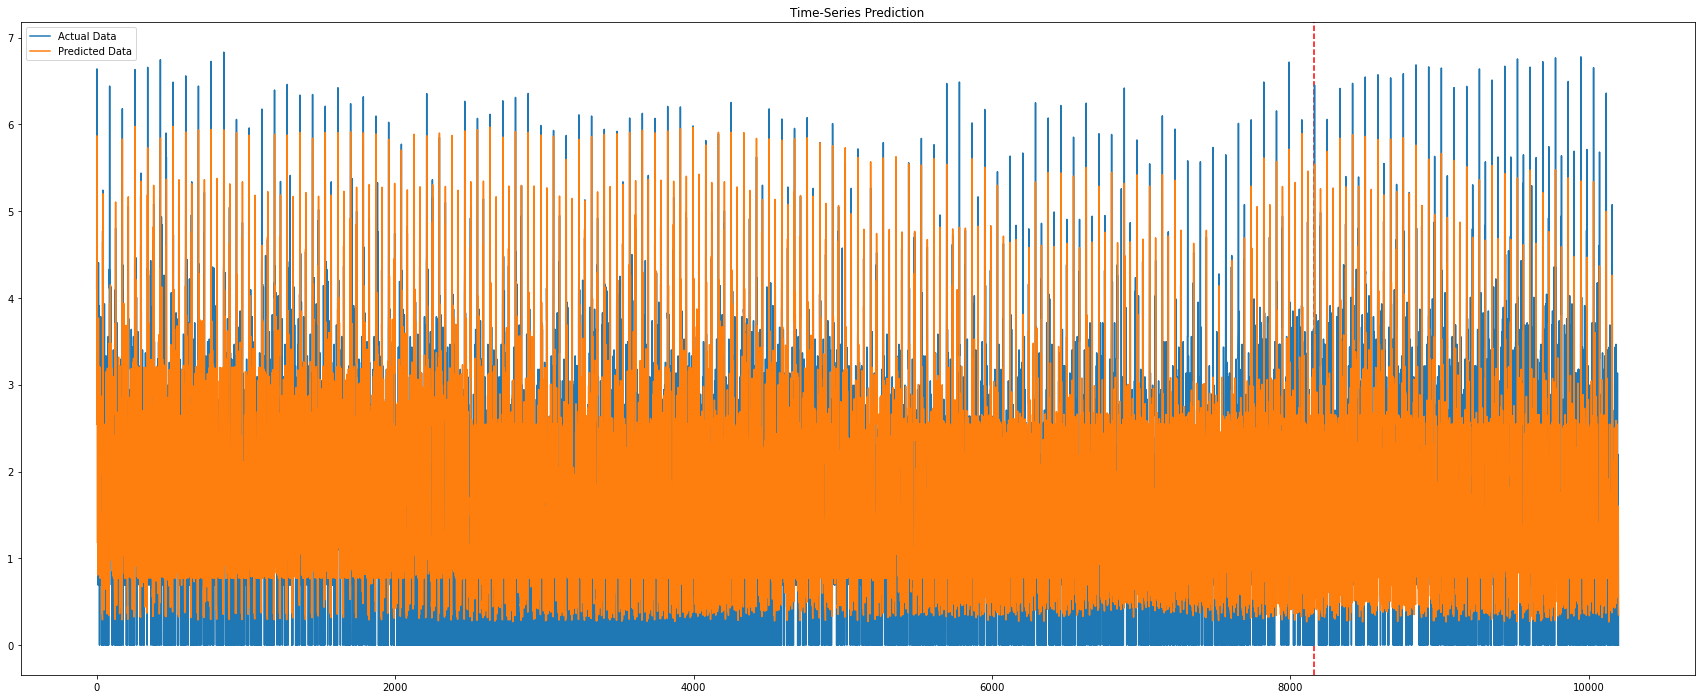

In [320]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [321]:
len(predicted)

10200

In [322]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [323]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [324]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [325]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [326]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [327]:
df_temp.iloc[:, :8] = ss.transform(df_temp.iloc[:, :8])

In [328]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [329]:
data_scale.shape

torch.Size([1, 1, 28])

In [330]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

예측값: tensor([[0.8979]])


array([[6.134387]], dtype=float32)

In [331]:
np.expm1(predicted)

array([[460.45615]], dtype=float32)

In [332]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real        pred
0      35.0   11.750830
1      34.0   11.750830
2     633.0  253.442627
3      34.0   11.750830
4      23.0   11.750830
...     ...         ...
2035    0.0    1.211836
2036    0.0    0.738649
2037    8.0    3.960027
2038    1.0    0.525896
2039    0.0    0.416628

[2040 rows x 2 columns]

In [333]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 3082.1076972547394, RMSE: 55.516733488694555, MSLE: 0.7324781372057395, RMSLE: 0.8558493659550959, corr: 0.9144533611746875, score: 58.217346215573464


모델 수정(배치 정규화 적용, 학습률 상향, epoch 증가)

In [334]:
seed_all(seed=42)

Using Seed Number 42


In [335]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [336]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [337]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [338]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [339]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [340]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [341]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [342]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [343]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [344]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [345]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(2)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [346]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 2000       # 에포크 횟수 지정
learning_rate = 0.001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [347]:
print(model)

LSTM(
  (lstm): LSTM(28, 2, batch_first=True)
  (bn_2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [348]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.33405277132987976
Epoch: 100, loss: 0.0335671566426754
Epoch: 200, loss: 0.027574438601732254
Epoch: 300, loss: 0.024628838524222374
Epoch: 400, loss: 0.023003172129392624
Epoch: 500, loss: 0.021695906296372414
Epoch: 600, loss: 0.020628727972507477
Epoch: 700, loss: 0.019024929031729698
Epoch: 800, loss: 0.01755901426076889
Epoch: 900, loss: 0.016196517273783684
Epoch: 1000, loss: 0.014311855658888817
Epoch: 1100, loss: 0.013327138498425484
Epoch: 1200, loss: 0.012784681282937527
Epoch: 1300, loss: 0.0124705471098423
Epoch: 1400, loss: 0.012258337810635567
Epoch: 1500, loss: 0.012099869549274445
Epoch: 1600, loss: 0.01196100004017353
Epoch: 1700, loss: 0.011845349334180355
Epoch: 1800, loss: 0.01174125261604786
Epoch: 1900, loss: 0.011649460531771183


In [349]:
logdata_scale = log_data.copy()

In [350]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [351]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [352]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [353]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [354]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [355]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [356]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

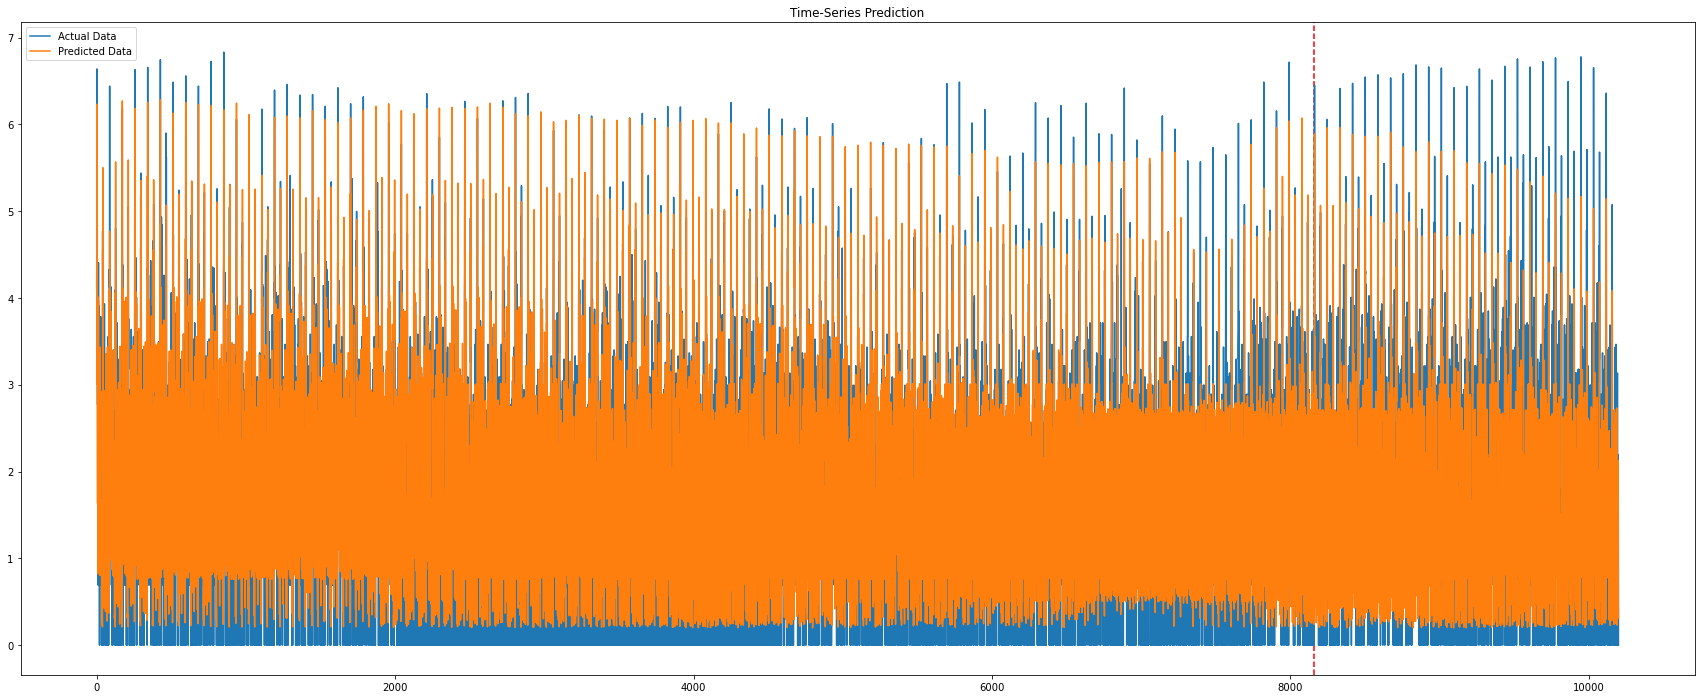

In [357]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [358]:
len(predicted)

10200

In [359]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [360]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [361]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [362]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [363]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [364]:
df_temp.iloc[:, :8] = ss.transform(df_temp.iloc[:, :8])

In [365]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [366]:
data_scale.shape

torch.Size([1, 1, 28])

In [367]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

예측값: tensor([[0.1332]])


array([[0.90982443]], dtype=float32)

In [368]:
np.expm1(predicted)

array([[1.4838864]], dtype=float32)

In [369]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real        pred
0      35.0   19.244122
1      34.0   19.244122
2     633.0  360.100525
3      34.0   19.244122
4      23.0   19.244122
...     ...         ...
2035    0.0    0.987635
2036    0.0    0.760261
2037    8.0    7.362561
2038    1.0    0.597063
2039    0.0    0.365626

[2040 rows x 2 columns]

In [370]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 3087.1448220104226, RMSE: 55.56208079266311, MSLE: 0.6881358187287764, RMSLE: 0.8295395221017359, corr: 0.9132555261910472, score: 58.1490603344788


모델 수정(배치 정규화, 드롭아웃 적용, 학습률 상향, epoch 상향)

In [371]:
seed_all(seed=42)

Using Seed Number 42


In [372]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [373]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [374]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [375]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [376]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [377]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [378]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [379]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [380]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [381]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [382]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(2)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.do = nn.Dropout(0.1)
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.do(out)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.do(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [383]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 2000       # 에포크 횟수 지정
learning_rate = 0.001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [384]:
print(model)

LSTM(
  (lstm): LSTM(28, 2, batch_first=True)
  (bn_2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (do): Dropout(p=0.1, inplace=False)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [385]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.36055466532707214


Epoch: 100, loss: 0.0478445440530777
Epoch: 200, loss: 0.03817987069487572
Epoch: 300, loss: 0.033707406371831894
Epoch: 400, loss: 0.029594216495752335
Epoch: 500, loss: 0.02664361149072647
Epoch: 600, loss: 0.023989100009202957
Epoch: 700, loss: 0.02201012894511223
Epoch: 800, loss: 0.02100418321788311
Epoch: 900, loss: 0.01933068409562111
Epoch: 1000, loss: 0.01792043447494507
Epoch: 1100, loss: 0.01737913303077221
Epoch: 1200, loss: 0.01659739762544632
Epoch: 1300, loss: 0.016398079693317413
Epoch: 1400, loss: 0.015864353626966476
Epoch: 1500, loss: 0.015348597429692745
Epoch: 1600, loss: 0.01530006155371666
Epoch: 1700, loss: 0.014994216151535511
Epoch: 1800, loss: 0.01488552801311016
Epoch: 1900, loss: 0.014589313417673111


In [386]:
logdata_scale = log_data.copy()

In [387]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [388]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [389]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [390]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [391]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [392]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [393]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

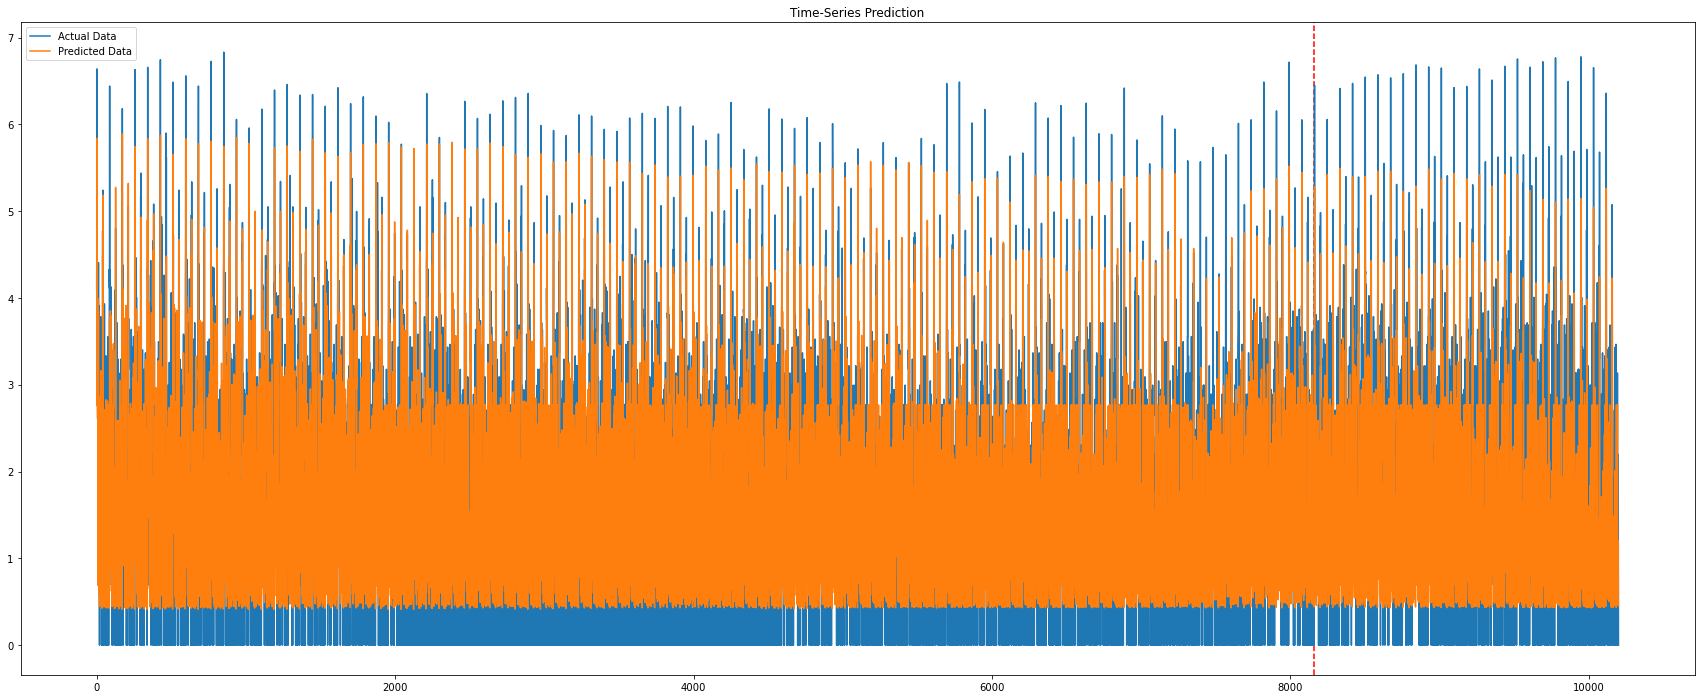

In [394]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [395]:
len(predicted)

10200

In [396]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [397]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [398]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [399]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [400]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [401]:
df_temp.iloc[:, :8] = ss.transform(df_temp.iloc[:, :8])

In [402]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [403]:
data_scale.shape

torch.Size([1, 1, 28])

In [404]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

예측값: tensor([[0.1767]])


array([[1.2069038]], dtype=float32)

In [405]:
np.expm1(predicted)

array([[2.3431177]], dtype=float32)

In [406]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real        pred
0      35.0   14.915030
1      34.0   14.915030
2     633.0  196.281326
3      34.0   14.915030
4      23.0   14.915030
...     ...         ...
2035    0.0    1.219967
2036    0.0    0.860248
2037    8.0    2.319647
2038    1.0    0.646180
2039    0.0    0.566308

[2040 rows x 2 columns]

In [407]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 3862.40648481397, RMSE: 62.14826212223452, MSLE: 0.7592582677392204, RMSLE: 0.871354272233298, corr: 0.9476710133432801, score: 47.63921031265389


모델 수정(배치 정규화, StandardScaler -> RobustScaler)

In [408]:
seed_all(seed=42)

Using Seed Number 42


In [409]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [410]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [411]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [412]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [413]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [414]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [415]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [416]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
rs = RobustScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 RobustScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
rs.fit(train_scale)
train4_x[scale_columns] = rs.transform(train_scale)

test4_x[scale_columns] = rs.transform(test_scale)
test4_y = ms.transform(test4_y)

In [417]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [418]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [419]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(2)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [420]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 2000       # 에포크 횟수 지정
learning_rate = 0.001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [421]:
print(model)

LSTM(
  (lstm): LSTM(28, 2, batch_first=True)
  (bn_2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [422]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.34267985820770264


Epoch: 100, loss: 0.03750257194042206
Epoch: 200, loss: 0.03388935327529907
Epoch: 300, loss: 0.031157320365309715
Epoch: 400, loss: 0.026905223727226257
Epoch: 500, loss: 0.021506354212760925
Epoch: 600, loss: 0.018329111859202385
Epoch: 700, loss: 0.01676264964044094
Epoch: 800, loss: 0.015822242945432663
Epoch: 900, loss: 0.015106060542166233
Epoch: 1000, loss: 0.01462460309267044
Epoch: 1100, loss: 0.014281130395829678
Epoch: 1200, loss: 0.01398529950529337
Epoch: 1300, loss: 0.013725019991397858
Epoch: 1400, loss: 0.013525977730751038
Epoch: 1500, loss: 0.01332675851881504
Epoch: 1600, loss: 0.013073358684778214
Epoch: 1700, loss: 0.012895292602479458
Epoch: 1800, loss: 0.01271141692996025
Epoch: 1900, loss: 0.012530384585261345


In [423]:
logdata_scale = log_data.copy()

In [424]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [425]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [426]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [427]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [428]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [429]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [430]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

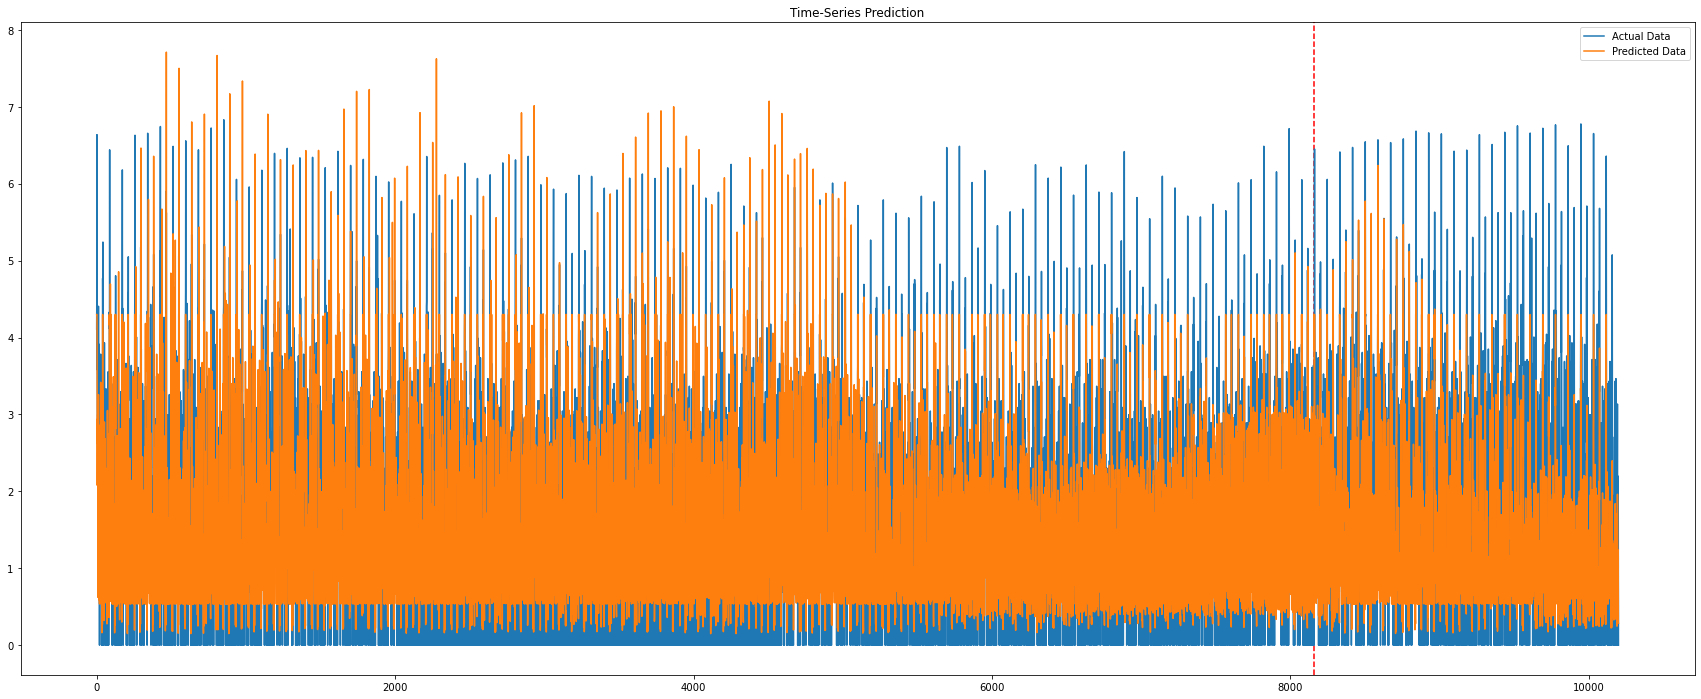

In [431]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [432]:
len(predicted)

10200

In [433]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [434]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [435]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [436]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [437]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [438]:
df_temp.iloc[:, :8] = rs.transform(df_temp.iloc[:, :8])

In [439]:
df_temp.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2024-12-01   16.060131    1.055337      1.120951    2.318582  1.735692   

              i_rate       CLI       CFI  
date                                      
2024-12-01 -0.070226 -0.602795 -1.829654

In [440]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [441]:
data_scale.shape

torch.Size([1, 1, 28])

In [442]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

예측값: tensor([[0.4775]])


array([[3.2621443]], dtype=float32)

In [443]:
np.expm1(predicted)

array([[25.105455]], dtype=float32)

In [444]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real       pred
0      35.0  72.684280
1      34.0  72.002831
2     633.0  72.684280
3      34.0  29.986092
4      23.0  11.613981
...     ...        ...
2035    0.0   1.606586
2036    0.0   0.948090
2037    8.0   5.700766
2038    1.0   0.574388
2039    0.0   0.363466

[2040 rows x 2 columns]

In [445]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 5651.118503102281, RMSE: 75.17392169564044, MSLE: 0.8123028905159289, RMSLE: 0.9012784755645332, corr: 0.5446035007794068, score: 23.390500559016036


모델 수정(배치 정규화, 드롭아웃 적용, 학습률 상향, epoch 상향, StandardScaler -> RobustScaler)

In [446]:
seed_all(seed=42)

Using Seed Number 42


In [447]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [448]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [449]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [450]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [451]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [452]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [453]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [454]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
rs = RobustScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
rs.fit(train_scale)
train4_x[scale_columns] = rs.transform(train_scale)

test4_x[scale_columns] = rs.transform(test_scale)
test4_y = ms.transform(test4_y)

In [455]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [456]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [457]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(2)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.do = nn.Dropout(0.1)
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.do(out)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.do(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [458]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 2000       # 에포크 횟수 지정
learning_rate = 0.001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [459]:
print(model)

LSTM(
  (lstm): LSTM(28, 2, batch_first=True)
  (bn_2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (do): Dropout(p=0.1, inplace=False)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [460]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.3712877035140991


Epoch: 100, loss: 0.051353488117456436
Epoch: 200, loss: 0.04343918338418007
Epoch: 300, loss: 0.03835288807749748
Epoch: 400, loss: 0.03382350876927376
Epoch: 500, loss: 0.029328571632504463
Epoch: 600, loss: 0.025366874411702156
Epoch: 700, loss: 0.023484455421566963
Epoch: 800, loss: 0.022150984033942223
Epoch: 900, loss: 0.021022936329245567
Epoch: 1000, loss: 0.02003917470574379
Epoch: 1100, loss: 0.020115334540605545
Epoch: 1200, loss: 0.019024735316634178
Epoch: 1300, loss: 0.019167102873325348
Epoch: 1400, loss: 0.018667440861463547
Epoch: 1500, loss: 0.01845458894968033
Epoch: 1600, loss: 0.018476415425539017
Epoch: 1700, loss: 0.01814744994044304
Epoch: 1800, loss: 0.017976028844714165
Epoch: 1900, loss: 0.017829207703471184


In [461]:
logdata_scale = log_data.copy()

In [462]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [463]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [464]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [465]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [466]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = rs.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [467]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713    0.000000    1.040549      1.250427       2.455   
2013-01-01   0.681205    0.000000    1.617760      1.631795       2.455   
2013-01-01   0.971694    1.609438    0.925494      2.575673       2.455   
2013-01-01   0.524523    0.693147    1.088791      1.081649       2.455   
2013-01-01   0.611009    0.000000    0.610088      1.019045       2.455   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.043162  1.409421 -0.686362 -0.091102  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.043162  1.409421 -0.686362 -0.091102  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.043162  1.409421 -0.686362 -0.091102  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.043162  1.409421 -0.686362 -0.091102  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.043162  1.409421 -0.686362 -0.091102  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [468]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

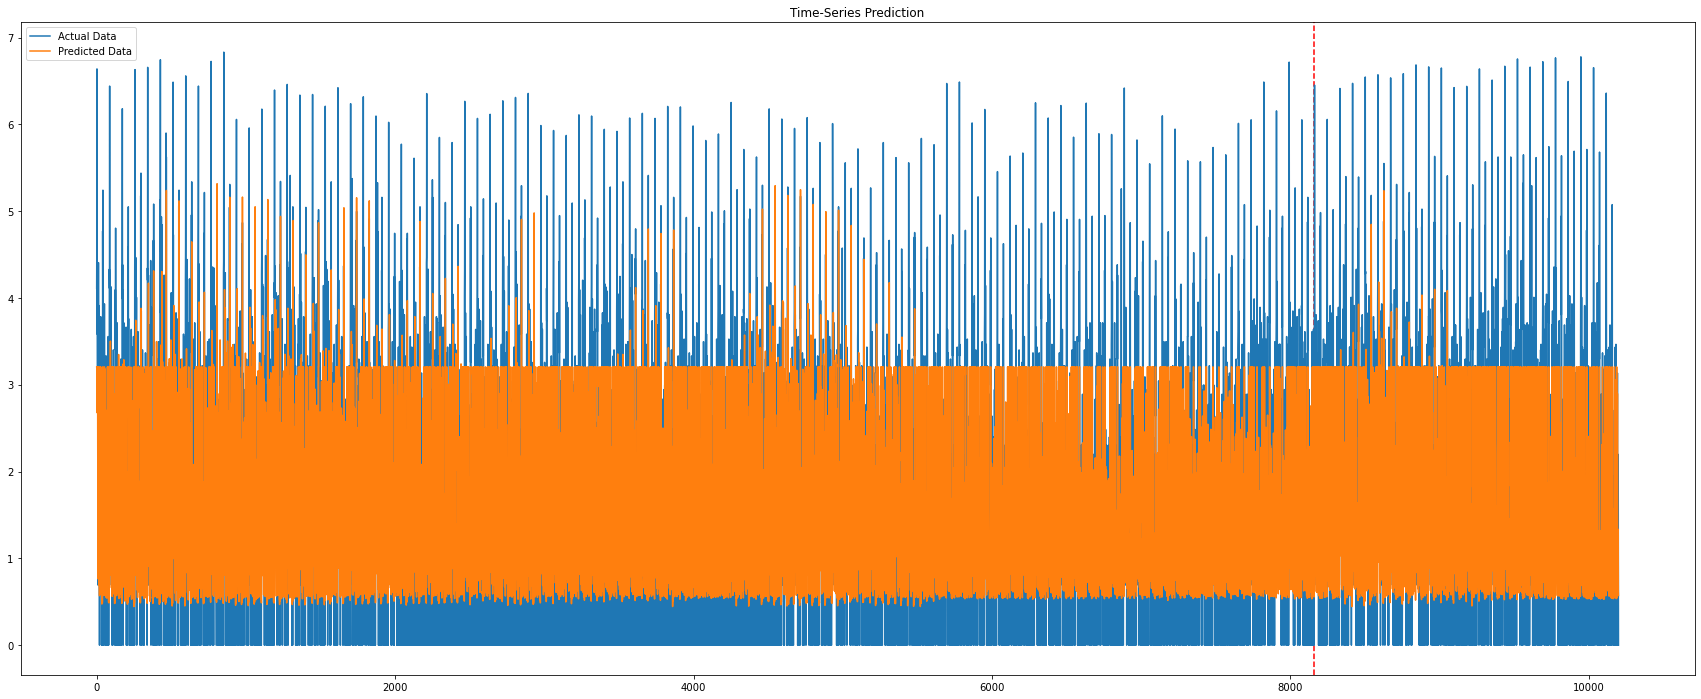

In [469]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [470]:
len(predicted)

10200

In [471]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [472]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [473]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [474]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [475]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [476]:
df_temp.iloc[:, :8] = rs.transform(df_temp.iloc[:, :8])

In [477]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [478]:
data_scale.shape

torch.Size([1, 1, 28])

In [479]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

예측값: tensor([[0.2817]])


array([[1.9244287]], dtype=float32)

In [480]:
np.expm1(predicted)

array([[5.8512335]], dtype=float32)

In [481]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real       pred
0      35.0  23.671776
1      34.0  23.671776
2     633.0  23.671776
3      34.0  23.671776
4      23.0   6.605338
...     ...        ...
2035    0.0   1.406651
2036    0.0   0.957798
2037    8.0   2.793821
2038    1.0   0.866061
2039    0.0   0.772282

[2040 rows x 2 columns]

In [482]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 6535.012771481965, RMSE: 80.83942584829487, MSLE: 0.8991424819004687, RMSLE: 0.9482312386229789, corr: 0.365857822567554, score: 11.4079704772014


RobustScaler보다 StandardScaler가 성능이 더 좋은 것으로 보임

모델 수정(배치 정규화 적용, 학습률 상향, epoch 증가, Scaler 사용 X)

In [483]:
seed_all(seed=42)

Using Seed Number 42


In [484]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [485]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [486]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [487]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [488]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [489]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [490]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y.values))
test4_y_tensors = Variable(torch.Tensor(test4_y.values))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [491]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [492]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(2)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [493]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 2000       # 에포크 횟수 지정
learning_rate = 0.001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [494]:
print(model)

LSTM(
  (lstm): LSTM(28, 2, batch_first=True)
  (bn_2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [495]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 6.376312255859375


Epoch: 100, loss: 0.77813321352005
Epoch: 200, loss: 0.6689020991325378
Epoch: 300, loss: 0.5839207172393799
Epoch: 400, loss: 0.5491981506347656
Epoch: 500, loss: 0.5309908986091614
Epoch: 600, loss: 0.47665542364120483
Epoch: 700, loss: 0.45707792043685913
Epoch: 800, loss: 0.44628092646598816
Epoch: 900, loss: 0.43824872374534607
Epoch: 1000, loss: 0.4310775399208069
Epoch: 1100, loss: 0.42478376626968384
Epoch: 1200, loss: 0.41905707120895386
Epoch: 1300, loss: 0.41423070430755615
Epoch: 1400, loss: 0.41097167134284973
Epoch: 1500, loss: 0.4085770547389984
Epoch: 1600, loss: 0.40482819080352783
Epoch: 1700, loss: 0.4016155004501343
Epoch: 1800, loss: 0.39922019839286804
Epoch: 1900, loss: 0.3972610533237457


In [496]:
logdata_scale = log_data.copy()

In [497]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [498]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [499]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [500]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [501]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

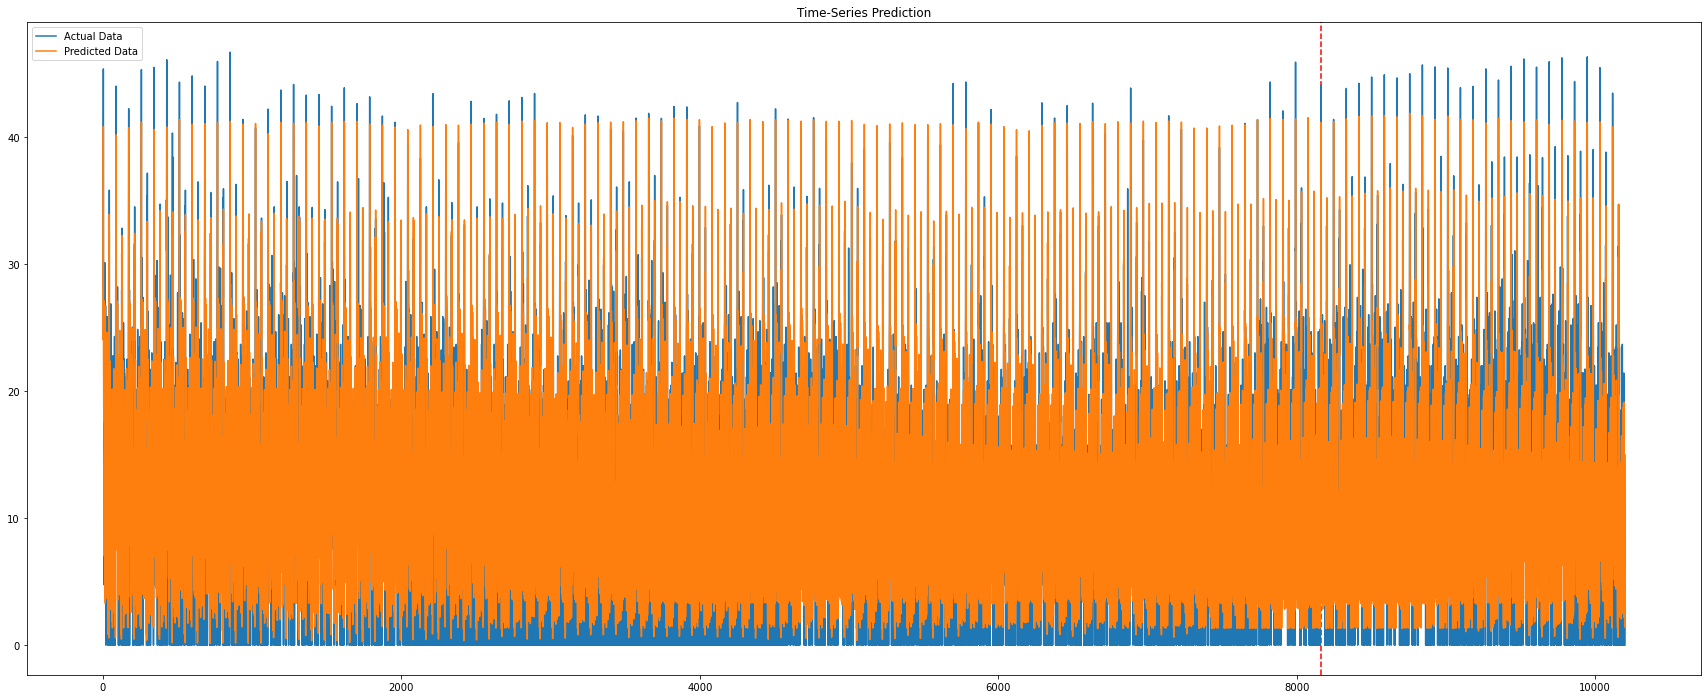

In [502]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [503]:
len(predicted)

10200

In [504]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [505]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [506]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [507]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [508]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [509]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [510]:
data_scale.shape

torch.Size([1, 1, 28])

In [511]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()
predicted

예측값: tensor([[5.4357]])


array([[5.4356675]], dtype=float32)

In [512]:
np.expm1(predicted)

array([[228.44595]], dtype=float32)

In [513]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real          pred
0      35.0  1.588420e+11
1      34.0  5.156019e+10
2     633.0  7.339537e+17
3      34.0  1.789467e+10
4      23.0  3.955367e+05
...     ...           ...
2035    0.0  7.838761e+00
2036    0.0  1.506691e+02
2037    8.0  2.426098e+05
2038    1.0  3.138237e+00
2039    0.0  5.407073e+02

[2040 rows x 2 columns]

In [514]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 1.1066203527868739e+34, RMSE: 1.051960242968751e+17, MSLE: 134.57184038022777, RMSLE: 11.600510349990115, corr: 0.8878891924755643, score: -1.5001920637775924e+32


모델 수정(배치 정규화 적용, 학습률 상향, epoch 증가, 은닉층 노드 개수 수정)

In [515]:
seed_all(seed=42)

Using Seed Number 42


In [516]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [517]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [518]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [519]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [520]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [521]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [522]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [523]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [524]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [525]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [526]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(4)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [527]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 2000       # 에포크 횟수 지정
learning_rate = 0.001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 4 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [528]:
print(model)

LSTM(
  (lstm): LSTM(28, 4, batch_first=True)
  (bn_2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=4, out_features=128, bias=True)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [529]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.058132294565439224


Epoch: 100, loss: 0.01825653575360775
Epoch: 200, loss: 0.014410343021154404
Epoch: 300, loss: 0.011637207120656967
Epoch: 400, loss: 0.010230029933154583
Epoch: 500, loss: 0.00926880445331335
Epoch: 600, loss: 0.008731109090149403
Epoch: 700, loss: 0.008367092348635197
Epoch: 800, loss: 0.008135017938911915
Epoch: 900, loss: 0.007957899011671543
Epoch: 1000, loss: 0.007832789793610573
Epoch: 1100, loss: 0.007741444744169712
Epoch: 1200, loss: 0.007662643678486347
Epoch: 1300, loss: 0.007585659623146057
Epoch: 1400, loss: 0.007513165473937988
Epoch: 1500, loss: 0.007434760686010122
Epoch: 1600, loss: 0.007361443247646093
Epoch: 1700, loss: 0.007294350303709507
Epoch: 1800, loss: 0.00723833404481411
Epoch: 1900, loss: 0.007184022571891546


In [530]:
logdata_scale = log_data.copy()

In [531]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [532]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [533]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [534]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [535]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [536]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [537]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

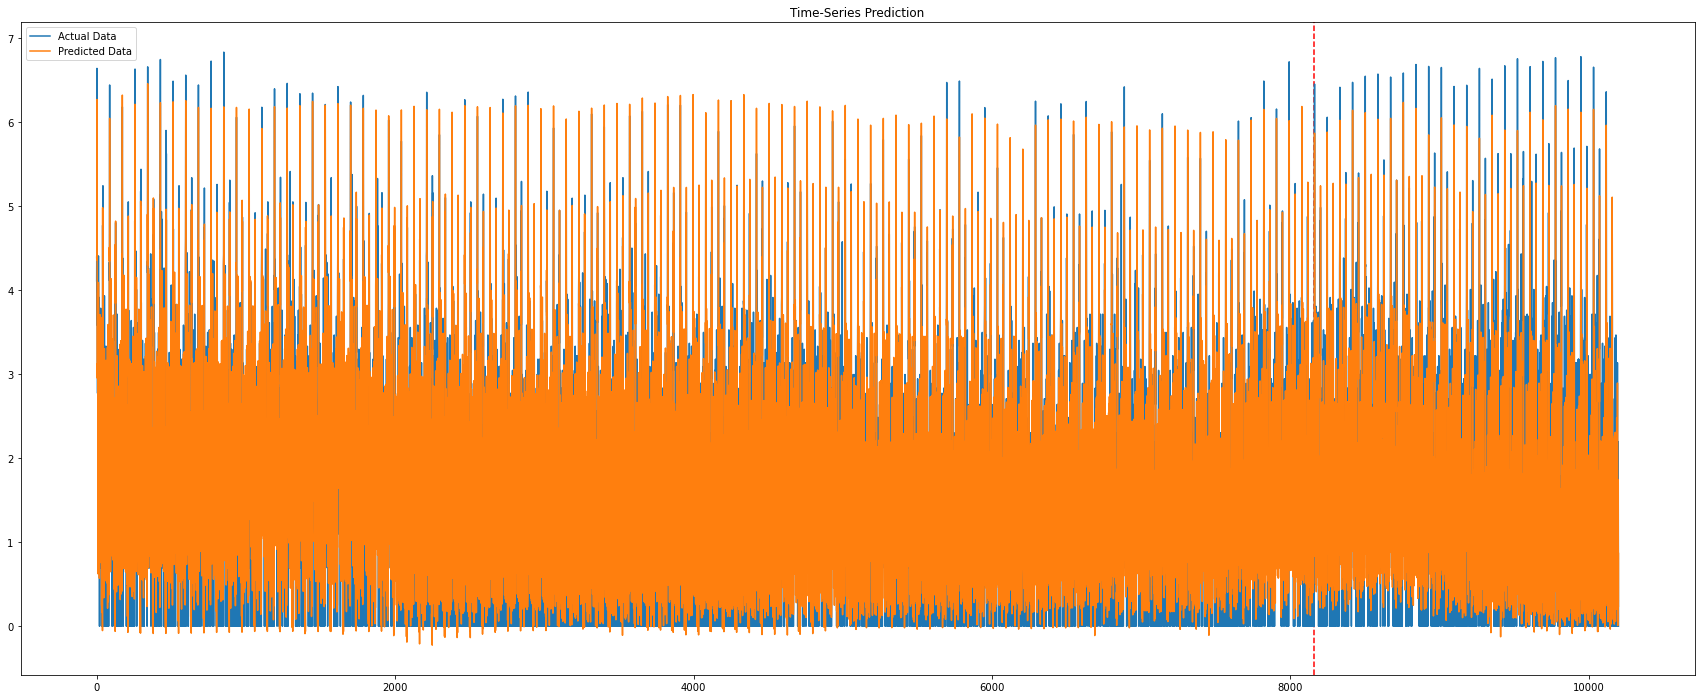

In [538]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [539]:
len(predicted)

10200

In [540]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [541]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [542]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [543]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [544]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [545]:
df_temp.iloc[:, :8] = ss.transform(df_temp.iloc[:, :8])

In [546]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [547]:
data_scale.shape

torch.Size([1, 1, 28])

In [548]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

예측값: tensor([[0.3225]])


array([[2.2031744]], dtype=float32)

In [549]:
np.expm1(predicted)

array([[8.053707]], dtype=float32)

In [550]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real        pred
0      35.0   16.732546
1      34.0    8.358335
2     633.0  352.258423
3      34.0   13.298315
4      23.0    5.371737
...     ...         ...
2035    0.0    1.632755
2036    0.0    1.209127
2037    8.0    4.697056
2038    1.0    0.256464
2039    0.0    1.378153

[2040 rows x 2 columns]

In [551]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
# MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
# RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, corr: {corr}, score: {score}')

MSE: 1515.4822633465353, RMSE: 38.9291955137341, corr: 0.9632654180175397, score: 79.45533480797965


모델 수정(배치 정규화 적용, 학습률 상향, 은닉층 노드 개수 수정)

In [552]:
seed_all(seed=42)

Using Seed Number 42


In [553]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [554]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [555]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [556]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [557]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [558]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [559]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [560]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [561]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [562]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [563]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(4)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [564]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 4 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [565]:
print(model)

LSTM(
  (lstm): LSTM(28, 4, batch_first=True)
  (bn_2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=4, out_features=128, bias=True)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [566]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.058132294565439224


Epoch: 100, loss: 0.01825653575360775
Epoch: 200, loss: 0.014410343021154404
Epoch: 300, loss: 0.011637207120656967
Epoch: 400, loss: 0.010230029933154583
Epoch: 500, loss: 0.00926880445331335
Epoch: 600, loss: 0.008731109090149403
Epoch: 700, loss: 0.008367092348635197
Epoch: 800, loss: 0.008135017938911915
Epoch: 900, loss: 0.007957899011671543


In [567]:
logdata_scale = log_data.copy()

In [568]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [569]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [570]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [571]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [572]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [573]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [574]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

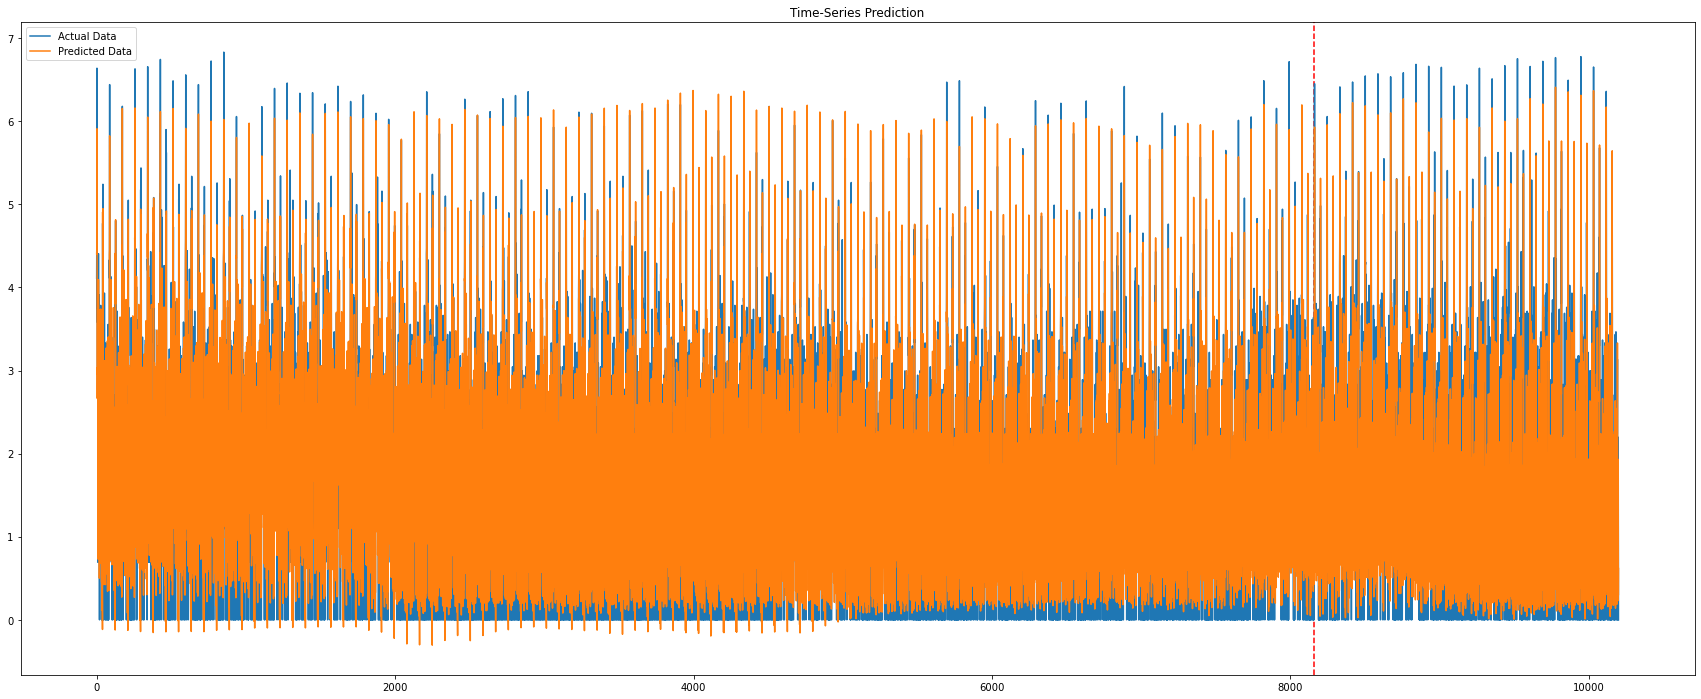

In [575]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [576]:
len(predicted)

10200

In [577]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [578]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [579]:
df_temp.to_csv('./model/prediction_df_template.csv', encoding='utf-8')

In [580]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [581]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [582]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [583]:
df_temp.iloc[:, :8] = ss.transform(df_temp.iloc[:, :8])

In [584]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [585]:
data_scale.shape

torch.Size([1, 1, 28])

In [586]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

예측값: tensor([[0.3276]])


array([[2.2383575]], dtype=float32)

In [587]:
np.expm1(predicted)

array([[8.377916]], dtype=float32)

In [588]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real        pred
0      35.0   24.137432
1      34.0   13.271832
2     633.0  374.671021
3      34.0   14.736778
4      23.0    7.358063
...     ...         ...
2035    0.0    1.621228
2036    0.0    1.097831
2037    8.0    5.887209
2038    1.0    0.345294
2039    0.0    0.853406

[2040 rows x 2 columns]

In [589]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 1172.7241239533623, RMSE: 34.245059847419775, MSLE: 0.6249362173869536, RMSLE: 0.7905290743463859, corr: 0.9590960054519175, score: 84.10194228467988


모델 수정(배치 정규화 적용, 드롭아웃 적용, 학습률 상향, 은닉층 노드 개수 수정)

In [590]:
seed_all(seed=42)

Using Seed Number 42


In [591]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [592]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [593]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [594]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [595]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [596]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [597]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [598]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [599]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [600]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [601]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(4)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.bn_1 = nn.BatchNorm1d(128)
        self.do = nn.Dropout(0.2)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.do(out)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.do(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [602]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 2000       # 에포크 횟수 지정
learning_rate = 0.001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 4 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [603]:
print(model)

LSTM(
  (lstm): LSTM(28, 4, batch_first=True)
  (bn_2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=4, out_features=128, bias=True)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [604]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.10791763663291931


Epoch: 100, loss: 0.029130319133400917
Epoch: 200, loss: 0.020374126732349396
Epoch: 300, loss: 0.01713595725595951
Epoch: 400, loss: 0.014487391337752342
Epoch: 500, loss: 0.013589599169790745
Epoch: 600, loss: 0.012852921150624752
Epoch: 700, loss: 0.012474093586206436
Epoch: 800, loss: 0.012069315649569035
Epoch: 900, loss: 0.011862659826874733
Epoch: 1000, loss: 0.011838940903544426
Epoch: 1100, loss: 0.011143549345433712
Epoch: 1200, loss: 0.011022048071026802
Epoch: 1300, loss: 0.011131790466606617
Epoch: 1400, loss: 0.010603683069348335
Epoch: 1500, loss: 0.010706297121942043
Epoch: 1600, loss: 0.01053113304078579
Epoch: 1700, loss: 0.010451839305460453
Epoch: 1800, loss: 0.010558504611253738
Epoch: 1900, loss: 0.010415036231279373


In [605]:
logdata_scale = log_data.copy()

In [606]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [607]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [608]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [609]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [610]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [611]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [612]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

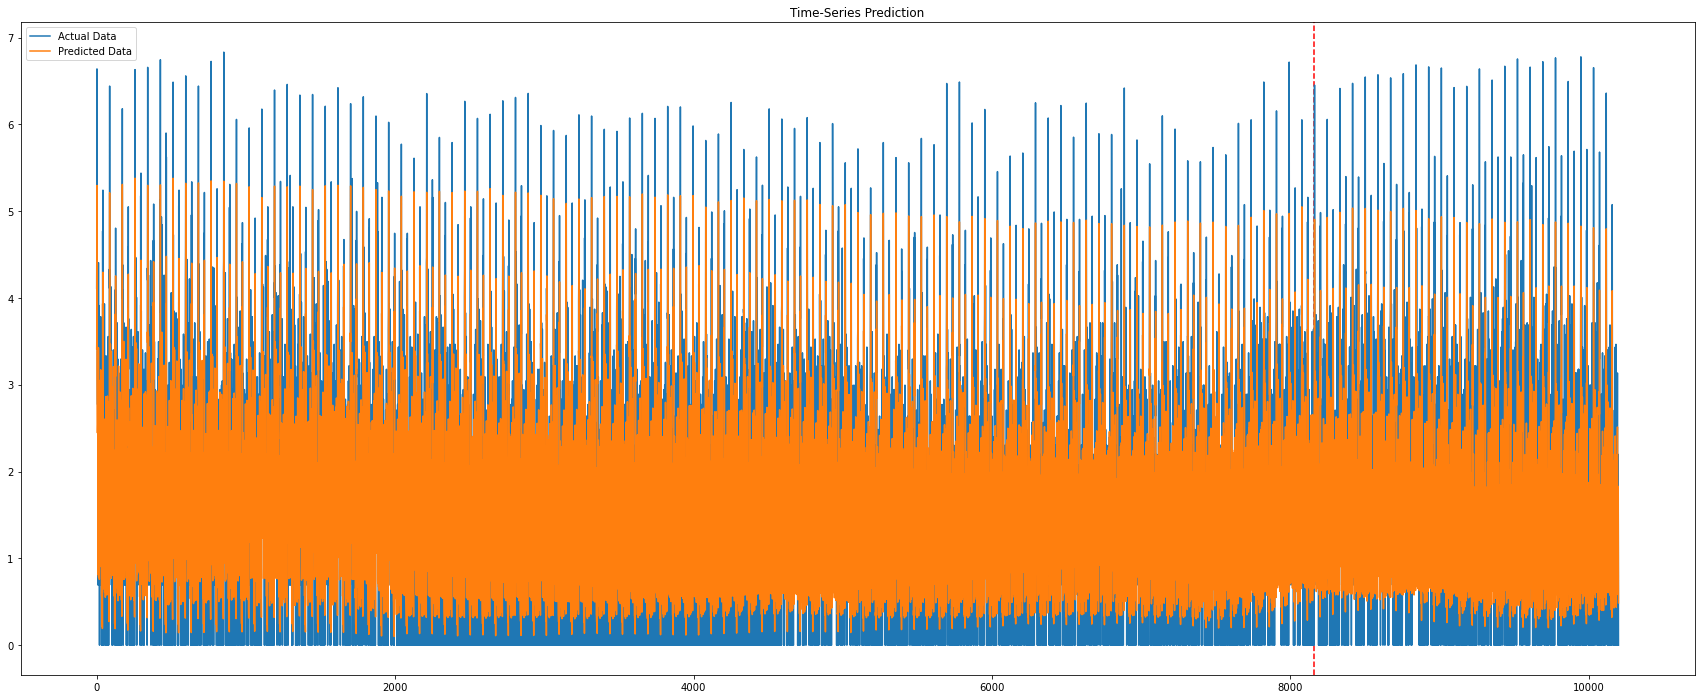

In [613]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [614]:
len(predicted)

10200

In [615]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [616]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [617]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [618]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [619]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [620]:
df_temp.iloc[:, :8] = ss.transform(df_temp.iloc[:, :8])

In [621]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [622]:
data_scale.shape

torch.Size([1, 1, 28])

In [623]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

예측값: tensor([[0.3569]])


array([[2.4383583]], dtype=float32)

In [624]:
np.expm1(predicted)

array([[10.454221]], dtype=float32)

In [625]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real        pred
0      35.0   18.798647
1      34.0   20.306093
2     633.0  133.965836
3      34.0   17.876436
4      23.0    2.560793
...     ...         ...
2035    0.0    1.313675
2036    0.0    0.914016
2037    8.0    5.224241
2038    1.0    1.146266
2039    0.0    0.626924

[2040 rows x 2 columns]

In [626]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 4771.809850190715, RMSE: 69.07828783482343, MSLE: 0.7774643366987545, RMSLE: 0.8817393813926848, corr: 0.9573781484490358, score: 35.31086565429773


모델 수정(배치 정규화 적용, 학습률 상향, epoch 증가, Scaler 사용 X)

In [627]:
seed_all(seed=42)

Using Seed Number 42


In [628]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [629]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [630]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [631]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [632]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [633]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [634]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y.values))
test4_y_tensors = Variable(torch.Tensor(test4_y.values))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [635]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [636]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(2)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [637]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 2000       # 에포크 횟수 지정
learning_rate = 0.001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [638]:
print(model)

LSTM(
  (lstm): LSTM(28, 2, batch_first=True)
  (bn_2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [639]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 6.376312255859375


Epoch: 100, loss: 0.77813321352005
Epoch: 200, loss: 0.6689020991325378
Epoch: 300, loss: 0.5839207172393799
Epoch: 400, loss: 0.5491981506347656
Epoch: 500, loss: 0.5309908986091614
Epoch: 600, loss: 0.47665542364120483
Epoch: 700, loss: 0.45707792043685913
Epoch: 800, loss: 0.44628092646598816
Epoch: 900, loss: 0.43824872374534607
Epoch: 1000, loss: 0.4310775399208069
Epoch: 1100, loss: 0.42478376626968384
Epoch: 1200, loss: 0.41905707120895386
Epoch: 1300, loss: 0.41423070430755615
Epoch: 1400, loss: 0.41097167134284973
Epoch: 1500, loss: 0.4085770547389984
Epoch: 1600, loss: 0.40482819080352783
Epoch: 1700, loss: 0.4016155004501343
Epoch: 1800, loss: 0.39922019839286804
Epoch: 1900, loss: 0.3972610533237457


In [640]:
logdata_scale = log_data.copy()

In [641]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [642]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [643]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [644]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [645]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

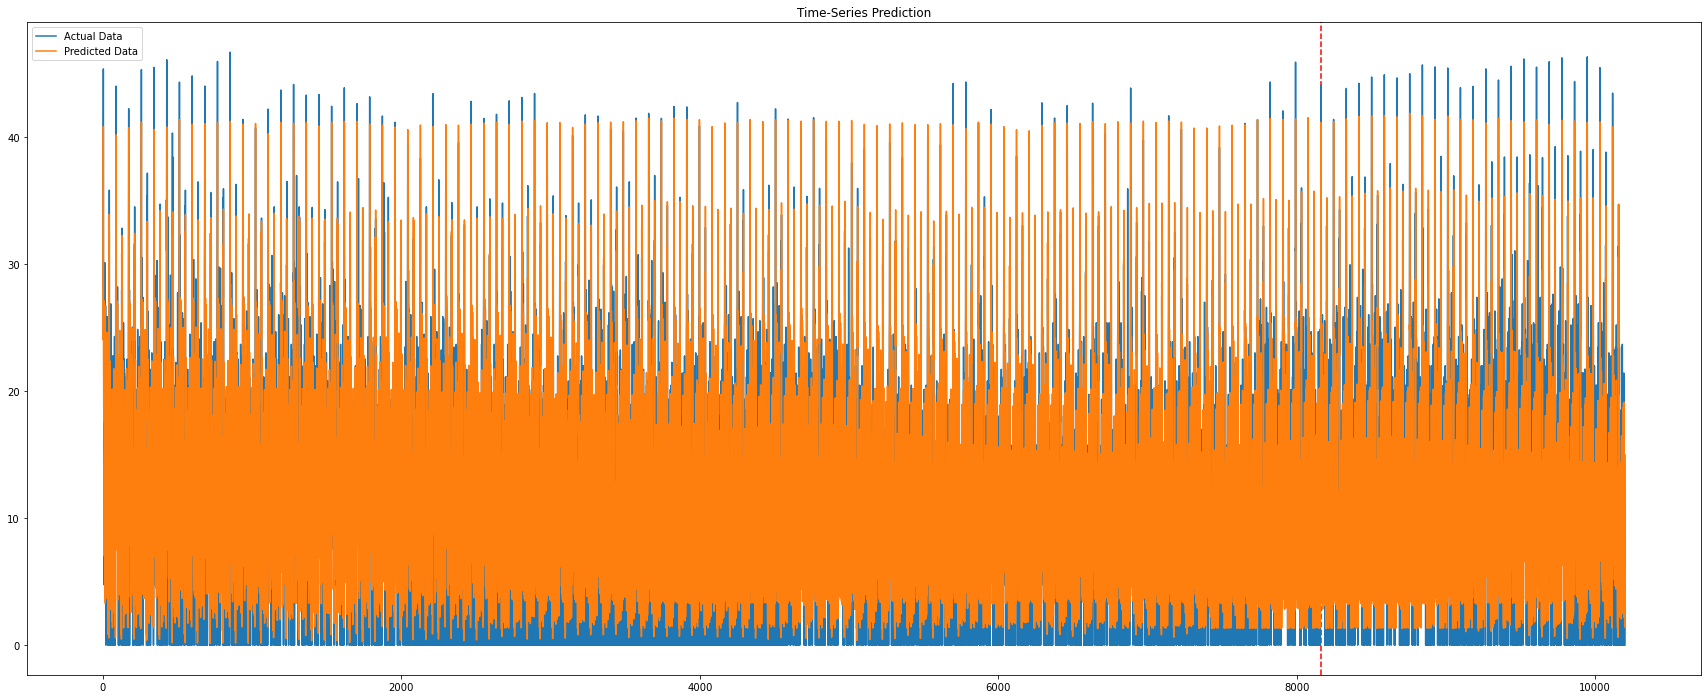

In [646]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [647]:
len(predicted)

10200

In [648]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [649]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [650]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [651]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [652]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [653]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [654]:
data_scale.shape

torch.Size([1, 1, 28])

In [655]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()
predicted

예측값: tensor([[5.4357]])


array([[5.4356675]], dtype=float32)

In [656]:
np.expm1(predicted)

array([[228.44595]], dtype=float32)

In [657]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real          pred
0      35.0  1.588420e+11
1      34.0  5.156019e+10
2     633.0  7.339537e+17
3      34.0  1.789467e+10
4      23.0  3.955367e+05
...     ...           ...
2035    0.0  7.838761e+00
2036    0.0  1.506691e+02
2037    8.0  2.426098e+05
2038    1.0  3.138237e+00
2039    0.0  5.407073e+02

[2040 rows x 2 columns]

In [659]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 1.1066203527868739e+34, RMSE: 1.051960242968751e+17, MSLE: 134.57184038022777, RMSLE: 11.600510349990115, corr: 0.8878891924755643, score: -1.5001920637775924e+32


## 최종 모델 선정 및 저장

배치 정규화 적용, 학습률 상향, 은닉층 노드 개수 수정 모델 선정

In [660]:
seed_all(seed=42)

Using Seed Number 42


In [661]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)


In [662]:
# city, industry 컬럼 One-Hot encoding
# train, test 데이터에 city, industry는 모두 같은 것으로 반복.
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse=False, drop='first')
oe.fit(train_data4[object_columns])
train_cat = oe.transform(train_data4[object_columns])
test_cat = oe.transform(test_data4[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
train_cat_df = pd.DataFrame(train_cat, columns=column_name)
test_cat_df = pd.DataFrame(test_cat, columns=column_name)

train_data4 = pd.concat([train_data4, train_cat_df], axis=1)
test_data4 = pd.concat([test_data4, test_cat_df], axis=1)

In [663]:
train_data4.drop(object_columns, axis=1, inplace=True)
test_data4.drop(object_columns, axis=1, inplace=True)

In [664]:
display(train_data4, test_data4)

date  job_offer  employment  no_company  unemployment  population  \
0    2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
1    2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2    2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
3    2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
4    2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...         ...        ...         ...         ...           ...         ...   
8155 2020-12-01   3.637586    0.000000    7.578657      0.693147   13.421929   
8156 2020-12-01   0.000000    0.000000    8.787526      1.386294   13.421929   
8157 2020-12-01   1.945910    0.000000    6.061457      2.833213   13.421929   
8158 2020-12-01   0.000000    0.000000    7.198931      1.386294   13.421929   
8159 2020-12-01   1.609438    0.000000    7.156956      1.098612   13.421929   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
1     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
2     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
3     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
4     7.354810  1.321756  4.606665  4.624973  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
8155  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8156  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8157  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8158  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   
8159  7.517793  0.405465  4.631365  4.523960  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
8155  0.0                       0.0               0.0    0.0  1.0  
8156  0.0                       0.0               0.0    0.0  0.0  
8157  0.0                       0.0               0.0    1.0  0.0  
8158  0.0                       0.0               1.0    0.0  0.0  
8159  0.0                       1.0               0.0    0.0  0.0  

[8160 rows x 30 columns]

date  job_offer  employment  no_company  unemployment  population  \
0    2021-01-01   3.583519    1.098612   10.385574      4.753590   16.083294   
1    2021-01-01   3.555348    0.000000   11.786199      5.123964   16.083294   
2    2021-01-01   6.452049    2.079442   10.392221      7.266827   16.083294   
3    2021-01-01   3.555348    0.693147   10.784835      4.812184   16.083294   
4    2021-01-01   3.178054    0.693147    9.836920      4.653960   16.083294   
...         ...        ...         ...         ...           ...         ...   
2035 2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2036 2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2037 2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2038 2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2039 2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

           GDP    i_rate       CLI       CFI  ...   인천   전남   전북   제주   충남  \
0     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
1     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
2     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
3     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
4     7.559924  0.405465  4.634959  4.568506  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2035  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2036  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2037  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2038  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   
2039  7.585687  1.446919  4.602676  4.513055  ...  0.0  0.0  0.0  1.0  0.0   

       충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업  
0     0.0                       0.0               0.0    0.0  1.0  
1     0.0                       0.0               0.0    0.0  0.0  
2     0.0                       0.0               0.0    1.0  0.0  
3     0.0                       0.0               1.0    0.0  0.0  
4     0.0                       1.0               0.0    0.0  0.0  
...   ...                       ...               ...    ...  ...  
2035  0.0                       0.0               0.0    0.0  1.0  
2036  0.0                       0.0               0.0    0.0  0.0  
2037  0.0                       0.0               0.0    1.0  0.0  
2038  0.0                       0.0               1.0    0.0  0.0  
2039  0.0                       1.0               0.0    0.0  0.0  

[2040 rows x 30 columns]

In [665]:
# 날짜 컬럼을 인덱스로 사용
train_data4.set_index('date', inplace=True)
test_data4.set_index('date', inplace=True)

In [666]:
# 독립변수, 종속변수 분리
train4_x = train_data4.drop('job_offer', axis=1)
train4_y = train_data4[['job_offer']]

test4_x = test_data4.drop('job_offer', axis=1)
test4_y = test_data4[['job_offer']]

print(train4_x.shape, train4_y.shape, test4_x.shape, test4_y.shape)

(8160, 28) (8160, 1) (2040, 28) (2040, 1)


In [667]:
train4_x.iloc[:, :8]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2020-12-01    0.000000    7.578657      0.693147   13.421929  7.517793   
2020-12-01    0.000000    8.787526      1.386294   13.421929  7.517793   
2020-12-01    0.000000    6.061457      2.833213   13.421929  7.517793   
2020-12-01    0.000000    7.198931      1.386294   13.421929  7.517793   
2020-12-01    0.000000    7.156956      1.098612   13.421929  7.517793   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  
2020-12-01  0.405465  4.631365  4.523960  

[8160 rows x 8 columns]

In [668]:
# Scaling
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train4_x[scale_columns]
test_scale = test4_x[scale_columns]
ms = MinMaxScaler()
ss = StandardScaler()

# 종속변수에는 MinMaxScaler, 독립변수에는 StandardScaler 사용
ms.fit(train4_y)
train4_y = ms.transform(train4_y)
ss.fit(train_scale)
train4_x[scale_columns] = ss.transform(train_scale)

test4_x[scale_columns] = ss.transform(test_scale)
test4_y = ms.transform(test4_y)

In [669]:
train4_x_tensors = Variable(torch.Tensor(train4_x.values))
test4_x_tensors = Variable(torch.Tensor(test4_x.values))

train4_y_tensors = Variable(torch.Tensor(train4_y))
test4_y_tensors = Variable(torch.Tensor(test4_y))

train4_x_tensors.shape, test4_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [670]:
train4_x_tensors_f = torch.reshape(train4_x_tensors, (8160, 1, 28))
test4_x_tensors_f = torch.reshape(test4_x_tensors, (2040, 1, 28))

print(train4_x_tensors_f.shape, test4_y_tensors.shape, test4_x_tensors_f.shape, test4_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


In [671]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.bn_2 = nn.BatchNorm1d(4)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.bn_1 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.bn_2(hn)
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.bn_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

def prediction_model(data, model):
    with torch.no_grad():   # gradient 계산 비활성화. 메모리를 줄이고 연산속도를 증가
        model.eval()    # one sample 예측/test의 경우 넣어주어야 함(아니면 배치 사이즈에 맞지 않아 에러)
        single_prediction = model(data)
        print(f'예측값: {single_prediction}')
        
        return single_prediction

In [672]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 4 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train4_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [673]:
print(model)

LSTM(
  (lstm): LSTM(28, 4, batch_first=True)
  (bn_2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=4, out_features=128, bias=True)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [674]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train4_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train4_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.058132294565439224
Epoch: 100, loss: 0.01825653575360775
Epoch: 200, loss: 0.014410343021154404
Epoch: 300, loss: 0.011637207120656967
Epoch: 400, loss: 0.010230029933154583
Epoch: 500, loss: 0.00926880445331335
Epoch: 600, loss: 0.008731109090149403
Epoch: 700, loss: 0.008367092348635197
Epoch: 800, loss: 0.008135017938911915
Epoch: 900, loss: 0.007957899011671543


In [675]:
logdata_scale = log_data.copy()

In [676]:
logdata_scale

date city                  industry  job_offer  employment  \
0     2013-01-01   서울                       제조업   4.110874    0.000000   
1     2013-01-01   서울                  도매 및 소매업   4.653960    0.000000   
2     2013-01-01   서울                     정보통신업   6.638568    1.609438   
3     2013-01-01   서울          전문, 과학 및 기술 서비스업   3.583519    0.693147   
4     2013-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업   4.174387    0.000000   
...          ...  ...                       ...        ...         ...   
10195 2022-12-01   제주                       제조업   0.000000    0.000000   
10196 2022-12-01   제주                  도매 및 소매업   0.000000    0.000000   
10197 2022-12-01   제주                     정보통신업   2.197225    0.000000   
10198 2022-12-01   제주          전문, 과학 및 기술 서비스업   0.693147    0.000000   
10199 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업   0.000000    0.000000   

       no_company  unemployment  population       GDP    i_rate       CLI  \
0       10.316259      4.584967   16.137414  7.354810  1.321756  4.606665   
1       11.602611      5.313206   16.137414  7.354810  1.321756  4.606665   
2       10.059850      7.115582   16.137414  7.354810  1.321756  4.606665   
3       10.423768      4.262680   16.137414  7.354810  1.321756  4.606665   
4        9.356948      4.143135   16.137414  7.354810  1.321756  4.606665   
...           ...           ...         ...       ...       ...       ...   
10195    7.666222      1.098612   13.427139  7.585687  1.446919  4.602676   
10196    8.907342      1.945910   13.427139  7.585687  1.446919  4.602676   
10197    6.327937      3.178054   13.427139  7.585687  1.446919  4.602676   
10198    7.353722      1.609438   13.427139  7.585687  1.446919  4.602676   
10199    7.278629      2.197225   13.427139  7.585687  1.446919  4.602676   

            CFI  
0      4.624973  
1      4.624973  
2      4.624973  
3      4.624973  
4      4.624973  
...         ...  
10195  4.513055  
10196  4.513055  
10197  4.513055  
10198  4.513055  
10199  4.513055  

[10200 rows x 12 columns]

In [677]:
object_columns = ['city', 'industry']

log_cat = oe.transform(logdata_scale[object_columns])
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
log_cat_df = pd.DataFrame(log_cat, columns=column_name)

logdata_scale = pd.concat([logdata_scale, log_cat_df], axis=1)
logdata_scale.drop(object_columns, axis=1, inplace=True)

In [678]:
logdata_scale.set_index('date', inplace=True)
logdata_scale

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   4.110874    0.000000   10.316259      4.584967   16.137414   
2013-01-01   4.653960    0.000000   11.602611      5.313206   16.137414   
2013-01-01   6.638568    1.609438   10.059850      7.115582   16.137414   
2013-01-01   3.583519    0.693147   10.423768      4.262680   16.137414   
2013-01-01   4.174387    0.000000    9.356948      4.143135   16.137414   
...               ...         ...         ...           ...         ...   
2022-12-01   0.000000    0.000000    7.666222      1.098612   13.427139   
2022-12-01   0.000000    0.000000    8.907342      1.945910   13.427139   
2022-12-01   2.197225    0.000000    6.327937      3.178054   13.427139   
2022-12-01   0.693147    0.000000    7.353722      1.609438   13.427139   
2022-12-01   0.000000    0.000000    7.278629      2.197225   13.427139   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
2013-01-01  7.354810  1.321756  4.606665  4.624973  0.0  ...  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   
2022-12-01  7.585687  1.446919  4.602676  4.513055  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   
...         ...  ...  ...                       ...               ...    ...   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    0.0   
2022-12-01  1.0  0.0  0.0                       0.0               0.0    1.0   
2022-12-01  1.0  0.0  0.0                       0.0               1.0    0.0   
2022-12-01  1.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
...         ...  
2022-12-01  1.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  
2022-12-01  0.0  

[10200 rows x 29 columns]

In [679]:
logdata_scale.iloc[:, 1:9]

employment  no_company  unemployment  population       GDP  \
date                                                                     
2013-01-01    0.000000   10.316259      4.584967   16.137414  7.354810   
2013-01-01    0.000000   11.602611      5.313206   16.137414  7.354810   
2013-01-01    1.609438   10.059850      7.115582   16.137414  7.354810   
2013-01-01    0.693147   10.423768      4.262680   16.137414  7.354810   
2013-01-01    0.000000    9.356948      4.143135   16.137414  7.354810   
...                ...         ...           ...         ...       ...   
2022-12-01    0.000000    7.666222      1.098612   13.427139  7.585687   
2022-12-01    0.000000    8.907342      1.945910   13.427139  7.585687   
2022-12-01    0.000000    6.327937      3.178054   13.427139  7.585687   
2022-12-01    0.000000    7.353722      1.609438   13.427139  7.585687   
2022-12-01    0.000000    7.278629      2.197225   13.427139  7.585687   

              i_rate       CLI       CFI  
date                                      
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
2013-01-01  1.321756  4.606665  4.624973  
...              ...       ...       ...  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  
2022-12-01  1.446919  4.602676  4.513055  

[10200 rows x 8 columns]

In [680]:
# 모델 예측 결과 출력
logdata_scale.iloc[:, 1:9] = ss.transform(logdata_scale.iloc[:, 1:9])
logdata_scale['job_offer'] = ms.transform(logdata_scale[['job_offer']])

In [681]:
logdata_scale.head()

job_offer  employment  no_company  unemployment  population  \
date                                                                      
2013-01-01   0.601713   -0.453786    1.382974      1.426953    1.789595   
2013-01-01   0.681205   -0.453786    2.224989      1.899060    1.789595   
2013-01-01   0.971694    2.685977    1.215134      3.067516    1.789595   
2013-01-01   0.524523    0.898436    1.453346      1.218018    1.789595   
2013-01-01   0.611009   -0.453786    0.755031      1.140518    1.789595   

                 GDP    i_rate       CLI       CFI   경기  ...   인천   전남   전북  \
date                                                     ...                  
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   
2013-01-01 -1.646227  1.616496 -1.040983  0.035388  0.0  ...  0.0  0.0  0.0   

             제주   충남   충북  사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  \
date                                                                           
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    0.0   
2013-01-01  0.0  0.0  0.0                       0.0               0.0    1.0   
2013-01-01  0.0  0.0  0.0                       0.0               1.0    0.0   
2013-01-01  0.0  0.0  0.0                       1.0               0.0    0.0   

            제조업  
date             
2013-01-01  1.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  
2013-01-01  0.0  

[5 rows x 29 columns]

In [682]:
logdata_scale_x = logdata_scale.drop('job_offer', axis=1)
logdata_scale_y = logdata_scale[['job_offer']]

logdata_scale_x = Variable(torch.Tensor(logdata_scale_x.values))
logdata_scale_y = Variable(torch.Tensor(logdata_scale_y.values))

logdata_scale_x = torch.reshape(logdata_scale_x, (logdata_scale_x.shape[0], 1, logdata_scale_x.shape[1]))

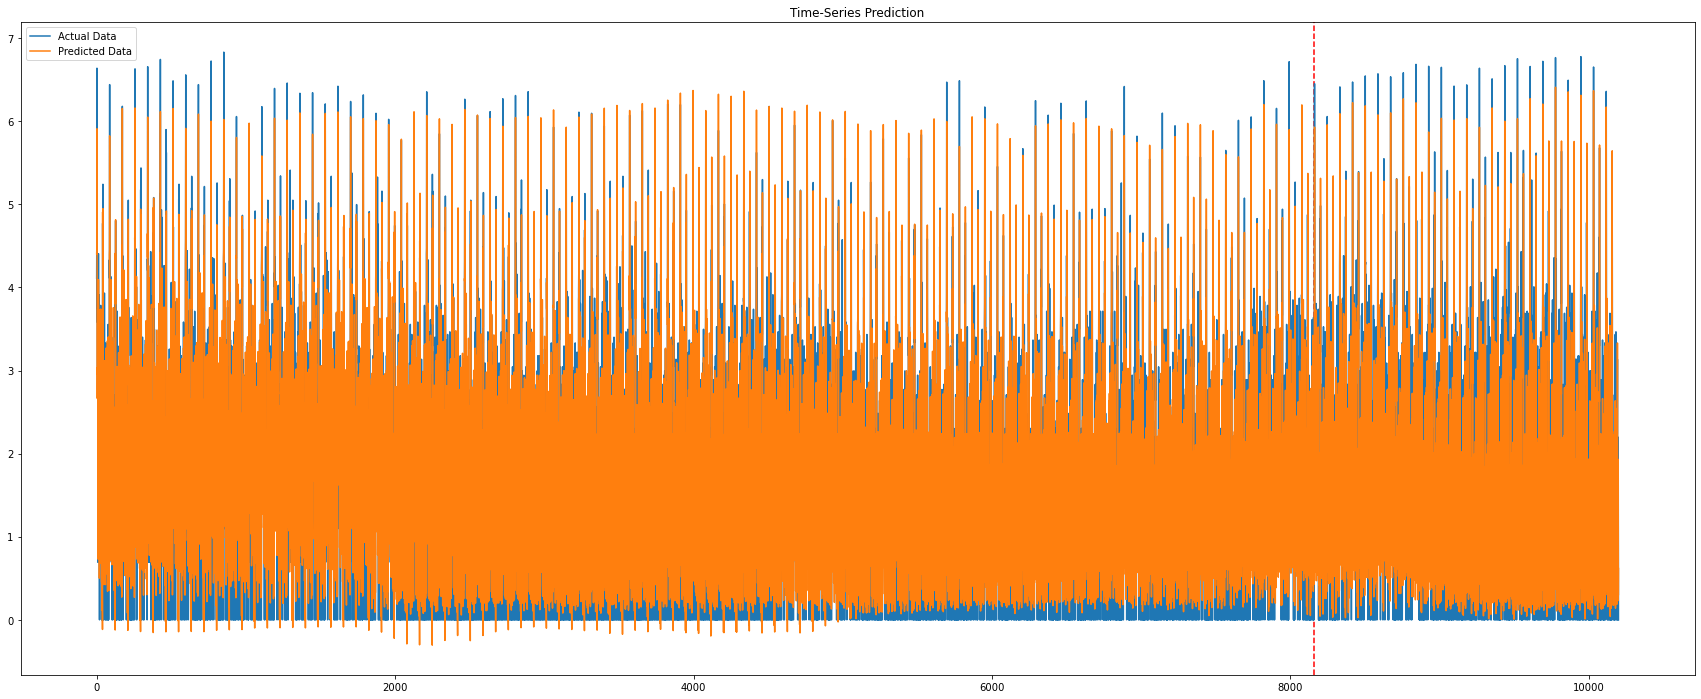

In [683]:
model.eval()
train_predict = model(logdata_scale_x)
predicted = train_predict.data.numpy()
label_y = logdata_scale_y.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [684]:
len(predicted)

10200

In [685]:
df_temp = pd.DataFrame(columns=train4_x.columns, index=[0])
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   인천   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업  
0              NaN   NaN  NaN  

[1 rows x 28 columns]

In [686]:
df_temp['date'] = np.NaN
df_temp

employment no_company unemployment population  GDP i_rate  CLI  CFI   경기  \
0        NaN        NaN          NaN        NaN  NaN    NaN  NaN  NaN  NaN   

    경남  ...   전남   전북   제주   충남   충북 사업시설 관리, 사업 지원 및 임대 서비스업  \
0  NaN  ...  NaN  NaN  NaN  NaN  NaN                      NaN   

  전문, 과학 및 기술 서비스업 정보통신업  제조업 date  
0              NaN   NaN  NaN  NaN  

[1 rows x 29 columns]

In [687]:
df_temp.to_csv('./model/prediction_df_template.csv', encoding='utf-8')

In [688]:
df_temp['date'] = 202412
df_temp['employment'] = np.log1p(9436836)
df_temp['no_company'] = np.log1p(31231.5047)
df_temp['unemployment'] = np.log1p(75.5335)
df_temp['population'] = np.log1p(9.286929e+06)
df_temp['GDP'] = np.log1p(2060.4709)
df_temp['i_rate'] = np.log1p(1.4500)
df_temp['CLI'] = np.log1p(99.2360)
df_temp['CFI'] = np.log1p(90.2)

In [689]:
df_temp.fillna(0.0, inplace=True)
df_temp

employment  no_company  unemployment  population       GDP    i_rate  \
0   16.060131   10.349215      4.337729   16.044119  7.631175  0.896088   

        CLI       CFI   경기   경남  ...   전남   전북   제주   충남   충북  \
0  4.607527  4.513055  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

   사업시설 관리, 사업 지원 및 임대 서비스업  전문, 과학 및 기술 서비스업  정보통신업  제조업    date  
0                       0.0               0.0    0.0  0.0  202412  

[1 rows x 29 columns]

In [690]:
df_temp['서울'] = df_temp['제조업'] = 1.0
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y%m')
df_temp.set_index('date', inplace=True)

In [691]:
df_temp.iloc[:, :8] = ss.transform(df_temp.iloc[:, :8])

In [692]:
data_scale = Variable(torch.Tensor(df_temp.values))

data_scale = torch.reshape(data_scale, (data_scale.shape[0], 1, data_scale.shape[1]))

In [693]:
data_scale.shape

torch.Size([1, 1, 28])

In [694]:
predict = prediction_model(data_scale, model)
predicted = predict.data.numpy()

predicted = ms.inverse_transform(predicted)
predicted

예측값: tensor([[0.3276]])


array([[2.2383575]], dtype=float32)

In [695]:
np.expm1(predicted)

array([[8.377916]], dtype=float32)

In [696]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test4_x_tensors_f)

predicted = predict.data.numpy()
predicted = ms.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':np.expm1(predicted).reshape(-1)})
pred_df

real        pred
0      35.0   24.137432
1      34.0   13.271832
2     633.0  374.671021
3      34.0   14.736778
4      23.0    7.358063
...     ...         ...
2035    0.0    1.621228
2036    0.0    1.097831
2037    8.0    5.887209
2038    1.0    0.345294
2039    0.0    0.853406

[2040 rows x 2 columns]

In [697]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])
RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, MSLE: {MSLE}, RMSLE: {RMSLE}, corr: {corr}, score: {score}')

MSE: 1172.7241239533623, RMSE: 34.245059847419775, MSLE: 0.6249362173869536, RMSLE: 0.7905290743463859, corr: 0.9590960054519175, score: 84.10194228467988


In [50]:
torch.save(model.state_dict(), './model/LSTM_모델_dict.pt')

In [ ]:
from pickle import dump
dump(ss, open('./model/X_label_scaler.pkl', 'wb'))
dump(ms, open('./model/Y_label_scaler.pkl', 'wb'))

In [ ]:
torch.__version__

'1.10.0'

In [ ]:
import pickle
print(pickle.format_version)

4.0


발표용 비교표

In [698]:
pred_df

real        pred
0      35.0   24.137432
1      34.0   13.271832
2     633.0  374.671021
3      34.0   14.736778
4      23.0    7.358063
...     ...         ...
2035    0.0    1.621228
2036    0.0    1.097831
2037    8.0    5.887209
2038    1.0    0.345294
2039    0.0    0.853406

[2040 rows x 2 columns]

In [700]:
pred_df_copy = pred_df.copy()
pred_df_copy['real'] = pred_df_copy['real'].astype(int)
pred_df_copy['pred'] = pred_df_copy['pred'].astype(int)
pred_df_copy

real  pred
0       35    24
1       34    13
2      633   374
3       34    14
4       23     7
...    ...   ...
2035     0     1
2036     0     1
2037     8     5
2038     1     0
2039     0     0

[2040 rows x 2 columns]

In [702]:
pred_real = rawdata.iloc[8160:, :].reset_index(drop=True)[['date', 'city', 'industry']]
pred_real

date city                  industry
0    2021-01-01   서울                       제조업
1    2021-01-01   서울                  도매 및 소매업
2    2021-01-01   서울                     정보통신업
3    2021-01-01   서울          전문, 과학 및 기술 서비스업
4    2021-01-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업
...         ...  ...                       ...
2035 2022-12-01   제주                       제조업
2036 2022-12-01   제주                  도매 및 소매업
2037 2022-12-01   제주                     정보통신업
2038 2022-12-01   제주          전문, 과학 및 기술 서비스업
2039 2022-12-01   제주  사업시설 관리, 사업 지원 및 임대 서비스업

[2040 rows x 3 columns]

In [706]:
pred_real['date'] = pred_real['date'].dt.strftime('%Y-%m')
pred_real

date city                  industry
0     2021-01   서울                       제조업
1     2021-01   서울                  도매 및 소매업
2     2021-01   서울                     정보통신업
3     2021-01   서울          전문, 과학 및 기술 서비스업
4     2021-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업
...       ...  ...                       ...
2035  2022-12   제주                       제조업
2036  2022-12   제주                  도매 및 소매업
2037  2022-12   제주                     정보통신업
2038  2022-12   제주          전문, 과학 및 기술 서비스업
2039  2022-12   제주  사업시설 관리, 사업 지원 및 임대 서비스업

[2040 rows x 3 columns]

In [707]:
pred_real_df = pd.concat([pred_real, pred_df_copy], axis=1)
pred_real_df

date city                  industry  real  pred
0     2021-01   서울                       제조업    35    24
1     2021-01   서울                  도매 및 소매업    34    13
2     2021-01   서울                     정보통신업   633   374
3     2021-01   서울          전문, 과학 및 기술 서비스업    34    14
4     2021-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업    23     7
...       ...  ...                       ...   ...   ...
2035  2022-12   제주                       제조업     0     1
2036  2022-12   제주                  도매 및 소매업     0     1
2037  2022-12   제주                     정보통신업     8     5
2038  2022-12   제주          전문, 과학 및 기술 서비스업     1     0
2039  2022-12   제주  사업시설 관리, 사업 지원 및 임대 서비스업     0     0

[2040 rows x 5 columns]

In [708]:
pred_real_df.loc[pred_real_df['real'] == pred_real_df['pred']]

date city                  industry  real  pred
21    2021-01   광주                  도매 및 소매업     4     4
22    2021-01   광주                     정보통신업    22    22
29    2021-01   대전  사업시설 관리, 사업 지원 및 임대 서비스업     0     0
32    2021-01   울산                     정보통신업     5     5
34    2021-01   울산  사업시설 관리, 사업 지원 및 임대 서비스업     0     0
...       ...  ...                       ...   ...   ...
2023  2022-12   전남          전문, 과학 및 기술 서비스업     1     1
2024  2022-12   전남  사업시설 관리, 사업 지원 및 임대 서비스업     0     0
2029  2022-12   경북  사업시설 관리, 사업 지원 및 임대 서비스업     0     0
2034  2022-12   경남  사업시설 관리, 사업 지원 및 임대 서비스업     0     0
2039  2022-12   제주  사업시설 관리, 사업 지원 및 임대 서비스업     0     0

[386 rows x 5 columns]

In [709]:
pred_real_df.loc[pred_real_df['real'] != pred_real_df['pred']]

date city                  industry  real  pred
0     2021-01   서울                       제조업    35    24
1     2021-01   서울                  도매 및 소매업    34    13
2     2021-01   서울                     정보통신업   633   374
3     2021-01   서울          전문, 과학 및 기술 서비스업    34    14
4     2021-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업    23     7
...       ...  ...                       ...   ...   ...
2033  2022-12   경남          전문, 과학 및 기술 서비스업     0     2
2035  2022-12   제주                       제조업     0     1
2036  2022-12   제주                  도매 및 소매업     0     1
2037  2022-12   제주                     정보통신업     8     5
2038  2022-12   제주          전문, 과학 및 기술 서비스업     1     0

[1654 rows x 5 columns]

In [712]:
pred_real_df.loc[pred_real_df['real'] != pred_real_df['pred']].iloc[3:8, :]

date city                  industry  real  pred
3  2021-01   서울          전문, 과학 및 기술 서비스업    34    14
4  2021-01   서울  사업시설 관리, 사업 지원 및 임대 서비스업    23     7
5  2021-01   부산                       제조업    13     9
6  2021-01   부산                  도매 및 소매업     9     6
7  2021-01   부산                     정보통신업    38    40